# The HAM10000 dataset: exploration

<a id='contents'></a>
## Contents

* [The HAM10000 dataset](#HAM10000_dataset)
* [Data exploration](#data_exploration)
    * [Summary](#summary)
    * [Packages](#packages)
    * [Loading metadata](#loading_metadata)
    * [Checking image size, mode, and format](#checking_image)
    * [Viewing some images alongside metadata](#viewing_images)
    * [Ink and other artifacts](#artifacts)
    * [Metadata info](#metadata_info)
    * [Multiplicities](#multiplicities)
    * [Viewing multiple images of some lesions](#viewing_multiple)
    * [Checking consistency of metadata](#checking_consistency)
    * [Removing duplicate lesion IDs](#removing_duplicates)
    * [Statistics](#statistics)
    * [Conditional probabilities (probability of diagnosis given feature)](#conditional_probabilities)
    * [Plots](#plots)
    * [Potentially unusual nevi](#unusual_nevi)
    * [Missing values](#missing_values)
* [References](#references)

<a id='HAM10000_dataset'></a>
### The [HAM10000 dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T)

↑ [Contents](#contents) | ↓ [Data exploration](#summary)


From [[TSC2018]](#HAM10000ref):
>Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (```akiec```), basal cell carcinoma (```bcc```), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, ```bkl```), dermatofibroma (```df```), melanoma (```mel```), melanocytic nevi (```nv```) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, ```vasc```).

>More than 50% of lesions are confirmed through histopathology (```histo```), the ground truth for the rest of the cases is either follow-up examination (```follow_up```), expert consensus (```consensus```), or confirmation by in-vivo confocal microscopy (```confocal```). The dataset includes lesions with multiple images, which can be tracked by the ```lesion_id```-column within the **HAM10000_metadata** file.

From [[WEN2022]](#Wen_et_al_ref):
>Lack of transparency in metadata reporting for clinically essential characteristics (such as ethnicity and Fitzpatrick skin type) limits the clinical utility of these images alone.

>Machine learning algorithms used for medical image classification are known to underperform on images collected from populations independent to those on which the algorithms were trained. An image classifier algorithm trained and validated predominantly on images of east Asian skin underperformed on skin lesion images of White patients from the USA.29 Likewise, the majority of algorithms submitted to the ISIC 2018 task 3 challenge performed worse on test images from an external institution independent from the training dataset.26 

>These findings highlight the dangers of implementing algorithms for widespread use on broad populations without dataset transparency, especially if algorithm training was undertaken using a restricted demographic cohort. Algorithm underperformance and misdiagnosis have serious implications for patients with skin cancer; they not only risk missing treatable malignancies, but can also result in avoidable surgical procedures and cause unnecessary anxiety.65 Our review identified limited metadata reporting for datasets and atlases, therefore raising concerns about which populations are represented and to what extent any artificial intelligence algorithms developed using these are generalisable.

>To improve algorithm applicability, algorithms should be developed using metadata-rich datasets that accurately describe the skin image populations, with clearly stated inclusion and exclusion criteria. Ideally, datasets should be representative of and reflect the intended population where the algorithm will be deployed, to maximise generalisable performance.69 Retrospectively collected images are frequently highly selected and might not represent the patient population to which they would be applied.

<a id='dataexploration'></a>
## Data exploration
↑↑ [Contents](#contents) | ↑ [The HAM10000 dataset](#HAM10000_dataset) | ↓ [Summary](#summary)

We'll start with an overview highlighting some important observations.

<a id='summary'></a>
### Summary
↑↑ [Contents](#contents) | ↑ [Data exploration](#dataexploration) | ↓ [Packages](#packages)

The HAM10000 dataset contains 10,015 dermatoscopic images of pigmented skin lesions, all of which are 600 x 450 RGB images in the .jpg format. Upon visual inspection of several randomly selected images, it appears that lesions typically lie close to the centre of an image. Some images appear (to the untrained eye at least) to contain more than one lesion, with the lesion of interest presumably being the more prominent one (and sometimes marked by ink). Some images are circular, i.e. the lesion is framed in a circle, with the region outside the circle (from the circumference to the edges of the 600 x 450 pixel rectangle) being black. Some images show what are presumably ruler marks on the dermatoscope. Some lesions have been encircled or marked with ink. (See [Ink and other artifacts](#artifacts).) 

For many lesions, there is more than one image: the 10,015 images represent 7,470 distinct lesions. It is possible that the dataset represents less than 7,470 people, i.e. it may contain images of two or more distinct lesions from one person: available information neither confirms nor precludes this.

There is exactly one image of 5,514 of the 7,470 lesions, and two to six distinct images of each of the remaining 1,956 lesions. Upon visual inspection of the multiple images of a few of those 1,956 lesions, it appears that they are not merely the result of artificial augmentation of one original image, but are in fact distinct images taken at distinct times under various conditions (e.g. possibly using different instruments, different instrument settings, different positioning/magnification/focus/etc.). We do not have time stamps for the images, so multiple images of a single lesion may have been taken in one appointment, or across appointments spanning weeks, months, years for all we know (the physician may track changes in the lesion over time). If that is the case, a lesion may potentially change shape/size/color/etc. across images.

```
NUMBER AND PROPORTION OF DISTINCT LESIONS THAT WERE IMAGED ONCE, TWICE, ETC.
no_of_images        1        2       3      4     5     6
freq          5514.00  1423.00  490.00  34.00  5.00  4.00
%               73.82    19.05    6.56   0.46  0.07  0.05
```

We will speak of **distinct lesions** (of which there are 7,470), versus **images** (of which there are 10,015, with certain distinct lesions imaged with "multiplicity" between one and six).

We should partition our data based on distinct lesions, not images. Otherwise, a subset of distinct lesions will likely have images in both training and validation sets. We did not view all images and cannot rule out that some images are literally duplicates, but even if they are not, two images of the same lesion may be correlated. 

Also, if we perform data augmentation, we should probably start by augmenting images from the subset of the 5,514 distinct lesions for which we have just one image in our dataset.

All 7,470 distinct lesions—indeed, all 10,015 images—have been diagnosed (```dx```) (labeled) as one of seven different types of skin lesion. 

The dataset is imbalanced. There is a preponderance of melanocytic nevi diagnoses (```nv```) (5,403 distinct lesions, 6,705 images). Only 988 distinct nevi were imaged more than once. On the other hand, just 614 distinct lesions (1,113 images) are labeled as melanoma (```mel```): 384 of these were imaged more than once. That's an 18.2% chance of a lesion being imaged more than once given that it is a nevus, versus a 62.54% chance given it's a melanoma. We can imagine a physician being confident enough in the case of most typical nevi to diagnose after one look under a dermatoscope, but wanting to get a better look at suspected dangerous lesions, to be more confident so as to minimize unnecessarily concerning a patient or performing a biopsy.

As a result, nevi and melanoma respectively represent 72.33% and 8.22% of all distinct lesions, but 66.95% and 11.11% of all images. The breakdown for all classes is as follows:


```
DISTINCT LESIONS
dx         nv     bkl     mel     bcc   akiec   vasc     df
freq  5403.00  727.00  614.00  327.00  228.00  98.00  73.00
%       72.33    9.73    8.22    4.38    3.05   1.31   0.98
```

```
IMAGES
dx         nv      mel      bkl     bcc   akiec    vasc      df
freq  6705.00  1113.00  1099.00  514.00  327.00  142.00  115.00
%       66.95    11.11    10.97    5.13    3.27    1.42    1.15
```

It might be interesting to check the consistency of our models with respect to classifying multiple images of a given lesion.

For every lesion/image, one of four diagnosis  types (```dx_type```) is given, enabling us to see how each lesion was diagnosed (histopathology, expert consensus, in-vivo confocal microscopy, or follow-up examination). _All_ melanoma, basal cell carcinoma (```bcc```), and actinic keratoses and intraepithelial carcinoma (```akiec```) were diagnosed via histopathology. We imagine histopathology is required in order to formally diagnose certain lesions, especially if they require treatment. In contrast, only around one quarter of melanocytic nevi were diagnosed via histopathology. It might be interesting to see what our models say about the nevi that were diagnosed via histopathology and/or were imaged many times, as they may represent unusual nevi for which a physician wanted to rule out melanoma (for instance), or could not confidently diagnose after one or two looks with a dermatoscope.

For all but 203 (2.85%) distinct lesions, we also have the age (```age```) and sex (```sex```) of the patient from which the lesion was imaged, as well as the localization (```localization```) of the lesion (i.e. where it lies on the body). Such information could have predictive value and be incorporated in a model. (On the other hand, we would not use ```dx_type``` or number-of-images-taken as a feature, because the idea is for a model to help diagnose an undiagnosed lesion based on a single image.)

The ages given are all integer multiples of 5, from 0 to 85. Thus, for instance, no lesion is reported as coming from a 53-year-old. We presume that ages are not exact, but rounded or binned, although we cannot know how: perhaps ages are rounded to the nearest multiple of 5, perhaps patients whose age is between, say, 80 (inclusive) and 85 (exclusive), are all assigned an age of 80... 

Also, since our metadata table can contain multiple records (rows) corresponding to a given lesion (one for each of its images), we [checked the records for consistency](#checking_consistency). We found two distinct lesions for which two different localizations were recorded: see below, but note that the 'back' and 'chest' are part of the 'trunk'. This shows that localizations are not mutually exclusive and are not necessarily as specific as they could possibly be. However, this will not be of concern to us.

```
  lesion_id      image_id   dx dx_type   age     sex localization
HAM_0000871  ISIC_0025964  mel   histo  40.0  female        chest
HAM_0000871  ISIC_0030623  mel   histo  40.0  female        chest
HAM_0000871  ISIC_0026506  mel   histo  40.0  female        trunk
HAM_0001726  ISIC_0029281  mel   histo  35.0  female         back
HAM_0001726  ISIC_0024367  mel   histo  35.0  female         back
HAM_0001726  ISIC_0024700  mel   histo  35.0  female        trunk
```

We discuss below some aspects of age, sex, and localization, and how they may be related to diagnsosis. It must be borne in mind that our dataset may contain multiple distinct lesions from a single patient. Thus, a statement such as "1080 distinct lesions come from 45-year-old patients" does not necessarily mean that 1080 distinct patients are 45 years old, for perhaps some patients had, say, three distinct nevi imaged, all three being in our dataset. (And, again, "45 years old" does not necessarily mean _exactly_ 45 years old.)

That said, 4,001 (53.56%) distinct lesions come from a male patient, 3,419 (45.77%) female, 50 (0.67%) unspecified sex. The proportions are similar if we consider all images (53.98%/45.45%/0.57%).


Among all distinct melanoma lesions, the proportion from a male patient is 60.42%. Similarly, among all distinct basal cell carcinoma lesions, the proportion from a male patient is 62.69%. For all diagnoses except dermatofibroma (```df```), the larger proportion are in male patients, although the split is close to 50/50 for melanocytic nevi and vascular lesions (```vasc```).

Since our goal is to predict a diagnosis, we're more interested in the probability of a certain diagnosis _given_ a feature. Thus, among all distinct lesions from a male patient, 9.27% are melanoma, versus 7.11% of lesions from female patients (see table below). That is, the probability of a lesion being melanoma given that it comes from a male patient is 9.27%. Similarly, the probability of a lesion being melanoma given that it comes from an 85-year-old patient is 24.22%. The probability of a lesion being melanoma given that it is found on a patient's ear is 11.54%. See [Conditional probabilities (probability of diagnosis given feature)](#conditional_probabilities), as well as [Plots](#plots).

```
DISTINCT LESIONS. PROBABILITIES DISPLAYED AS PERCENTAGES.

Prob(dx | sex) 
sex    female   male  unknown
dx                           
akiec    2.34   3.70      0.0
bcc      3.57   5.12      0.0
bkl      8.89  10.35     18.0
df       1.11   0.87      0.0
mel      7.11   9.27      0.0
nv      75.58  69.43     82.0
vasc     1.40   1.25      0.0
```

<a id='packages'></a>
### Packages
↑↑ [Contents](#contents) | ↑ [Summary](#summary) | ↓ [Loading metadata](#loading_metadata)
<a id='loading_metadata'></a>

In [1]:
import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

### Loading metadata
↑↑ [Contents](#contents) | ↑ [Packages](#packages) | ↓ [Checking image size, mode, and format](#checking_image)

We read our metadata csv file into a dataframe called ```HAM10000_metadata```. Later, we will add a column called ```no_of_images``` (see [Multiplicities](#multiplicities)), and then create another dataframe called ```HAM10000_metadata_unique``` by dropping ```lesion_id``` duplicates from ```HAM10000_metadata``` (see [Removing duplicate lesion IDs](#removing_duplicates)).

In [2]:
# Read the metadata csv file into a pandas dataframe, and take a
# look at its structure.

 # Change this to whatever it needs to be
path_to_data = '.\\'

HAM10000_metadata = pd.read_csv(path_to_data + 'HAM10000_metadata.csv')
HAM10000_metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

<a id='checking_image'></a>
### Checking image size, mode, and format
↑↑ [Contents](#contents) | ↑ [Loading metadata](#loading_metadata) | ↓ [Viewing some images alongside metadata](#viewing_images)

We select the image corresponding to the first entry in our metadata table, and find its size, mode, and format. Then, we check that every image has this size, mode, and format. 

In [3]:
# Before continuing with the exploration of the metadata, let's
# look at the images themselves.

# Change this to whatever it needs to be:
# path_to_images = '.\\HAM10000_images\\'
path_to_images = '..\..\HAM10000_images\\' 

# Get the image id of the first image.
test_img_id = HAM10000_metadata['image_id'].iloc[0]

# Use the PIL.Image.open method to open the image, which is a .jpg
# file.
test_img = Image.open(path_to_images + test_img_id + '.jpg')

print(f'The image has size {test_img.size} (height {test_img.size[1]} pixels, width {test_img.size[0]} pixels).')
print(f'\nThe image mode is {test_img.mode}.')
print(f'\nThe image format is {test_img.format}.')

The image has size (600, 450) (height 450 pixels, width 600 pixels).

The image mode is RGB.

The image format is JPEG.


In [4]:
# We verify that every image has the same size (height 450 pixels,
# width 600  pixels), and the  same  mode ('RGB'). Also,  there is
# indeed a corresponding image for  every image_id in our metadata
# table.

non_conform_list = []

for img_id in HAM10000_metadata['image_id']:
    img = Image.open(path_to_images + img_id + '.jpg')
    if not(img.size == test_img.size and img.mode == test_img.mode and img.format == test_img.format):
        non_conform_list.append(img_id)

if non_conform_list == []:
    print(f'All images have height {test_img.size[1]} pixels, width {test_img.size[0]} pixels, mode {test_img.mode}, and format {test_img.format}.')
else:
    print(f'The images do not all have the same size, mode, and format.')

All images have height 450 pixels, width 600 pixels, mode RGB, and format JPEG.


<a id='viewing_images'></a>
### Viewing some images alongside metadata
↑↑ [Contents](#contents) | ↑ [Checking image size, mode, and format](#checking_image) | ↓ [Ink and other artifacts](#artifacts)

We view some random images from our dataset, together with their metadata. As all images are jpegs, we set ```img_ext = '.jpg'```, and since all images have the same size, we set ```img_shape``` to be the shape of any image in our dataset (```(450,600,3)```).

We did not select a random seed in the cell below, so that re-running it will produce a new random selection of images to view.

In [4]:
# Let's convert some images to numpy arrays and investigate them.
# Start with the image of the first row of our dataframe.

img_ext = '.jpg'

img = np.asarray(Image.open(path_to_images + HAM10000_metadata['image_id'].iloc[0] + img_ext))

# All images have the same size, so the shape of the array will be
# (450,600) (height 450 pixels and width 600 pixels).

img_shape = img.shape 

# Randomly select 
m = 10
# images for each type of lesion, and put them in a dictionary.
lesions = HAM10000_metadata['dx'].unique()
k = len(lesions)
random_images = {}
for dx in lesions:
    random_images[dx] = HAM10000_metadata[HAM10000_metadata['dx'] == dx].sample(n=m)['image_id'].values

# We'll convert each of the km images into a numpy array of shape
# img_shape,  and   then combine them    into  an array  of shape
# (k, m,*img_shape). We initialize such an array.
random_images_array = np.random.randint(low=0, high=256, size=(k, m,*img_shape), dtype=np.uint8)

# We now use the PIL.Image.open() method to open each image in our
# random  selection,  convert it  to    a  numpy array    of shape
# img_shape,  and  insert  it  into    our  larger array  of shape
# (k, m, *img_shape).
for i in range(k):
    dx = lesions[i]
    for j in range(m):
        img_id = random_images[dx][j]
        random_images_array[i,j] = np.asarray(Image.open(path_to_images + img_id + img_ext))

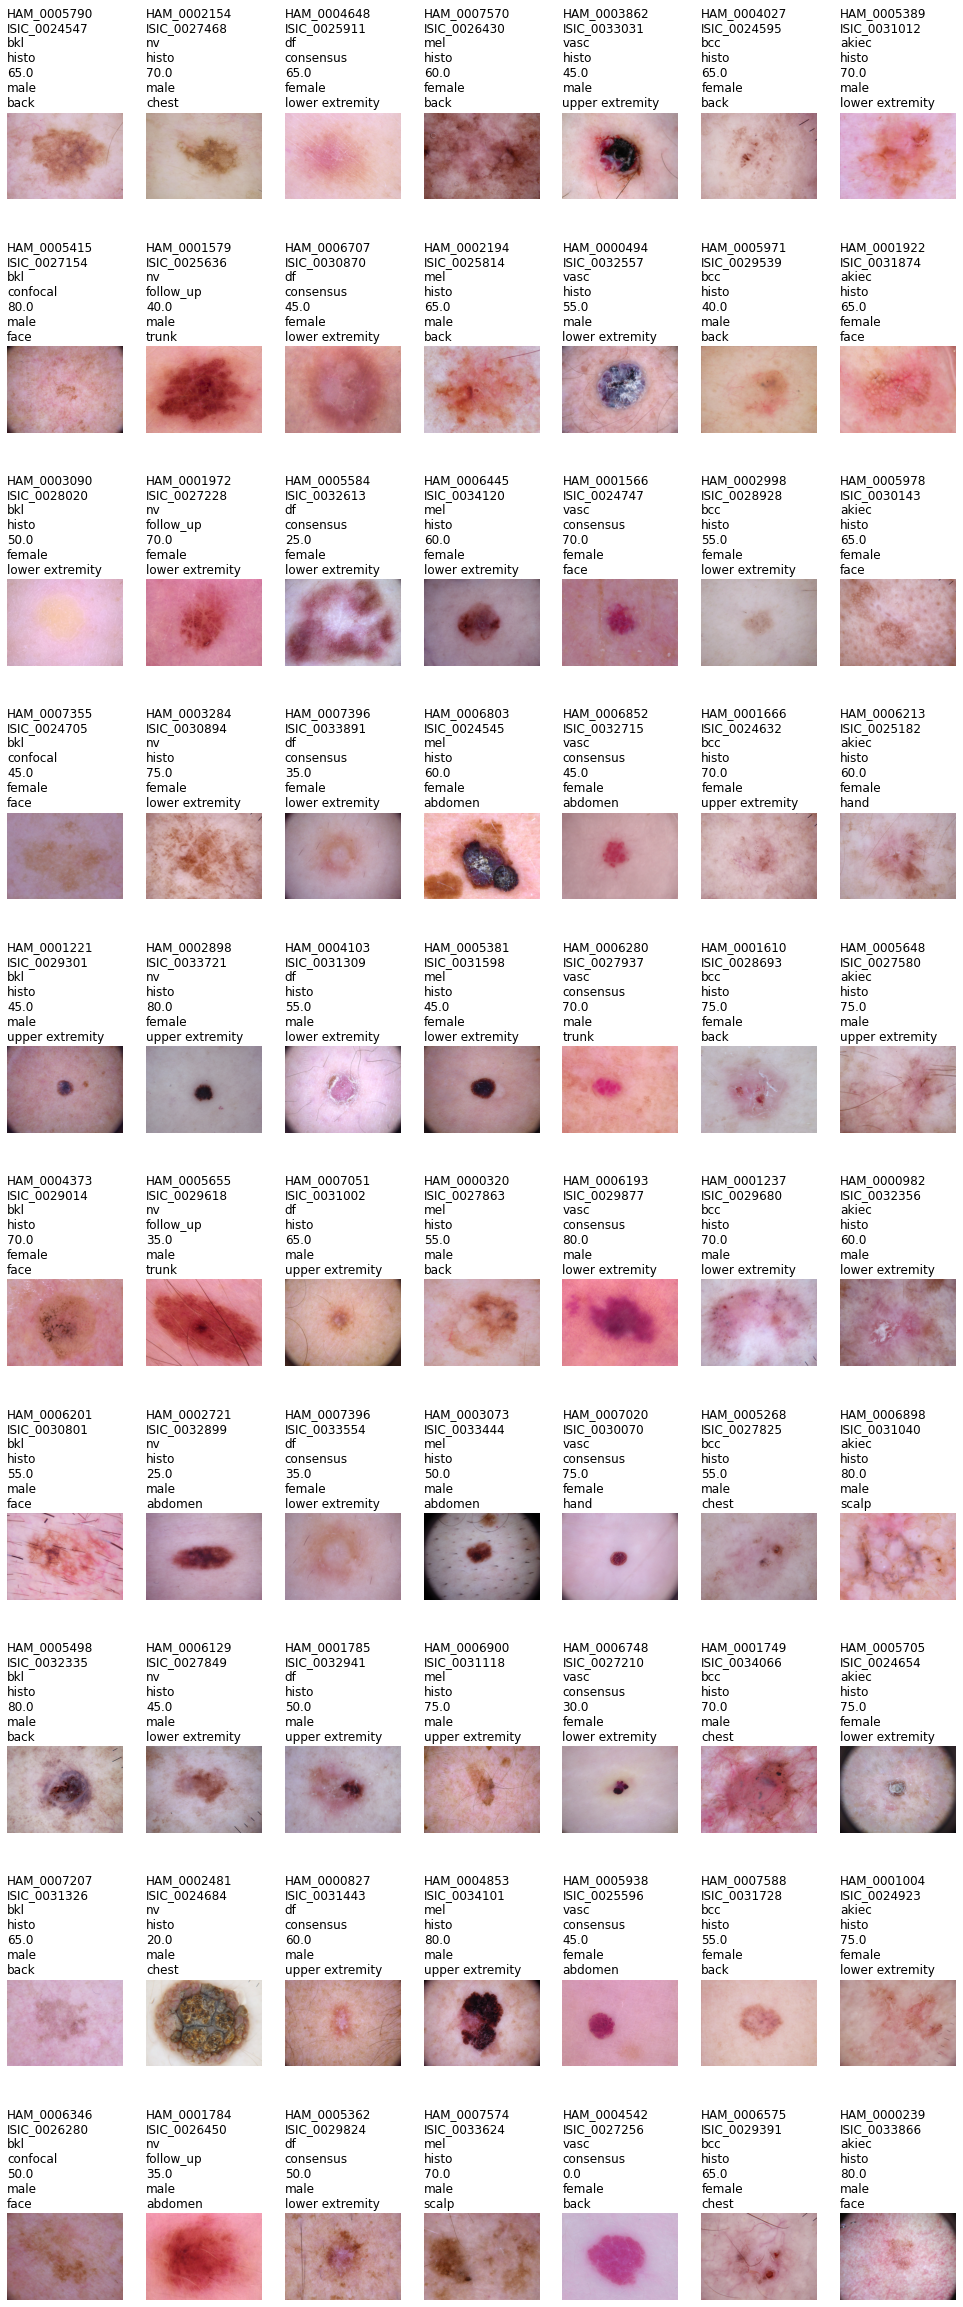

In [5]:
# Let's have a look at the randomly selected images. In the grid,
# each column will consist of images of one kind of lesion.

plt.figure(figsize=(17, 17))

for i in range(k):
    dx = lesions[i]
    for j in range(m):            
        img_id = random_images[dx][j]
        image = random_images_array[i,j]
        ax = plt.subplot(m, k, j*k + i + 1)
        plt.subplots_adjust(top=2)
        plt.imshow(image)
        if 'no_of_images' in HAM10000_metadata.columns:
            [[lesion_id, no_of_images, image_id, dx, dx_type, age, sex, localization]] = HAM10000_metadata[HAM10000_metadata['image_id'] == img_id].values
            plt.title(lesion_id + '\n' + f'multiplicity: {no_of_images}' + '\n' + image_id + '\n' + dx + '\n' + dx_type + '\n' + f'{age}' + '\n' + sex + '\n' + localization, loc='left')
        else:
            [[lesion_id, image_id, dx, dx_type, age, sex, localization]] = HAM10000_metadata[HAM10000_metadata['image_id'] == img_id].values
            plt.title(lesion_id + '\n' + image_id + '\n' + dx + '\n' + dx_type + '\n' + f'{age}' + '\n' + sex + '\n' + localization, loc='left')
        plt.axis('off')

<a id='artifacts'></a>
### Ink and other artifacts
↑↑ [Contents](#contents) | ↑ [Viewing some images alongside metadata](#viewing_images) | ↓ [Metadata info](#metadata_info)

For many lesions, the corresponding image(s) contain artifacts that are unrelated to the lesion, and which may "distract" a neural network (i.e. cause it to learn spurious features of a lesion). We've gathered some such images below for viewing.

- Some images are framed in a round frame, such that there is a black region from the oustide of this circular frame to the edges of the image. 

- Some images contain ruler marks from the dermatoscope.

- Some images contain two lesions (or at least appear to the untrained eye to contain two lesions). 

- Some images show ink marks (where a physician has encircled/marked the lesion).

- Some images are not filled by human skin etc., but include part of a wall or floor or doctor's office (the lesion is on an ear or finger or is such that placement of the dermatoscope is difficult).

Of course, many images contain hair, shaved, unshaved, and many contain no hair.

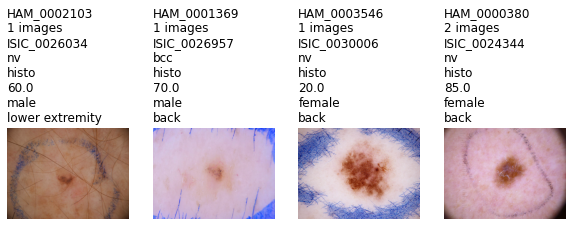

In [48]:
circle_frame = ['ISIC_0026014', 'ISIC_0026290'] 

two_lesions =  ['ISIC_0027984', 'ISIC_0024841', 'ISIC_0024998', 'ISIC_0026054']

ink1 = [ 'ISIC_0026034', 'ISIC_0026957', 'ISIC_0030006','ISIC_0024344']
ink2 = ['ISIC_0029360', 'ISIC_0027432', 'ISIC_0025978', 'ISIC_0027984']

outside = ['ISIC_0029018','ISIC_0027012','ISIC_0024893']

plt.figure(figsize=(10, 10))

row = ink1
for j in range(len(row)):            
    img_id = row[j]
    image = np.asarray(Image.open(path_to_images + img_id + img_ext))
    ax = plt.subplot(1, 4, j + 1)
    plt.imshow(image)
    [[lesion_id, no_of_images, image_id, dx, dx_type, age, sex, localization]] = HAM10000_metadata[HAM10000_metadata['image_id'] == img_id].values
    plt.title(lesion_id + '\n' + f'{no_of_images}' + ' images' + '\n' + image_id + '\n' + dx + '\n' + dx_type + '\n' + f'{age}' + '\n' + sex + '\n' + localization, loc='left')
    plt.axis('off')

<a id='metadata_info'></a>
### Metadata info
↑↑ [Contents](#contents) | ↑ [Ink and other artifacts](#artifacts) | ↓ [Multiplicities](#multiplicities)

We summarize the information in the metadata table, and determine the different possible values in each column.

In [6]:
# We now return to the 'metadata' dataframe. Let's view a summary
# of it.
HAM10000_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [7]:
# Notice that the non-null count for age is less than that of the
# other columns. This alerts us to missing values.

for col in HAM10000_metadata.columns:
    if col in HAM10000_metadata[['lesion_id', 'image_id']].columns:
        print(f'Column: {col}. Number of unique values: {HAM10000_metadata[col].unique().shape[0]}.')
    else:
        unique_values = sorted(HAM10000_metadata[col].unique())
        print(f'Column: {col}. Number of unique values: {HAM10000_metadata[col].unique().shape[0]}. Values: {unique_values}.')
    print('\n')

Column: lesion_id. Number of unique values: 7470.


Column: image_id. Number of unique values: 10015.


Column: dx. Number of unique values: 7. Values: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'].


Column: dx_type. Number of unique values: 4. Values: ['confocal', 'consensus', 'follow_up', 'histo'].


Column: age. Number of unique values: 19. Values: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, nan].


Column: sex. Number of unique values: 3. Values: ['female', 'male', 'unknown'].


Column: localization. Number of unique values: 15. Values: ['abdomen', 'acral', 'back', 'chest', 'ear', 'face', 'foot', 'genital', 'hand', 'lower extremity', 'neck', 'scalp', 'trunk', 'unknown', 'upper extremity'].




<a id='multiplicities'></a>
### Multiplicities
↑↑ [Contents](#contents) | ↑ [Metadata info](#metadata_info) | ↓ [Viewing multiple images of some lesions](#viewing_multiple)

We find the ```lesion_id```s in ```HAM10000_metadata``` that appear more than once (because there is more than one image of the lesion), and create a new ```no_of_images``` column in ```HAM10000_metadata```. We then investigate some lesions that appear with a given multiplicity.

In [8]:
# Note the   'nan' value  in  the 'age' column,  and the 'unknown'
# value in 'sex'  and 'localization' columns.  For now, let's turn
# our   attention to the     fact  that  the  number     of unique
# 'lesion_id'    values  is  less   than  the    number  of unique
# 'image_id' values: we must have multiple images for some  of the
# lesions.

# We can view the lesions for which there is more than one image.
HAM10000_metadata_duplicates = HAM10000_metadata[HAM10000_metadata.duplicated(subset='lesion_id')].sort_values('lesion_id')
HAM10000_metadata_duplicates.head()

lesion_id      image_id     dx dx_type   age     sex     localization
9188  HAM_0000000  ISIC_0025346     nv   histo  60.0    male             back
1661  HAM_0000002  ISIC_0032622    mel   histo  65.0  female  lower extremity
1662  HAM_0000002  ISIC_0034246    mel   histo  65.0  female  lower extremity
9899  HAM_0000005  ISIC_0030591  akiec   histo  75.0  female  lower extremity
9900  HAM_0000005  ISIC_0024579  akiec   histo  75.0  female  lower extremity

In [9]:
# For instance:
HAM10000_metadata[HAM10000_metadata['lesion_id'] == HAM10000_metadata_duplicates.iloc[0]['lesion_id']]

lesion_id      image_id  dx dx_type   age   sex localization
9187  HAM_0000000  ISIC_0028498  nv   histo  60.0  male         back
9188  HAM_0000000  ISIC_0025346  nv   histo  60.0  male         back

In [10]:
# We insert a 'no_of_images' column giving the number of images
# of each lesion.

# HAM10000_metadata['no_of_images'] = HAM10000_metadata.groupby(['lesion_id'])['lesion_id'].transform('count')
# HAM10000_metadata['no_of_images'] = HAM10000_metadata['lesion_id'].map(HAM10000_metadata['lesion_id'].value_counts())
HAM10000_metadata.insert(1,'no_of_images', HAM10000_metadata['lesion_id'].map(HAM10000_metadata['lesion_id'].value_counts()))
HAM10000_metadata.head()

lesion_id  no_of_images      image_id   dx dx_type   age   sex  \
0  HAM_0000118             2  ISIC_0027419  bkl   histo  80.0  male   
1  HAM_0000118             2  ISIC_0025030  bkl   histo  80.0  male   
2  HAM_0002730             2  ISIC_0026769  bkl   histo  80.0  male   
3  HAM_0002730             2  ISIC_0025661  bkl   histo  80.0  male   
4  HAM_0001466             2  ISIC_0031633  bkl   histo  75.0  male   

  localization  
0        scalp  
1        scalp  
2        scalp  
3        scalp  
4          ear

In [11]:
# There can be anywhere from 1 to 6 images of a given lesion in
# our dataset:
sorted(HAM10000_metadata['no_of_images'].unique())

[1, 2, 3, 4, 5, 6]

In [12]:
# There are four distinct lesions for which we have six images in
# the dataset.
HAM10000_metadata[HAM10000_metadata['no_of_images'] == 6]['lesion_id'].unique()

array(['HAM_0003789', 'HAM_0000835', 'HAM_0001863', 'HAM_0005263'],
      dtype=object)

<a id='viewing_multiple'></a>
### Viewing multiple images of some lesions
↑↑ [Contents](#contents) | ↑ [Multiplicities](#multiplicities) | ↓ [Checking consistency of metadata](#checking_consistency)

We can select some lesions of which we have multiple images, and view these images, to see how similar they are.

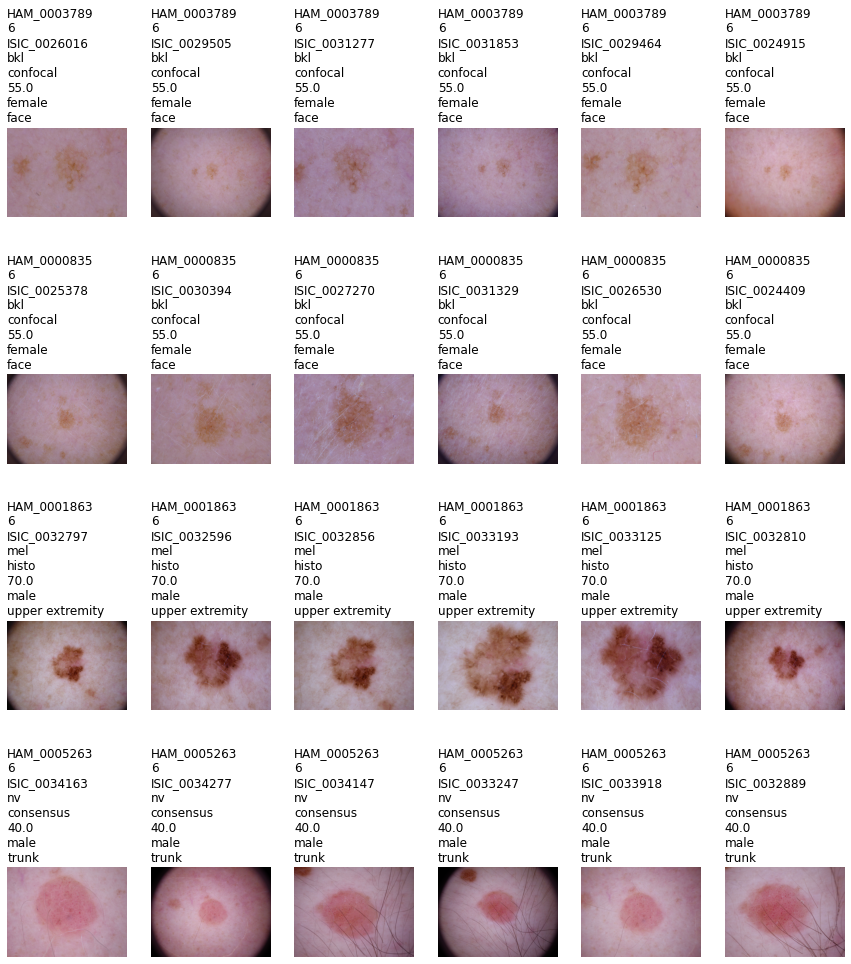

In [13]:
# Let's have  a look at the  24 images of those four lesions. Each
# of  the four rows will contain   six  images corresponding  to a
# single lesion. As we  can see, for each  given  distinct lesion,
# the six images are not merely copies of each other, but show the
# lesion under various lighting/magnification/angles/etc.

# Experiment with different m.

m = 6
lesions = HAM10000_metadata[HAM10000_metadata['no_of_images'] == m]['lesion_id'].unique()
k = len(lesions)
max_display = 5
if k > max_display:
    lesions = np.random.choice(lesions,max_display)
    k = len(lesions)

plt.figure(figsize=(15, 15))

top_adjust = [3.7, 2.1, 1.6, 1.5, 1.3, 1]

for i in range(k):
    lesion_id = lesions[i]
    images = HAM10000_metadata[HAM10000_metadata['lesion_id'] == lesion_id]['image_id'].values
    for j in range(m):            
        img_id = images[j]
        image = np.asarray(Image.open(path_to_images + img_id + img_ext))
        ax = plt.subplot(k, m, i*m + j + 1)
        plt.subplots_adjust(top=top_adjust[m - 1])
        plt.imshow(image)
        [[lesion_id, no_of_images, image_id, dx, dx_type, age, sex, localization]] = HAM10000_metadata[HAM10000_metadata['image_id'] == img_id].values
        plt.title(lesion_id + '\n' + f'{no_of_images}' + '\n' + image_id + '\n' + dx + '\n' + dx_type + '\n' + f'{age}' + '\n' + sex + '\n' + localization, loc='left')
        plt.axis('off')

<a id='checking_consistency'></a>
### Checking consistency of metadata
↑↑ [Contents](#contents) | ↑ [Viewing multiple images of some lesions](#viewing_multiple) | ↓ [Removing duplicate lesion IDs](#removing_duplicates)

Since our metadata table contains multiple records for certain lesions (those for which we have multiple images), we check for consistency, i.e., that ```dx``` etc. is constant for each ```lesion_id```, and does not change depending on ```image_id```. It turns out that ```localization``` is not consistent, although there are only two lesions (both melanoma) affected (```HAM_0000871``` and ```HAM_0001726```). Each lesion was imaged three times. The localizations for ```HAM_0000871``` were given as 'chest', 'chest', and 'trunk'. The localizations for ```HAM_0001726``` were given as 'back', 'back', and 'trunk'. The 'chest' and the 'back' are part of the 'trunk'.

In [15]:
# Some inefficient code to identify potential inconsistencies.

inconsistencies = {}
for lesion_id in HAM10000_metadata['lesion_id'].unique():
    for col in ['dx', 'dx_type', 'age', 'sex', 'localization']:      
        distinct_values = set(HAM10000_metadata[HAM10000_metadata['lesion_id'] == lesion_id][col])
        if len(distinct_values) > 1:
            if lesion_id in inconsistencies.keys():
                inconsistencies[lesion_id].append(col)
            else:
                inconsistencies[lesion_id] = [col]

In [16]:
display(HAM10000_metadata[HAM10000_metadata['lesion_id'].isin(inconsistencies.keys())].sort_values(by='lesion_id'))

lesion_id  no_of_images      image_id   dx    dx_type   age      sex  \
1886  HAM_0000169             2  ISIC_0032960  mel      histo   NaN     male   
1887  HAM_0000169             2  ISIC_0033708  mel      histo   NaN     male   
9386  HAM_0000698             2  ISIC_0031668   nv  consensus   NaN     male   
9387  HAM_0000698             2  ISIC_0027431   nv  consensus   NaN     male   
1211  HAM_0000871             3  ISIC_0025964  mel      histo  40.0   female   
1212  HAM_0000871             3  ISIC_0030623  mel      histo  40.0   female   
2014  HAM_0000871             3  ISIC_0026506  mel      histo  40.0   female   
1247  HAM_0001726             3  ISIC_0029281  mel      histo  35.0   female   
1248  HAM_0001726             3  ISIC_0024367  mel      histo  35.0   female   
2008  HAM_0001726             3  ISIC_0024700  mel      histo  35.0   female   
7961  HAM_0002417             2  ISIC_0033442   nv      histo   NaN     male   
7962  HAM_0002417             2  ISIC_0032943   nv      histo   NaN     male   
977   HAM_0006074             2  ISIC_0034252  bkl  consensus   NaN  unknown   
978   HAM_0006074             2  ISIC_0033829  bkl  consensus   NaN  unknown   
7558  HAM_0007278             2  ISIC_0025009   nv      histo   NaN   female   
8555  HAM_0007278             2  ISIC_0032300   nv      histo   NaN   female   

         localization  
1886             face  
1887             face  
9386             foot  
9387             foot  
1211            chest  
1212            chest  
2014            trunk  
1247             back  
1248             back  
2008            trunk  
7961  upper extremity  
7962  upper extremity  
977           unknown  
978           unknown  
7558            chest  
8555            chest

We can ignore the results we found that relate to ```age```: these were only detected because no two occurrences of a null float are considered the same.

In [23]:
display(HAM10000_metadata[(HAM10000_metadata['lesion_id'].isin(inconsistencies.keys())) & (HAM10000_metadata['age'].notna())].sort_values(by='lesion_id'))

lesion_id  no_of_images      image_id   dx dx_type   age     sex  \
1211  HAM_0000871             3  ISIC_0025964  mel   histo  40.0  female   
1212  HAM_0000871             3  ISIC_0030623  mel   histo  40.0  female   
2014  HAM_0000871             3  ISIC_0026506  mel   histo  40.0  female   
1247  HAM_0001726             3  ISIC_0029281  mel   histo  35.0  female   
1248  HAM_0001726             3  ISIC_0024367  mel   histo  35.0  female   
2008  HAM_0001726             3  ISIC_0024700  mel   histo  35.0  female   

     localization  
1211        chest  
1212        chest  
2014        trunk  
1247         back  
1248         back  
2008        trunk

Let's take a look at these two melanoma. The third image of each lesion appears to be done under different lighting. Together with the fact that the third image of each lesion was recorded differently, this makes one wonder if the lesions were imaged in separate appointments. Not that it is of any consequence to us.

In [18]:
inconsistencies = {k : v for k, v in inconsistencies.items() if 'age' not in v}

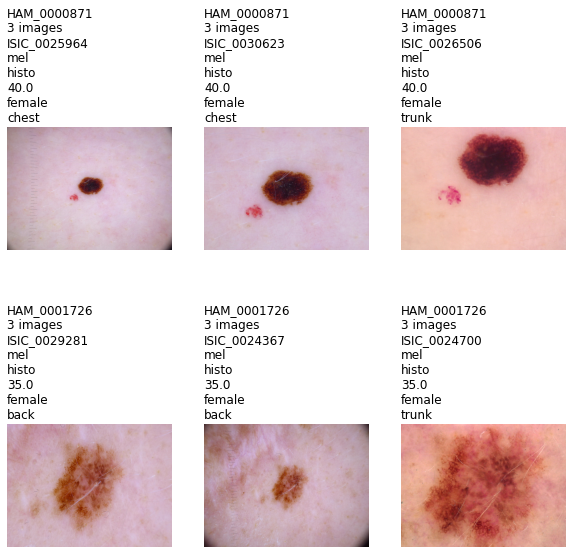

In [19]:
lesions = list(inconsistencies.keys())
k = len(lesions)
images = {lesion_id : HAM10000_metadata[HAM10000_metadata['lesion_id'] == lesion_id]['image_id'].values for lesion_id in lesions}
m = max(v.shape[0] for v in images.values())

plt.figure(figsize=(10, 10))

for i in range(k):
    lesion_id = lesions[i]
    row = images[lesion_id]
    for j in range(len(row)):            
        img_id = row[j]
        image = np.asarray(Image.open(path_to_images + img_id + img_ext))
        ax = plt.subplot(k, m, i*m + j + 1)
        plt.imshow(image)
        [[lesion_id, no_of_images, image_id, dx, dx_type, age, sex, localization]] = HAM10000_metadata[HAM10000_metadata['image_id'] == img_id].values
        plt.title(lesion_id + '\n' + f'{no_of_images}' + ' images' + '\n' + image_id + '\n' + dx + '\n' + dx_type + '\n' + f'{age}' + '\n' + sex + '\n' + localization, loc='left')
        plt.axis('off')

<a id='removing_duplicates'></a>
### Removing duplicate lesion IDs
↑↑ [Contents](#contents) | ↑ [Checking consistency of metadata](#checking_consistency) | ↓ [Statistics](#statistics)

We create a new table called ```HAM10000_metadata_unique``` that contains just one row for each distinct ```lesion_id```, by removing from ```HAM10000_metadata``` all but the first occurrence of a row with a given ```lesion_id```.

In [15]:
# We create a dataframe consisting of precisely one 'image_id' for
# each lesion.  For each lesion,  we keep the row corresponding to
# the first occurrence of 'lesion_id', and drop the rest.
HAM10000_metadata_unique = HAM10000_metadata.drop_duplicates(subset=['lesion_id'], keep='first')
HAM10000_metadata_unique.head()

lesion_id  no_of_images      image_id   dx dx_type   age     sex  \
0  HAM_0000118             2  ISIC_0027419  bkl   histo  80.0    male   
2  HAM_0002730             2  ISIC_0026769  bkl   histo  80.0    male   
4  HAM_0001466             2  ISIC_0031633  bkl   histo  75.0    male   
6  HAM_0002761             2  ISIC_0029176  bkl   histo  60.0    male   
8  HAM_0005132             2  ISIC_0025837  bkl   histo  70.0  female   

  localization  
0        scalp  
2        scalp  
4          ear  
6         face  
8         back

<a id='statistics'></a>
### Statistics
↑↑ [Contents](#contents) | ↑ [Removing duplicate lesion IDs](#removing_duplicates) | ↓ [Conditional probabilities (probability of diagnosis given feature)](#conditional_probabilities)

We look at distributions of diagnoses, etc. in either or both of the ```HAM10000_metadata``` and ```HAM10000_metadata_unique``` tables. In some of the cells that follow, we include a boolean ```include_duplicates```, which is set to ```False``` by default, meaning that we consider ```HAM10000_metadata_unique```. If we instead wish to consider ```HAM10000_metadata```, we simply need to toggle ```include_duplicates``` to ```True```.

In [16]:
# Let's   investigage the   distribution    of  diagnoses  ('dx'),
# diagnosis type ('dx_type'), 'age', 'sex', and 'localization'. We
# may also be interested in such questions as: What  proportion of
# melanoma lesions comes from  a (fe)male patient? What proportion
# melanocytic  nevi come from  a 40 year old patient? And so on...

def HAM10000_freq(*args, include_duplicates=False):
    '''
    Inputs: *args (string(s)), include_duplicates (boolean)

    Either args = (col1) or args = (col1, value, col2), where col1
    is a  column name ('dx', 'dx_type', etc.), value is a possible
    value within the corresponding   column (e.g.  'mel', 'histo',
    etc.),  and col2 is another  column  name (e.g.  'age', 'sex',
    'localization').

    include_duplicates is False by default. If False, we consider
    the dataframe  in which there  is  exactly one image  of each
    lesion. If True, we consider the dataframe in which there are
    multiple images of some lesions.

    Returns: output, a dataframe.

    In case  args = (col1),  output gives the frequencies (absolute
    and  relative) for all of the   different  values found  in the
    relevant dataframe under column  col1.  In case  args  = (col1,
    value, col2), we restrict  the relevant dataframe to rows where
    only value appears  under column col1, and in _that_ restricted
    dataframe, output gives the frequencies (absolute and relative)
    of all of the different values under col2.
    '''
    if include_duplicates:
        df = HAM10000_metadata
    else:
        df = HAM10000_metadata_unique
    if len(args) == 1:
        col = df[args[0]]
        output = pd.concat([col.value_counts(dropna=False), col.value_counts(normalize=True,dropna=False).mul(100).round(2)],axis=1, keys=['freq', '%'])
        output.index.names = [args[0]]
        return output 
    else:
        col1, value, col2 = args[0], args[1], args[2]
        col = df[df[col1] == value][col2]
        output = pd.concat([col.value_counts(dropna=False), col.value_counts(normalize=True,dropna=False).mul(100).round(2)],axis=1, keys=['freq', '%'])
        output.index.names = [col2]
        return output

In [17]:
# We see  that more than 25% of lesions in our dataset were imaged
# more than once. In what follows,  we will look at frequencies of
# distinct lesions, as well as frequencies of images (i.e. lesions
# counted with multiplicity).

HAM10000_freq('no_of_images', include_duplicates=False).T

no_of_images        1        2       3      4     5     6
freq          5514.00  1423.00  490.00  34.00  5.00  4.00
%               73.82    19.05    6.56   0.46  0.07  0.05

In [19]:
# Let's get the distributions for 'dx', 'dx_type', etc., in one
# fell swoop.

# Set include_duplicates  to True  to  count each distinct lesion
# with multiplicity equal to the number of images there are of it
# our dataset (i.e. count images rather than distinct lesions).
include_duplicates = False

if include_duplicates:
    for column_name in ['dx', 'dx_type', 'age', 'sex', 'localization']:
        print(column_name + ' (images)')
        display(HAM10000_freq(column_name, include_duplicates=True).T)
else:
    for column_name in ['dx', 'dx_type', 'age', 'sex', 'localization']:
        print(column_name + ' (distinct lesions)')
        display(HAM10000_freq(column_name, include_duplicates=False).T) 

dx (distinct lesions)


dx         nv     bkl     mel     bcc   akiec   vasc     df
freq  5403.00  727.00  614.00  327.00  228.00  98.00  73.00
%       72.33    9.73    8.22    4.38    3.05   1.31   0.98

dx_type (distinct lesions)


dx_type  follow_up   histo  consensus  confocal
freq       3704.00  3085.0     647.00     34.00
%            49.59    41.3       8.66      0.46

age (distinct lesions)


age      45.0    50.0    40.0    55.0    60.0    35.0    65.0    70.0    75.0  \
freq  1080.00  987.00  787.00  780.00  600.00  570.00  515.00  503.00  430.00   
%       14.46   13.21   10.54   10.44    8.03    7.63    6.89    6.73    5.76   

age     30.0    80.0   85.0    25.0    20.0  NaN    5.0   15.0   10.0   0.0   
freq  312.00  278.00  179.0  161.00  101.00  52.0  47.00  45.0  22.00  21.00  
%       4.18    3.72    2.4    2.16    1.35   0.7   0.63   0.6   0.29   0.28

sex (distinct lesions)


sex      male   female  unknown
freq  4001.00  3419.00    50.00
%       53.56    45.77     0.67

localization (distinct lesions)


localization  lower extremity     back    trunk  abdomen  upper extremity  \
freq                   1584.0  1534.00  1269.00    822.0           776.00   
%                        21.2    20.54    16.99     11.0            10.39   

localization    face   chest    foot  unknown    neck  scalp   hand  genital  \
freq          470.00  240.00  228.00   203.00  119.00  78.00  64.00     45.0   
%               6.29    3.21    3.05     2.72    1.59   1.04   0.86      0.6   

localization    ear  acral  
freq          35.00   3.00  
%              0.47   0.04

<a id='conditional_probabilities'></a>
### Conditional probabilities (probability of diagnosis given feature)
↑↑ [Contents](#contents) | ↑ [Statistics](#statistics) | ↓ [Plots](#plots)

We will use the ```pandas.crosstab``` function to obtain various conditional probabilities. For instance, by ```Prob(mel | male)``` below we mean the ratio of the number of entries in ```HAM10000_metadata_unique``` (or ```HAM10000_metadata``` in case ```include_duplicates = True```) with ```dx = mel``` and ```sex = male``` to the number of entries in the table with ```sex = male```.

In [20]:
# And now the probability that a lesion belongs to a male/female,
# given that it is melanoma.

# Set include_duplicates  to True  to  count each distinct lesion
# with multiplicity equal to the number of images there are of it
# our dataset (i.e. count images rather than distinct lesions).
include_duplicates = False

if not include_duplicates:
    print('Melanoma (distinct lesions).\n')
else:
    print('Melanoma (images).\n')
    
print('Prob(sex | mel)')
display(HAM10000_freq('dx', 'mel','sex',include_duplicates).T)

Melanoma (distinct lesions).

Prob(sex | mel)


sex     male  female
freq  371.00  243.00
%      60.42   39.58

In [21]:
# What about the probability that a lesion is melanoma, given that
# it comes from a male/female?

# Set include_duplicates  to True  to  count each distinct lesion
# with multiplicity equal to the number of images there are of it
# our dataset (i.e. count images rather than distinct lesions).
include_duplicates = False

if not include_duplicates:
    df = HAM10000_metadata_unique
    print('Diagnosis (distinct lesions).\n')
    print('Caveat: the number for males/females is not necessarily the number of _distinct_ males/females. For instance, we have 2,584 distinct nevi that come from a male and 2,778 distinct nevi that come from a female, but it is possible that two or more distinct nevi come from the same male/female. We\'re seeing the number of distinct lesions of a given type that come from a (fe)male patient, and the probability that a lesion comes from a male patient given that it is of a certain type.\n')
else:
    df = HAM10000_metadata
    print('Diagnosis (images).\n')

# We could use 
# display(HAM10000_freq('sex', 'male','dx',include_duplicates).T)
# and 
# display(HAM10000_freq('sex', 'female','dx',include_duplicates).T)
# but there is a better way to do this kind of thing...

A = 'dx'
B = 'sex'
AgivenBabs = pd.crosstab(df[A], df[B])
AgivenB = pd.crosstab(df[A],df[B],normalize='columns').mul(100).round(2)

print(f'#dx given sex')
display(AgivenBabs)

print(f'Prob(dx | sex) (displayed as a percentage)')
display(AgivenB)

Diagnosis (distinct lesions).

Caveat: the number for males/females is not necessarily the number of _distinct_ males/females. For instance, we have 2,584 distinct nevi that come from a male and 2,778 distinct nevi that come from a female, but it is possible that two or more distinct nevi come from the same male/female. We're seeing the number of distinct lesions of a given type that come from a (fe)male patient, and the probability that a lesion comes from a male patient given that it is of a certain type.

#dx given sex


sex    female  male  unknown
dx                          
akiec      80   148        0
bcc       122   205        0
bkl       304   414        9
df         38    35        0
mel       243   371        0
nv       2584  2778       41
vasc       48    50        0

Prob(dx | sex) (displayed as a percentage)


sex    female   male  unknown
dx                           
akiec    2.34   3.70      0.0
bcc      3.57   5.12      0.0
bkl      8.89  10.35     18.0
df       1.11   0.87      0.0
mel      7.11   9.27      0.0
nv      75.58  69.43     82.0
vasc     1.40   1.25      0.0

In [25]:
# Let's look at all the conditional probabilities...

# Set include_duplicates  to True  to  count each distinct lesion
# with multiplicity equal to the number of images there are of it
# our dataset (i.e. count images rather than distinct lesions).
include_duplicates = False

if not include_duplicates:
    df = HAM10000_metadata_unique
    print(f'CONSIDERING ALL {df.shape[0]} *DISTINCT* LESIONS...\n')
else:
    df = HAM10000_metadata
    print(f'CONSIDERING ALL {df.shape[0]} IMAGES (LESIONS COUNTED WITH MULTIPLICITY)...\n')

diagnoses = df['dx'].unique()
n = len(diagnoses)
sex = ['male + female', 'male', 'female']
m = len(sex)
features = ['sex', 'age', 'dx_type', 'localization']
k = len(features)

for h in range(n):
    dx = diagnoses[h]
    for i in range(k):
        for j in range(m):
            feature, gender = features[i], sex[j] 
            if feature == 'sex' and (gender != 'male + female'):
                pass
            else:
                if gender == 'male + female': # j == 2
                    data = df
                else:
                    data = df[df['sex'] == gender]
                A = 'dx'
                B = feature
                AgivenBabs = pd.crosstab(data[A], data[B])
                AgivenB = pd.crosstab(data[A], data[B], normalize='columns').mul(100).round(2)
                BgivenAabs = pd.crosstab(data[B], data[A])
                BgivenA = pd.crosstab(data[B], data[A], normalize='columns').mul(100).round(2)
                print(f'#{A} given {B} \n({gender})')
                display(AgivenBabs)
                print('\n')
                print(f'Prob({A} | {B}) \n{gender} (displayed as a percentage)')
                display(AgivenB)
                print('\n')
                print(f'#{B} given {A} \n({gender})')
                display(BgivenAabs)
                print('\n')
                print(f'Prob({B} | {A}) \n{gender} (displayed as a percentage)')
                display(BgivenA)
                print('\n')

CONSIDERING ALL 7470 *DISTINCT* LESIONS...

#dx given sex 
(male + female)


sex    female  male  unknown
dx                          
akiec      80   148        0
bcc       122   205        0
bkl       304   414        9
df         38    35        0
mel       243   371        0
nv       2584  2778       41
vasc       48    50        0



Prob(dx | sex) 
male + female (displayed as a percentage)


sex    female   male  unknown
dx                           
akiec    2.34   3.70      0.0
bcc      3.57   5.12      0.0
bkl      8.89  10.35     18.0
df       1.11   0.87      0.0
mel      7.11   9.27      0.0
nv      75.58  69.43     82.0
vasc     1.40   1.25      0.0



#sex given dx 
(male + female)


dx       akiec  bcc  bkl  df  mel    nv  vasc
sex                                          
female      80  122  304  38  243  2584    48
male       148  205  414  35  371  2778    50
unknown      0    0    9   0    0    41     0



Prob(sex | dx) 
male + female (displayed as a percentage)


dx       akiec    bcc    bkl     df    mel     nv   vasc
sex                                                     
female   35.09  37.31  41.82  52.05  39.58  47.83  48.98
male     64.91  62.69  56.95  47.95  60.42  51.42  51.02
unknown   0.00   0.00   1.24   0.00   0.00   0.76   0.00



#dx given age 
(male + female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     6     7    13    18   
bcc       0     0     0     0     1     1     2     2    15    17    18    18   
bkl       3     1     0     0     0     0     3    18    25    39    63    58   
df        0     0     0     0     0     1     3     8     6     8    10     9   
mel       0     1     0     0     4     7    16    19    27    39    49    72   
nv       16    43    21    43    94   150   283   517   705   959   823   591   
vasc      2     2     1     2     2     2     4     6     3    11    11    14   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    42    27    39    30    26    19  
bcc      25    47    52    47    49    33  
bkl      82    71   128   103    69    55  
df        8    11     3     5     1     0  
mel      65    75    89    59    48    43  
nv      371   281   183   178    77    26  
vasc      7     3     9     8     8     3



Prob(dx | age) 
male + female (displayed as a percentage)


age     0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                            
akiec   0.00   0.00   0.00   0.00   0.00   0.00   0.32   0.00   0.76   0.65   
bcc     0.00   0.00   0.00   0.00   0.99   0.62   0.64   0.35   1.91   1.57   
bkl    14.29   2.13   0.00   0.00   0.00   0.00   0.96   3.16   3.18   3.61   
df      0.00   0.00   0.00   0.00   0.00   0.62   0.96   1.40   0.76   0.74   
mel     0.00   2.13   0.00   0.00   3.96   4.35   5.13   3.33   3.43   3.61   
nv     76.19  91.49  95.45  95.56  93.07  93.17  90.71  90.70  89.58  88.80   
vasc    9.52   4.26   4.55   4.44   1.98   1.24   1.28   1.05   0.38   1.02   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   1.32   2.31   7.00   5.24   7.75   6.98   9.35  10.61  
bcc     1.82   2.31   4.17   9.13  10.34  10.93  17.63  18.44  
bkl     6.38   7.44  13.67  13.79  25.45  23.95  24.82  30.73  
df      1.01   1.15   1.33   2.14   0.60   1.16   0.36   0.00  
mel     4.96   9.23  10.83  14.56  17.69  13.72  17.27  24.02  
nv     83.38  75.77  61.83  54.56  36.38  41.40  27.70  14.53  
vasc    1.11   1.79   1.17   0.58   1.79   1.86   2.88   1.68



#age given dx 
(male + female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    3   0    0   16     2
5.0       0    0    1   0    1   43     2
10.0      0    0    0   0    0   21     1
15.0      0    0    0   0    0   43     2
20.0      0    1    0   0    4   94     2
25.0      0    1    0   1    7  150     2
30.0      1    2    3   3   16  283     4
35.0      0    2   18   8   19  517     6
40.0      6   15   25   6   27  705     3
45.0      7   17   39   8   39  959    11
50.0     13   18   63  10   49  823    11
55.0     18   18   58   9   72  591    14
60.0     42   25   82   8   65  371     7
65.0     27   47   71  11   75  281     3
70.0     39   52  128   3   89  183     9
75.0     30   47  103   5   59  178     8
80.0     26   49   69   1   48   77     8
85.0     19   33   55   0   43   26     3



Prob(age | dx) 
male + female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.42   0.00   0.00   0.30   2.04
5.0    0.00   0.00   0.14   0.00   0.16   0.80   2.04
10.0   0.00   0.00   0.00   0.00   0.00   0.39   1.02
15.0   0.00   0.00   0.00   0.00   0.00   0.80   2.04
20.0   0.00   0.31   0.00   0.00   0.65   1.75   2.04
25.0   0.00   0.31   0.00   1.37   1.14   2.80   2.04
30.0   0.44   0.61   0.42   4.11   2.61   5.28   4.08
35.0   0.00   0.61   2.51  10.96   3.10   9.64   6.12
40.0   2.63   4.59   3.48   8.22   4.40  13.15   3.06
45.0   3.07   5.20   5.43  10.96   6.36  17.89  11.22
50.0   5.70   5.50   8.77  13.70   7.99  15.35  11.22
55.0   7.89   5.50   8.08  12.33  11.75  11.02  14.29
60.0  18.42   7.65  11.42  10.96  10.60   6.92   7.14
65.0  11.84  14.37   9.89  15.07  12.23   5.24   3.06
70.0  17.11  15.90  17.83   4.11  14.52   3.41   9.18
75.0  13.16  14.37  14.35   6.85   9.62   3.32   8.16
80.0  11.40  14.98   9.61   1.37   7.83   1.44   8.16
85.0   8.33  10.09   7.66   0.00   7.01   0.48   3.06



#dx given age 
(male)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     3     7    10     8   
bcc       0     0     0     0     0     1     0     2     5    11    10    12   
bkl       1     1     0     0     0     0     1     8    15    21    37    36   
df        0     0     0     0     0     0     3     0     3     3     5     4   
mel       0     1     0     0     2     2     5     6     8    19    28    47   
nv       11    29     6    14    42    67   133   241   333   433   387   323   
vasc      0     2     1     2     2     0     1     2     2     2     6     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    27    16    24    22    15    15  
bcc      15    24    36    32    36    21  
bkl      34    43    66    64    53    34  
df        5     5     3     3     1     0  
mel      40    51    59    41    33    28  
nv      241   170   134   122    70    20  
vasc      3     0     4     7     7     2



Prob(dx | age) 
male (displayed as a percentage)


age     0.0    5.0    10.0  15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.00   0.00   0.00   0.0   0.00   0.00   0.69   0.00   0.81   1.41   
bcc     0.00   0.00   0.00   0.0   0.00   1.43   0.00   0.77   1.36   2.22   
bkl     8.33   3.03   0.00   0.0   0.00   0.00   0.69   3.09   4.07   4.23   
df      0.00   0.00   0.00   0.0   0.00   0.00   2.08   0.00   0.81   0.60   
mel     0.00   3.03   0.00   0.0   4.35   2.86   3.47   2.32   2.17   3.83   
nv     91.67  87.88  85.71  87.5  91.30  95.71  92.36  93.05  90.24  87.30   
vasc    0.00   6.06  14.29  12.5   4.35   0.00   0.69   0.77   0.54   0.40   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   2.07   1.83   7.40   5.18   7.36   7.56   6.98  12.50  
bcc     2.07   2.75   4.11   7.77  11.04  11.00  16.74  17.50  
bkl     7.66   8.24   9.32  13.92  20.25  21.99  24.65  28.33  
df      1.04   0.92   1.37   1.62   0.92   1.03   0.47   0.00  
mel     5.80  10.76  10.96  16.50  18.10  14.09  15.35  23.33  
nv     80.12  73.91  66.03  55.02  41.10  41.92  32.56  16.67  
vasc    1.24   1.60   0.82   0.00   1.23   2.41   3.26   1.67



#age given dx 
(male)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    1   0    0   11     0
5.0       0    0    1   0    1   29     2
10.0      0    0    0   0    0    6     1
15.0      0    0    0   0    0   14     2
20.0      0    0    0   0    2   42     2
25.0      0    1    0   0    2   67     0
30.0      1    0    1   3    5  133     1
35.0      0    2    8   0    6  241     2
40.0      3    5   15   3    8  333     2
45.0      7   11   21   3   19  433     2
50.0     10   10   37   5   28  387     6
55.0      8   12   36   4   47  323     7
60.0     27   15   34   5   40  241     3
65.0     16   24   43   5   51  170     0
70.0     24   36   66   3   59  134     4
75.0     22   32   64   3   41  122     7
80.0     15   36   53   1   33   70     7
85.0     15   21   34   0   28   20     2



Prob(age | dx) 
male (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv  vasc
age                                                 
0.0    0.00   0.00   0.24   0.00   0.00   0.40   0.0
5.0    0.00   0.00   0.24   0.00   0.27   1.04   4.0
10.0   0.00   0.00   0.00   0.00   0.00   0.22   2.0
15.0   0.00   0.00   0.00   0.00   0.00   0.50   4.0
20.0   0.00   0.00   0.00   0.00   0.54   1.51   4.0
25.0   0.00   0.49   0.00   0.00   0.54   2.41   0.0
30.0   0.68   0.00   0.24   8.57   1.35   4.79   2.0
35.0   0.00   0.98   1.93   0.00   1.62   8.68   4.0
40.0   2.03   2.44   3.62   8.57   2.16  12.00   4.0
45.0   4.73   5.37   5.07   8.57   5.14  15.60   4.0
50.0   6.76   4.88   8.94  14.29   7.57  13.94  12.0
55.0   5.41   5.85   8.70  11.43  12.70  11.64  14.0
60.0  18.24   7.32   8.21  14.29  10.81   8.68   6.0
65.0  10.81  11.71  10.39  14.29  13.78   6.12   0.0
70.0  16.22  17.56  15.94   8.57  15.95   4.83   8.0
75.0  14.86  15.61  15.46   8.57  11.08   4.39  14.0
80.0  10.14  17.56  12.80   2.86   8.92   2.52  14.0
85.0  10.14  10.24   8.21   0.00   7.57   0.72   4.0



#dx given age 
(female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     0     0     3     0     3    10   
bcc       0     0     0     0     1     0     2     0    10     6     8     6   
bkl       2     0     0     0     0     0     2    10    10    18    26    22   
df        0     0     0     0     0     1     0     8     3     5     5     5   
mel       0     0     0     0     2     5    11    13    19    20    21    25   
nv        4    14    15    29    52    83   150   275   372   525   436   268   
vasc      2     0     0     0     0     2     3     4     1     9     5     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    15    11    15     8    11     4  
bcc      10    23    16    15    13    12  
bkl      48    28    62    39    16    21  
df        3     6     0     2     0     0  
mel      25    24    30    18    15    15  
nv      129   111    49    56     7     6  
vasc      4     3     5     1     1     1



Prob(dx | age) 
female (displayed as a percentage)


age    0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.0    0.0    0.0    0.0   0.00   0.00   0.00   0.00   0.72   0.00   
bcc     0.0    0.0    0.0    0.0   1.82   0.00   1.19   0.00   2.39   1.03   
bkl    25.0    0.0    0.0    0.0   0.00   0.00   1.19   3.23   2.39   3.09   
df      0.0    0.0    0.0    0.0   0.00   1.10   0.00   2.58   0.72   0.86   
mel     0.0    0.0    0.0    0.0   3.64   5.49   6.55   4.19   4.55   3.43   
nv     50.0  100.0  100.0  100.0  94.55  91.21  89.29  88.71  89.00  90.05   
vasc   25.0    0.0    0.0    0.0   0.00   2.20   1.79   1.29   0.24   1.54   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   0.60   2.92   6.41   5.34   8.47   5.76  17.46   6.78  
bcc     1.59   1.75   4.27  11.17   9.04  10.79  20.63  20.34  
bkl     5.16   6.41  20.51  13.59  35.03  28.06  25.40  35.59  
df      0.99   1.46   1.28   2.91   0.00   1.44   0.00   0.00  
mel     4.17   7.29  10.68  11.65  16.95  12.95  23.81  25.42  
nv     86.51  78.13  55.13  53.88  27.68  40.29  11.11  10.17  
vasc    0.99   2.04   1.71   1.46   2.82   0.72   1.59   1.69



#age given dx 
(female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    2   0    0    4     2
5.0       0    0    0   0    0   14     0
10.0      0    0    0   0    0   15     0
15.0      0    0    0   0    0   29     0
20.0      0    1    0   0    2   52     0
25.0      0    0    0   1    5   83     2
30.0      0    2    2   0   11  150     3
35.0      0    0   10   8   13  275     4
40.0      3   10   10   3   19  372     1
45.0      0    6   18   5   20  525     9
50.0      3    8   26   5   21  436     5
55.0     10    6   22   5   25  268     7
60.0     15   10   48   3   25  129     4
65.0     11   23   28   6   24  111     3
70.0     15   16   62   0   30   49     5
75.0      8   15   39   2   18   56     1
80.0     11   13   16   0   15    7     1
85.0      4   12   21   0   15    6     1



Prob(age | dx) 
female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.66   0.00   0.00   0.15   4.17
5.0    0.00   0.00   0.00   0.00   0.00   0.54   0.00
10.0   0.00   0.00   0.00   0.00   0.00   0.58   0.00
15.0   0.00   0.00   0.00   0.00   0.00   1.12   0.00
20.0   0.00   0.82   0.00   0.00   0.82   2.01   0.00
25.0   0.00   0.00   0.00   2.63   2.06   3.22   4.17
30.0   0.00   1.64   0.66   0.00   4.53   5.81   6.25
35.0   0.00   0.00   3.29  21.05   5.35  10.65   8.33
40.0   3.75   8.20   3.29   7.89   7.82  14.41   2.08
45.0   0.00   4.92   5.92  13.16   8.23  20.34  18.75
50.0   3.75   6.56   8.55  13.16   8.64  16.89  10.42
55.0  12.50   4.92   7.24  13.16  10.29  10.38  14.58
60.0  18.75   8.20  15.79   7.89  10.29   5.00   8.33
65.0  13.75  18.85   9.21  15.79   9.88   4.30   6.25
70.0  18.75  13.11  20.39   0.00  12.35   1.90  10.42
75.0  10.00  12.30  12.83   5.26   7.41   2.17   2.08
80.0  13.75  10.66   5.26   0.00   6.17   0.27   2.08
85.0   5.00   9.84   6.91   0.00   6.17   0.23   2.08



#dx given dx_type 
(male + female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    228
bcc             0          0          0    327
bkl            34        206          0    487
df              0         44          0     29
mel             0          0          0    614
nv              0        332       3704   1367
vasc            0         65          0     33



Prob(dx | dx_type) 
male + female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   7.39
bcc           0.0       0.00        0.0  10.60
bkl         100.0      31.84        0.0  15.79
df            0.0       6.80        0.0   0.94
mel           0.0       0.00        0.0  19.90
nv            0.0      51.31      100.0  44.31
vasc          0.0      10.05        0.0   1.07



#dx_type given dx 
(male + female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   34   0    0     0     0
consensus      0    0  206  44    0   332    65
follow_up      0    0    0   0    0  3704     0
histo        228  327  487  29  614  1367    33



Prob(dx_type | dx) 
male + female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   4.68   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.34  60.27    0.0   6.14  66.33
follow_up    0.0    0.0   0.00   0.00    0.0  68.55   0.00
histo      100.0  100.0  66.99  39.73  100.0  25.30  33.67



#dx given dx_type 
(male)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    148
bcc             0          0          0    205
bkl            15        109          0    290
df              0         15          0     20
mel             0          0          0    371
nv              0        155       1922    701
vasc            0         33          0     17



Prob(dx | dx_type) 
male (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   8.45
bcc           0.0       0.00        0.0  11.70
bkl         100.0      34.94        0.0  16.55
df            0.0       4.81        0.0   1.14
mel           0.0       0.00        0.0  21.18
nv            0.0      49.68      100.0  40.01
vasc          0.0      10.58        0.0   0.97



#dx_type given dx 
(male)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   15   0    0     0     0
consensus      0    0  109  15    0   155    33
follow_up      0    0    0   0    0  1922     0
histo        148  205  290  20  371   701    17



Prob(dx_type | dx) 
male (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv  vasc
dx_type                                                  
confocal     0.0    0.0   3.62   0.00    0.0   0.00   0.0
consensus    0.0    0.0  26.33  42.86    0.0   5.58  66.0
follow_up    0.0    0.0   0.00   0.00    0.0  69.19   0.0
histo      100.0  100.0  70.05  57.14  100.0  25.23  34.0



#dx given dx_type 
(female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0     80
bcc             0          0          0    122
bkl            19         88          0    197
df              0         29          0      9
mel             0          0          0    243
nv              0        140       1782    662
vasc            0         32          0     16



Prob(dx | dx_type) 
female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   6.02
bcc           0.0       0.00        0.0   9.18
bkl         100.0      30.45        0.0  14.82
df            0.0      10.03        0.0   0.68
mel           0.0       0.00        0.0  18.28
nv            0.0      48.44      100.0  49.81
vasc          0.0      11.07        0.0   1.20



#dx_type given dx 
(female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   19   0    0     0     0
consensus      0    0   88  29    0   140    32
follow_up      0    0    0   0    0  1782     0
histo         80  122  197   9  243   662    16



Prob(dx_type | dx) 
female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   6.25   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.95  76.32    0.0   5.42  66.67
follow_up    0.0    0.0   0.00   0.00    0.0  68.96   0.00
histo      100.0  100.0  64.80  23.68  100.0  25.62  33.33



#dx given localization 
(male + female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               3      0    22      9    2    84     0        0     8   
bcc                 9      0   123     32    0    61     2        0     1   
bkl                36      0   133     50    4   194     1        1    12   
df                  2      0     1      0    0     0     1        1     0   
mel                31      0   185     34   10    65    15        0     1   
nv                719      3  1058    112   19    61   209       43    39   
vasc               22      0    12      3    0     5     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      41     8      8      1        0               42  
bcc                        36    11     11      6        3               32  
bkl                       109    20     24     57       19               67  
df                         54     0      0      0        0               14  
mel                       104    18      9     25        6              111  
nv                       1224    60     24   1153      175              504  
vasc                       16     2      2     27        0                6



Prob(dx | localization) 
male + female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.36    0.0   1.43   3.75   5.71  17.87   0.00     0.00   
bcc              1.09    0.0   8.02  13.33   0.00  12.98   0.88     0.00   
bkl              4.38    0.0   8.67  20.83  11.43  41.28   0.44     2.22   
df               0.24    0.0   0.07   0.00   0.00   0.00   0.44     2.22   
mel              3.77    0.0  12.06  14.17  28.57  13.83   6.58     0.00   
nv              87.47  100.0  68.97  46.67  54.29  12.98  91.67    95.56   
vasc             2.68    0.0   0.78   1.25   0.00   1.06   0.00     0.00   

localization   hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                   
akiec         12.50             2.59   6.72  10.26   0.08     0.00   
bcc            1.56             2.27   9.24  14.10   0.47     1.48   
bkl           18.75             6.88  16.81  30.77   4.49     9.36   
df             0.00             3.41   0.00   0.00   0.00     0.00   
mel            1.56             6.57  15.13  11.54   1.97     2.96   
nv            60.94            77.27  50.42  30.77  90.86    86.21   
vasc           4.69             1.01   1.68   2.56   2.13     0.00   

localization  upper extremity  
dx                             
akiec                    5.41  
bcc                      4.12  
bkl                      8.63  
df                       1.80  
mel                     14.30  
nv                      64.95  
vasc                     0.77



#localization given dx 
(male + female)


dx               akiec  bcc  bkl  df  mel    nv  vasc
localization                                         
abdomen              3    9   36   2   31   719    22
acral                0    0    0   0    0     3     0
back                22  123  133   1  185  1058    12
chest                9   32   50   0   34   112     3
ear                  2    0    4   0   10    19     0
face                84   61  194   0   65    61     5
foot                 0    2    1   1   15   209     0
genital              0    0    1   1    0    43     0
hand                 8    1   12   0    1    39     3
lower extremity     41   36  109  54  104  1224    16
neck                 8   11   20   0   18    60     2
scalp                8   11   24   0    9    24     2
trunk                1    6   57   0   25  1153    27
unknown              0    3   19   0    6   175     0
upper extremity     42   32   67  14  111   504     6



Prob(localization | dx) 
male + female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.32   2.75   4.95   2.74   5.05  13.31  22.45
acral             0.00   0.00   0.00   0.00   0.00   0.06   0.00
back              9.65  37.61  18.29   1.37  30.13  19.58  12.24
chest             3.95   9.79   6.88   0.00   5.54   2.07   3.06
ear               0.88   0.00   0.55   0.00   1.63   0.35   0.00
face             36.84  18.65  26.69   0.00  10.59   1.13   5.10
foot              0.00   0.61   0.14   1.37   2.44   3.87   0.00
genital           0.00   0.00   0.14   1.37   0.00   0.80   0.00
hand              3.51   0.31   1.65   0.00   0.16   0.72   3.06
lower extremity  17.98  11.01  14.99  73.97  16.94  22.65  16.33
neck              3.51   3.36   2.75   0.00   2.93   1.11   2.04
scalp             3.51   3.36   3.30   0.00   1.47   0.44   2.04
trunk             0.44   1.83   7.84   0.00   4.07  21.34  27.55
unknown           0.00   0.92   2.61   0.00   0.98   3.24   0.00
upper extremity  18.42   9.79   9.22  19.18  18.08   9.33   6.12



#dx given localization 
(male)


localization  abdomen  back  chest  ear  face  foot  genital  hand  \
dx                                                                   
akiec               2    18      6    2    48     0        0     5   
bcc                 4    80     23    0    36     1        0     0   
bkl                20    96     26    2   103     0        0     5   
df                  2     1      0    0     0     1        0     0   
mel                22   125     27    6    41     7        0     0   
nv                413   623     68    7    27    92       14    14   
vasc                9     8      1    0     2     0        0     0   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      26     5      8      1        0               27  
bcc                        21     6      7      5        2               20  
bkl                        47    11     22     27        8               47  
df                         22     0      0      0        0                9  
mel                        39    10      7     21        5               61  
nv                        564    34     14    600       58              250  
vasc                        7     0      2     17        0                4



Prob(dx | localization) 
male (displayed as a percentage)


localization  abdomen   back  chest    ear   face   foot  genital   hand  \
dx                                                                         
akiec            0.42   1.89   3.97  11.76  18.68   0.00      0.0  20.83   
bcc              0.85   8.41  15.23   0.00  14.01   0.99      0.0   0.00   
bkl              4.24  10.09  17.22  11.76  40.08   0.00      0.0  20.83   
df               0.42   0.11   0.00   0.00   0.00   0.99      0.0   0.00   
mel              4.66  13.14  17.88  35.29  15.95   6.93      0.0   0.00   
nv              87.50  65.51  45.03  41.18  10.51  91.09    100.0  58.33   
vasc             1.91   0.84   0.66   0.00   0.78   0.00      0.0   0.00   

localization  lower extremity   neck  scalp  trunk  unknown  upper extremity  
dx                                                                            
akiec                    3.58   7.58  13.33   0.15     0.00             6.46  
bcc                      2.89   9.09  11.67   0.75     2.74             4.78  
bkl                      6.47  16.67  36.67   4.02    10.96            11.24  
df                       3.03   0.00   0.00   0.00     0.00             2.15  
mel                      5.37  15.15  11.67   3.13     6.85            14.59  
nv                      77.69  51.52  23.33  89.42    79.45            59.81  
vasc                     0.96   0.00   3.33   2.53     0.00             0.96



#localization given dx 
(male)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              2    4   20   2   22  413     9
back                18   80   96   1  125  623     8
chest                6   23   26   0   27   68     1
ear                  2    0    2   0    6    7     0
face                48   36  103   0   41   27     2
foot                 0    1    0   1    7   92     0
genital              0    0    0   0    0   14     0
hand                 5    0    5   0    0   14     0
lower extremity     26   21   47  22   39  564     7
neck                 5    6   11   0   10   34     0
scalp                8    7   22   0    7   14     2
trunk                1    5   27   0   21  600    17
unknown              0    2    8   0    5   58     0
upper extremity     27   20   47   9   61  250     4



Prob(localization | dx) 
male (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv  vasc
localization                                                   
abdomen           1.35   1.95   4.83   5.71   5.93  14.87  18.0
back             12.16  39.02  23.19   2.86  33.69  22.43  16.0
chest             4.05  11.22   6.28   0.00   7.28   2.45   2.0
ear               1.35   0.00   0.48   0.00   1.62   0.25   0.0
face             32.43  17.56  24.88   0.00  11.05   0.97   4.0
foot              0.00   0.49   0.00   2.86   1.89   3.31   0.0
genital           0.00   0.00   0.00   0.00   0.00   0.50   0.0
hand              3.38   0.00   1.21   0.00   0.00   0.50   0.0
lower extremity  17.57  10.24  11.35  62.86  10.51  20.30  14.0
neck              3.38   2.93   2.66   0.00   2.70   1.22   0.0
scalp             5.41   3.41   5.31   0.00   1.89   0.50   4.0
trunk             0.68   2.44   6.52   0.00   5.66  21.60  34.0
unknown           0.00   0.98   1.93   0.00   1.35   2.09   0.0
upper extremity  18.24   9.76  11.35  25.71  16.44   9.00   8.0



#dx given localization 
(female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               1      0     4      3    0    36     0        0     3   
bcc                 5      0    43      9    0    25     1        0     1   
bkl                16      0    37     24    2    91     1        1     7   
df                  0      0     0      0    0     0     0        1     0   
mel                 9      0    60      7    4    24     8        0     1   
nv                305      3   434     44   12    34   116       29    25   
vasc               13      0     4      2    0     3     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      15     3      0      0        0               15  
bcc                        15     5      4      1        1               12  
bkl                        62     9      2     30        2               20  
df                         32     0      0      0        0                5  
mel                        65     8      2      4        1               50  
nv                        660    26     10    552       80              254  
vasc                        9     2      0     10        0                2



Prob(dx | localization) 
female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.29    0.0   0.69   3.37   0.00  16.90   0.00     0.00   
bcc              1.43    0.0   7.39  10.11   0.00  11.74   0.79     0.00   
bkl              4.58    0.0   6.36  26.97  11.11  42.72   0.79     3.23   
df               0.00    0.0   0.00   0.00   0.00   0.00   0.00     3.23   
mel              2.58    0.0  10.31   7.87  22.22  11.27   6.35     0.00   
nv              87.39  100.0  74.57  49.44  66.67  15.96  92.06    93.55   
vasc             3.72    0.0   0.69   2.25   0.00   1.41   0.00     0.00   

localization  hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                  
akiec          7.5             1.75   5.66   0.00   0.00     0.00   
bcc            2.5             1.75   9.43  22.22   0.17     1.19   
bkl           17.5             7.23  16.98  11.11   5.03     2.38   
df             0.0             3.73   0.00   0.00   0.00     0.00   
mel            2.5             7.58  15.09  11.11   0.67     1.19   
nv            62.5            76.92  49.06  55.56  92.46    95.24   
vasc           7.5             1.05   3.77   0.00   1.68     0.00   

localization  upper extremity  
dx                             
akiec                    4.19  
bcc                      3.35  
bkl                      5.59  
df                       1.40  
mel                     13.97  
nv                      70.95  
vasc                     0.56



#localization given dx 
(female)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              1    5   16   0    9  305    13
acral                0    0    0   0    0    3     0
back                 4   43   37   0   60  434     4
chest                3    9   24   0    7   44     2
ear                  0    0    2   0    4   12     0
face                36   25   91   0   24   34     3
foot                 0    1    1   0    8  116     0
genital              0    0    1   1    0   29     0
hand                 3    1    7   0    1   25     3
lower extremity     15   15   62  32   65  660     9
neck                 3    5    9   0    8   26     2
scalp                0    4    2   0    2   10     0
trunk                0    1   30   0    4  552    10
unknown              0    1    2   0    1   80     0
upper extremity     15   12   20   5   50  254     2



Prob(localization | dx) 
female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.25   4.10   5.26   0.00   3.70  11.80  27.08
acral             0.00   0.00   0.00   0.00   0.00   0.12   0.00
back              5.00  35.25  12.17   0.00  24.69  16.80   8.33
chest             3.75   7.38   7.89   0.00   2.88   1.70   4.17
ear               0.00   0.00   0.66   0.00   1.65   0.46   0.00
face             45.00  20.49  29.93   0.00   9.88   1.32   6.25
foot              0.00   0.82   0.33   0.00   3.29   4.49   0.00
genital           0.00   0.00   0.33   2.63   0.00   1.12   0.00
hand              3.75   0.82   2.30   0.00   0.41   0.97   6.25
lower extremity  18.75  12.30  20.39  84.21  26.75  25.54  18.75
neck              3.75   4.10   2.96   0.00   3.29   1.01   4.17
scalp             0.00   3.28   0.66   0.00   0.82   0.39   0.00
trunk             0.00   0.82   9.87   0.00   1.65  21.36  20.83
unknown           0.00   0.82   0.66   0.00   0.41   3.10   0.00
upper extremity  18.75   9.84   6.58  13.16  20.58   9.83   4.17



#dx given sex 
(male + female)


sex    female  male  unknown
dx                          
akiec      80   148        0
bcc       122   205        0
bkl       304   414        9
df         38    35        0
mel       243   371        0
nv       2584  2778       41
vasc       48    50        0



Prob(dx | sex) 
male + female (displayed as a percentage)


sex    female   male  unknown
dx                           
akiec    2.34   3.70      0.0
bcc      3.57   5.12      0.0
bkl      8.89  10.35     18.0
df       1.11   0.87      0.0
mel      7.11   9.27      0.0
nv      75.58  69.43     82.0
vasc     1.40   1.25      0.0



#sex given dx 
(male + female)


dx       akiec  bcc  bkl  df  mel    nv  vasc
sex                                          
female      80  122  304  38  243  2584    48
male       148  205  414  35  371  2778    50
unknown      0    0    9   0    0    41     0



Prob(sex | dx) 
male + female (displayed as a percentage)


dx       akiec    bcc    bkl     df    mel     nv   vasc
sex                                                     
female   35.09  37.31  41.82  52.05  39.58  47.83  48.98
male     64.91  62.69  56.95  47.95  60.42  51.42  51.02
unknown   0.00   0.00   1.24   0.00   0.00   0.76   0.00



#dx given age 
(male + female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     6     7    13    18   
bcc       0     0     0     0     1     1     2     2    15    17    18    18   
bkl       3     1     0     0     0     0     3    18    25    39    63    58   
df        0     0     0     0     0     1     3     8     6     8    10     9   
mel       0     1     0     0     4     7    16    19    27    39    49    72   
nv       16    43    21    43    94   150   283   517   705   959   823   591   
vasc      2     2     1     2     2     2     4     6     3    11    11    14   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    42    27    39    30    26    19  
bcc      25    47    52    47    49    33  
bkl      82    71   128   103    69    55  
df        8    11     3     5     1     0  
mel      65    75    89    59    48    43  
nv      371   281   183   178    77    26  
vasc      7     3     9     8     8     3



Prob(dx | age) 
male + female (displayed as a percentage)


age     0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                            
akiec   0.00   0.00   0.00   0.00   0.00   0.00   0.32   0.00   0.76   0.65   
bcc     0.00   0.00   0.00   0.00   0.99   0.62   0.64   0.35   1.91   1.57   
bkl    14.29   2.13   0.00   0.00   0.00   0.00   0.96   3.16   3.18   3.61   
df      0.00   0.00   0.00   0.00   0.00   0.62   0.96   1.40   0.76   0.74   
mel     0.00   2.13   0.00   0.00   3.96   4.35   5.13   3.33   3.43   3.61   
nv     76.19  91.49  95.45  95.56  93.07  93.17  90.71  90.70  89.58  88.80   
vasc    9.52   4.26   4.55   4.44   1.98   1.24   1.28   1.05   0.38   1.02   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   1.32   2.31   7.00   5.24   7.75   6.98   9.35  10.61  
bcc     1.82   2.31   4.17   9.13  10.34  10.93  17.63  18.44  
bkl     6.38   7.44  13.67  13.79  25.45  23.95  24.82  30.73  
df      1.01   1.15   1.33   2.14   0.60   1.16   0.36   0.00  
mel     4.96   9.23  10.83  14.56  17.69  13.72  17.27  24.02  
nv     83.38  75.77  61.83  54.56  36.38  41.40  27.70  14.53  
vasc    1.11   1.79   1.17   0.58   1.79   1.86   2.88   1.68



#age given dx 
(male + female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    3   0    0   16     2
5.0       0    0    1   0    1   43     2
10.0      0    0    0   0    0   21     1
15.0      0    0    0   0    0   43     2
20.0      0    1    0   0    4   94     2
25.0      0    1    0   1    7  150     2
30.0      1    2    3   3   16  283     4
35.0      0    2   18   8   19  517     6
40.0      6   15   25   6   27  705     3
45.0      7   17   39   8   39  959    11
50.0     13   18   63  10   49  823    11
55.0     18   18   58   9   72  591    14
60.0     42   25   82   8   65  371     7
65.0     27   47   71  11   75  281     3
70.0     39   52  128   3   89  183     9
75.0     30   47  103   5   59  178     8
80.0     26   49   69   1   48   77     8
85.0     19   33   55   0   43   26     3



Prob(age | dx) 
male + female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.42   0.00   0.00   0.30   2.04
5.0    0.00   0.00   0.14   0.00   0.16   0.80   2.04
10.0   0.00   0.00   0.00   0.00   0.00   0.39   1.02
15.0   0.00   0.00   0.00   0.00   0.00   0.80   2.04
20.0   0.00   0.31   0.00   0.00   0.65   1.75   2.04
25.0   0.00   0.31   0.00   1.37   1.14   2.80   2.04
30.0   0.44   0.61   0.42   4.11   2.61   5.28   4.08
35.0   0.00   0.61   2.51  10.96   3.10   9.64   6.12
40.0   2.63   4.59   3.48   8.22   4.40  13.15   3.06
45.0   3.07   5.20   5.43  10.96   6.36  17.89  11.22
50.0   5.70   5.50   8.77  13.70   7.99  15.35  11.22
55.0   7.89   5.50   8.08  12.33  11.75  11.02  14.29
60.0  18.42   7.65  11.42  10.96  10.60   6.92   7.14
65.0  11.84  14.37   9.89  15.07  12.23   5.24   3.06
70.0  17.11  15.90  17.83   4.11  14.52   3.41   9.18
75.0  13.16  14.37  14.35   6.85   9.62   3.32   8.16
80.0  11.40  14.98   9.61   1.37   7.83   1.44   8.16
85.0   8.33  10.09   7.66   0.00   7.01   0.48   3.06



#dx given age 
(male)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     3     7    10     8   
bcc       0     0     0     0     0     1     0     2     5    11    10    12   
bkl       1     1     0     0     0     0     1     8    15    21    37    36   
df        0     0     0     0     0     0     3     0     3     3     5     4   
mel       0     1     0     0     2     2     5     6     8    19    28    47   
nv       11    29     6    14    42    67   133   241   333   433   387   323   
vasc      0     2     1     2     2     0     1     2     2     2     6     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    27    16    24    22    15    15  
bcc      15    24    36    32    36    21  
bkl      34    43    66    64    53    34  
df        5     5     3     3     1     0  
mel      40    51    59    41    33    28  
nv      241   170   134   122    70    20  
vasc      3     0     4     7     7     2



Prob(dx | age) 
male (displayed as a percentage)


age     0.0    5.0    10.0  15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.00   0.00   0.00   0.0   0.00   0.00   0.69   0.00   0.81   1.41   
bcc     0.00   0.00   0.00   0.0   0.00   1.43   0.00   0.77   1.36   2.22   
bkl     8.33   3.03   0.00   0.0   0.00   0.00   0.69   3.09   4.07   4.23   
df      0.00   0.00   0.00   0.0   0.00   0.00   2.08   0.00   0.81   0.60   
mel     0.00   3.03   0.00   0.0   4.35   2.86   3.47   2.32   2.17   3.83   
nv     91.67  87.88  85.71  87.5  91.30  95.71  92.36  93.05  90.24  87.30   
vasc    0.00   6.06  14.29  12.5   4.35   0.00   0.69   0.77   0.54   0.40   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   2.07   1.83   7.40   5.18   7.36   7.56   6.98  12.50  
bcc     2.07   2.75   4.11   7.77  11.04  11.00  16.74  17.50  
bkl     7.66   8.24   9.32  13.92  20.25  21.99  24.65  28.33  
df      1.04   0.92   1.37   1.62   0.92   1.03   0.47   0.00  
mel     5.80  10.76  10.96  16.50  18.10  14.09  15.35  23.33  
nv     80.12  73.91  66.03  55.02  41.10  41.92  32.56  16.67  
vasc    1.24   1.60   0.82   0.00   1.23   2.41   3.26   1.67



#age given dx 
(male)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    1   0    0   11     0
5.0       0    0    1   0    1   29     2
10.0      0    0    0   0    0    6     1
15.0      0    0    0   0    0   14     2
20.0      0    0    0   0    2   42     2
25.0      0    1    0   0    2   67     0
30.0      1    0    1   3    5  133     1
35.0      0    2    8   0    6  241     2
40.0      3    5   15   3    8  333     2
45.0      7   11   21   3   19  433     2
50.0     10   10   37   5   28  387     6
55.0      8   12   36   4   47  323     7
60.0     27   15   34   5   40  241     3
65.0     16   24   43   5   51  170     0
70.0     24   36   66   3   59  134     4
75.0     22   32   64   3   41  122     7
80.0     15   36   53   1   33   70     7
85.0     15   21   34   0   28   20     2



Prob(age | dx) 
male (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv  vasc
age                                                 
0.0    0.00   0.00   0.24   0.00   0.00   0.40   0.0
5.0    0.00   0.00   0.24   0.00   0.27   1.04   4.0
10.0   0.00   0.00   0.00   0.00   0.00   0.22   2.0
15.0   0.00   0.00   0.00   0.00   0.00   0.50   4.0
20.0   0.00   0.00   0.00   0.00   0.54   1.51   4.0
25.0   0.00   0.49   0.00   0.00   0.54   2.41   0.0
30.0   0.68   0.00   0.24   8.57   1.35   4.79   2.0
35.0   0.00   0.98   1.93   0.00   1.62   8.68   4.0
40.0   2.03   2.44   3.62   8.57   2.16  12.00   4.0
45.0   4.73   5.37   5.07   8.57   5.14  15.60   4.0
50.0   6.76   4.88   8.94  14.29   7.57  13.94  12.0
55.0   5.41   5.85   8.70  11.43  12.70  11.64  14.0
60.0  18.24   7.32   8.21  14.29  10.81   8.68   6.0
65.0  10.81  11.71  10.39  14.29  13.78   6.12   0.0
70.0  16.22  17.56  15.94   8.57  15.95   4.83   8.0
75.0  14.86  15.61  15.46   8.57  11.08   4.39  14.0
80.0  10.14  17.56  12.80   2.86   8.92   2.52  14.0
85.0  10.14  10.24   8.21   0.00   7.57   0.72   4.0



#dx given age 
(female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     0     0     3     0     3    10   
bcc       0     0     0     0     1     0     2     0    10     6     8     6   
bkl       2     0     0     0     0     0     2    10    10    18    26    22   
df        0     0     0     0     0     1     0     8     3     5     5     5   
mel       0     0     0     0     2     5    11    13    19    20    21    25   
nv        4    14    15    29    52    83   150   275   372   525   436   268   
vasc      2     0     0     0     0     2     3     4     1     9     5     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    15    11    15     8    11     4  
bcc      10    23    16    15    13    12  
bkl      48    28    62    39    16    21  
df        3     6     0     2     0     0  
mel      25    24    30    18    15    15  
nv      129   111    49    56     7     6  
vasc      4     3     5     1     1     1



Prob(dx | age) 
female (displayed as a percentage)


age    0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.0    0.0    0.0    0.0   0.00   0.00   0.00   0.00   0.72   0.00   
bcc     0.0    0.0    0.0    0.0   1.82   0.00   1.19   0.00   2.39   1.03   
bkl    25.0    0.0    0.0    0.0   0.00   0.00   1.19   3.23   2.39   3.09   
df      0.0    0.0    0.0    0.0   0.00   1.10   0.00   2.58   0.72   0.86   
mel     0.0    0.0    0.0    0.0   3.64   5.49   6.55   4.19   4.55   3.43   
nv     50.0  100.0  100.0  100.0  94.55  91.21  89.29  88.71  89.00  90.05   
vasc   25.0    0.0    0.0    0.0   0.00   2.20   1.79   1.29   0.24   1.54   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   0.60   2.92   6.41   5.34   8.47   5.76  17.46   6.78  
bcc     1.59   1.75   4.27  11.17   9.04  10.79  20.63  20.34  
bkl     5.16   6.41  20.51  13.59  35.03  28.06  25.40  35.59  
df      0.99   1.46   1.28   2.91   0.00   1.44   0.00   0.00  
mel     4.17   7.29  10.68  11.65  16.95  12.95  23.81  25.42  
nv     86.51  78.13  55.13  53.88  27.68  40.29  11.11  10.17  
vasc    0.99   2.04   1.71   1.46   2.82   0.72   1.59   1.69



#age given dx 
(female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    2   0    0    4     2
5.0       0    0    0   0    0   14     0
10.0      0    0    0   0    0   15     0
15.0      0    0    0   0    0   29     0
20.0      0    1    0   0    2   52     0
25.0      0    0    0   1    5   83     2
30.0      0    2    2   0   11  150     3
35.0      0    0   10   8   13  275     4
40.0      3   10   10   3   19  372     1
45.0      0    6   18   5   20  525     9
50.0      3    8   26   5   21  436     5
55.0     10    6   22   5   25  268     7
60.0     15   10   48   3   25  129     4
65.0     11   23   28   6   24  111     3
70.0     15   16   62   0   30   49     5
75.0      8   15   39   2   18   56     1
80.0     11   13   16   0   15    7     1
85.0      4   12   21   0   15    6     1



Prob(age | dx) 
female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.66   0.00   0.00   0.15   4.17
5.0    0.00   0.00   0.00   0.00   0.00   0.54   0.00
10.0   0.00   0.00   0.00   0.00   0.00   0.58   0.00
15.0   0.00   0.00   0.00   0.00   0.00   1.12   0.00
20.0   0.00   0.82   0.00   0.00   0.82   2.01   0.00
25.0   0.00   0.00   0.00   2.63   2.06   3.22   4.17
30.0   0.00   1.64   0.66   0.00   4.53   5.81   6.25
35.0   0.00   0.00   3.29  21.05   5.35  10.65   8.33
40.0   3.75   8.20   3.29   7.89   7.82  14.41   2.08
45.0   0.00   4.92   5.92  13.16   8.23  20.34  18.75
50.0   3.75   6.56   8.55  13.16   8.64  16.89  10.42
55.0  12.50   4.92   7.24  13.16  10.29  10.38  14.58
60.0  18.75   8.20  15.79   7.89  10.29   5.00   8.33
65.0  13.75  18.85   9.21  15.79   9.88   4.30   6.25
70.0  18.75  13.11  20.39   0.00  12.35   1.90  10.42
75.0  10.00  12.30  12.83   5.26   7.41   2.17   2.08
80.0  13.75  10.66   5.26   0.00   6.17   0.27   2.08
85.0   5.00   9.84   6.91   0.00   6.17   0.23   2.08



#dx given dx_type 
(male + female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    228
bcc             0          0          0    327
bkl            34        206          0    487
df              0         44          0     29
mel             0          0          0    614
nv              0        332       3704   1367
vasc            0         65          0     33



Prob(dx | dx_type) 
male + female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   7.39
bcc           0.0       0.00        0.0  10.60
bkl         100.0      31.84        0.0  15.79
df            0.0       6.80        0.0   0.94
mel           0.0       0.00        0.0  19.90
nv            0.0      51.31      100.0  44.31
vasc          0.0      10.05        0.0   1.07



#dx_type given dx 
(male + female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   34   0    0     0     0
consensus      0    0  206  44    0   332    65
follow_up      0    0    0   0    0  3704     0
histo        228  327  487  29  614  1367    33



Prob(dx_type | dx) 
male + female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   4.68   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.34  60.27    0.0   6.14  66.33
follow_up    0.0    0.0   0.00   0.00    0.0  68.55   0.00
histo      100.0  100.0  66.99  39.73  100.0  25.30  33.67



#dx given dx_type 
(male)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    148
bcc             0          0          0    205
bkl            15        109          0    290
df              0         15          0     20
mel             0          0          0    371
nv              0        155       1922    701
vasc            0         33          0     17



Prob(dx | dx_type) 
male (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   8.45
bcc           0.0       0.00        0.0  11.70
bkl         100.0      34.94        0.0  16.55
df            0.0       4.81        0.0   1.14
mel           0.0       0.00        0.0  21.18
nv            0.0      49.68      100.0  40.01
vasc          0.0      10.58        0.0   0.97



#dx_type given dx 
(male)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   15   0    0     0     0
consensus      0    0  109  15    0   155    33
follow_up      0    0    0   0    0  1922     0
histo        148  205  290  20  371   701    17



Prob(dx_type | dx) 
male (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv  vasc
dx_type                                                  
confocal     0.0    0.0   3.62   0.00    0.0   0.00   0.0
consensus    0.0    0.0  26.33  42.86    0.0   5.58  66.0
follow_up    0.0    0.0   0.00   0.00    0.0  69.19   0.0
histo      100.0  100.0  70.05  57.14  100.0  25.23  34.0



#dx given dx_type 
(female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0     80
bcc             0          0          0    122
bkl            19         88          0    197
df              0         29          0      9
mel             0          0          0    243
nv              0        140       1782    662
vasc            0         32          0     16



Prob(dx | dx_type) 
female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   6.02
bcc           0.0       0.00        0.0   9.18
bkl         100.0      30.45        0.0  14.82
df            0.0      10.03        0.0   0.68
mel           0.0       0.00        0.0  18.28
nv            0.0      48.44      100.0  49.81
vasc          0.0      11.07        0.0   1.20



#dx_type given dx 
(female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   19   0    0     0     0
consensus      0    0   88  29    0   140    32
follow_up      0    0    0   0    0  1782     0
histo         80  122  197   9  243   662    16



Prob(dx_type | dx) 
female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   6.25   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.95  76.32    0.0   5.42  66.67
follow_up    0.0    0.0   0.00   0.00    0.0  68.96   0.00
histo      100.0  100.0  64.80  23.68  100.0  25.62  33.33



#dx given localization 
(male + female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               3      0    22      9    2    84     0        0     8   
bcc                 9      0   123     32    0    61     2        0     1   
bkl                36      0   133     50    4   194     1        1    12   
df                  2      0     1      0    0     0     1        1     0   
mel                31      0   185     34   10    65    15        0     1   
nv                719      3  1058    112   19    61   209       43    39   
vasc               22      0    12      3    0     5     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      41     8      8      1        0               42  
bcc                        36    11     11      6        3               32  
bkl                       109    20     24     57       19               67  
df                         54     0      0      0        0               14  
mel                       104    18      9     25        6              111  
nv                       1224    60     24   1153      175              504  
vasc                       16     2      2     27        0                6



Prob(dx | localization) 
male + female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.36    0.0   1.43   3.75   5.71  17.87   0.00     0.00   
bcc              1.09    0.0   8.02  13.33   0.00  12.98   0.88     0.00   
bkl              4.38    0.0   8.67  20.83  11.43  41.28   0.44     2.22   
df               0.24    0.0   0.07   0.00   0.00   0.00   0.44     2.22   
mel              3.77    0.0  12.06  14.17  28.57  13.83   6.58     0.00   
nv              87.47  100.0  68.97  46.67  54.29  12.98  91.67    95.56   
vasc             2.68    0.0   0.78   1.25   0.00   1.06   0.00     0.00   

localization   hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                   
akiec         12.50             2.59   6.72  10.26   0.08     0.00   
bcc            1.56             2.27   9.24  14.10   0.47     1.48   
bkl           18.75             6.88  16.81  30.77   4.49     9.36   
df             0.00             3.41   0.00   0.00   0.00     0.00   
mel            1.56             6.57  15.13  11.54   1.97     2.96   
nv            60.94            77.27  50.42  30.77  90.86    86.21   
vasc           4.69             1.01   1.68   2.56   2.13     0.00   

localization  upper extremity  
dx                             
akiec                    5.41  
bcc                      4.12  
bkl                      8.63  
df                       1.80  
mel                     14.30  
nv                      64.95  
vasc                     0.77



#localization given dx 
(male + female)


dx               akiec  bcc  bkl  df  mel    nv  vasc
localization                                         
abdomen              3    9   36   2   31   719    22
acral                0    0    0   0    0     3     0
back                22  123  133   1  185  1058    12
chest                9   32   50   0   34   112     3
ear                  2    0    4   0   10    19     0
face                84   61  194   0   65    61     5
foot                 0    2    1   1   15   209     0
genital              0    0    1   1    0    43     0
hand                 8    1   12   0    1    39     3
lower extremity     41   36  109  54  104  1224    16
neck                 8   11   20   0   18    60     2
scalp                8   11   24   0    9    24     2
trunk                1    6   57   0   25  1153    27
unknown              0    3   19   0    6   175     0
upper extremity     42   32   67  14  111   504     6



Prob(localization | dx) 
male + female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.32   2.75   4.95   2.74   5.05  13.31  22.45
acral             0.00   0.00   0.00   0.00   0.00   0.06   0.00
back              9.65  37.61  18.29   1.37  30.13  19.58  12.24
chest             3.95   9.79   6.88   0.00   5.54   2.07   3.06
ear               0.88   0.00   0.55   0.00   1.63   0.35   0.00
face             36.84  18.65  26.69   0.00  10.59   1.13   5.10
foot              0.00   0.61   0.14   1.37   2.44   3.87   0.00
genital           0.00   0.00   0.14   1.37   0.00   0.80   0.00
hand              3.51   0.31   1.65   0.00   0.16   0.72   3.06
lower extremity  17.98  11.01  14.99  73.97  16.94  22.65  16.33
neck              3.51   3.36   2.75   0.00   2.93   1.11   2.04
scalp             3.51   3.36   3.30   0.00   1.47   0.44   2.04
trunk             0.44   1.83   7.84   0.00   4.07  21.34  27.55
unknown           0.00   0.92   2.61   0.00   0.98   3.24   0.00
upper extremity  18.42   9.79   9.22  19.18  18.08   9.33   6.12



#dx given localization 
(male)


localization  abdomen  back  chest  ear  face  foot  genital  hand  \
dx                                                                   
akiec               2    18      6    2    48     0        0     5   
bcc                 4    80     23    0    36     1        0     0   
bkl                20    96     26    2   103     0        0     5   
df                  2     1      0    0     0     1        0     0   
mel                22   125     27    6    41     7        0     0   
nv                413   623     68    7    27    92       14    14   
vasc                9     8      1    0     2     0        0     0   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      26     5      8      1        0               27  
bcc                        21     6      7      5        2               20  
bkl                        47    11     22     27        8               47  
df                         22     0      0      0        0                9  
mel                        39    10      7     21        5               61  
nv                        564    34     14    600       58              250  
vasc                        7     0      2     17        0                4



Prob(dx | localization) 
male (displayed as a percentage)


localization  abdomen   back  chest    ear   face   foot  genital   hand  \
dx                                                                         
akiec            0.42   1.89   3.97  11.76  18.68   0.00      0.0  20.83   
bcc              0.85   8.41  15.23   0.00  14.01   0.99      0.0   0.00   
bkl              4.24  10.09  17.22  11.76  40.08   0.00      0.0  20.83   
df               0.42   0.11   0.00   0.00   0.00   0.99      0.0   0.00   
mel              4.66  13.14  17.88  35.29  15.95   6.93      0.0   0.00   
nv              87.50  65.51  45.03  41.18  10.51  91.09    100.0  58.33   
vasc             1.91   0.84   0.66   0.00   0.78   0.00      0.0   0.00   

localization  lower extremity   neck  scalp  trunk  unknown  upper extremity  
dx                                                                            
akiec                    3.58   7.58  13.33   0.15     0.00             6.46  
bcc                      2.89   9.09  11.67   0.75     2.74             4.78  
bkl                      6.47  16.67  36.67   4.02    10.96            11.24  
df                       3.03   0.00   0.00   0.00     0.00             2.15  
mel                      5.37  15.15  11.67   3.13     6.85            14.59  
nv                      77.69  51.52  23.33  89.42    79.45            59.81  
vasc                     0.96   0.00   3.33   2.53     0.00             0.96



#localization given dx 
(male)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              2    4   20   2   22  413     9
back                18   80   96   1  125  623     8
chest                6   23   26   0   27   68     1
ear                  2    0    2   0    6    7     0
face                48   36  103   0   41   27     2
foot                 0    1    0   1    7   92     0
genital              0    0    0   0    0   14     0
hand                 5    0    5   0    0   14     0
lower extremity     26   21   47  22   39  564     7
neck                 5    6   11   0   10   34     0
scalp                8    7   22   0    7   14     2
trunk                1    5   27   0   21  600    17
unknown              0    2    8   0    5   58     0
upper extremity     27   20   47   9   61  250     4



Prob(localization | dx) 
male (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv  vasc
localization                                                   
abdomen           1.35   1.95   4.83   5.71   5.93  14.87  18.0
back             12.16  39.02  23.19   2.86  33.69  22.43  16.0
chest             4.05  11.22   6.28   0.00   7.28   2.45   2.0
ear               1.35   0.00   0.48   0.00   1.62   0.25   0.0
face             32.43  17.56  24.88   0.00  11.05   0.97   4.0
foot              0.00   0.49   0.00   2.86   1.89   3.31   0.0
genital           0.00   0.00   0.00   0.00   0.00   0.50   0.0
hand              3.38   0.00   1.21   0.00   0.00   0.50   0.0
lower extremity  17.57  10.24  11.35  62.86  10.51  20.30  14.0
neck              3.38   2.93   2.66   0.00   2.70   1.22   0.0
scalp             5.41   3.41   5.31   0.00   1.89   0.50   4.0
trunk             0.68   2.44   6.52   0.00   5.66  21.60  34.0
unknown           0.00   0.98   1.93   0.00   1.35   2.09   0.0
upper extremity  18.24   9.76  11.35  25.71  16.44   9.00   8.0



#dx given localization 
(female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               1      0     4      3    0    36     0        0     3   
bcc                 5      0    43      9    0    25     1        0     1   
bkl                16      0    37     24    2    91     1        1     7   
df                  0      0     0      0    0     0     0        1     0   
mel                 9      0    60      7    4    24     8        0     1   
nv                305      3   434     44   12    34   116       29    25   
vasc               13      0     4      2    0     3     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      15     3      0      0        0               15  
bcc                        15     5      4      1        1               12  
bkl                        62     9      2     30        2               20  
df                         32     0      0      0        0                5  
mel                        65     8      2      4        1               50  
nv                        660    26     10    552       80              254  
vasc                        9     2      0     10        0                2



Prob(dx | localization) 
female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.29    0.0   0.69   3.37   0.00  16.90   0.00     0.00   
bcc              1.43    0.0   7.39  10.11   0.00  11.74   0.79     0.00   
bkl              4.58    0.0   6.36  26.97  11.11  42.72   0.79     3.23   
df               0.00    0.0   0.00   0.00   0.00   0.00   0.00     3.23   
mel              2.58    0.0  10.31   7.87  22.22  11.27   6.35     0.00   
nv              87.39  100.0  74.57  49.44  66.67  15.96  92.06    93.55   
vasc             3.72    0.0   0.69   2.25   0.00   1.41   0.00     0.00   

localization  hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                  
akiec          7.5             1.75   5.66   0.00   0.00     0.00   
bcc            2.5             1.75   9.43  22.22   0.17     1.19   
bkl           17.5             7.23  16.98  11.11   5.03     2.38   
df             0.0             3.73   0.00   0.00   0.00     0.00   
mel            2.5             7.58  15.09  11.11   0.67     1.19   
nv            62.5            76.92  49.06  55.56  92.46    95.24   
vasc           7.5             1.05   3.77   0.00   1.68     0.00   

localization  upper extremity  
dx                             
akiec                    4.19  
bcc                      3.35  
bkl                      5.59  
df                       1.40  
mel                     13.97  
nv                      70.95  
vasc                     0.56



#localization given dx 
(female)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              1    5   16   0    9  305    13
acral                0    0    0   0    0    3     0
back                 4   43   37   0   60  434     4
chest                3    9   24   0    7   44     2
ear                  0    0    2   0    4   12     0
face                36   25   91   0   24   34     3
foot                 0    1    1   0    8  116     0
genital              0    0    1   1    0   29     0
hand                 3    1    7   0    1   25     3
lower extremity     15   15   62  32   65  660     9
neck                 3    5    9   0    8   26     2
scalp                0    4    2   0    2   10     0
trunk                0    1   30   0    4  552    10
unknown              0    1    2   0    1   80     0
upper extremity     15   12   20   5   50  254     2



Prob(localization | dx) 
female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.25   4.10   5.26   0.00   3.70  11.80  27.08
acral             0.00   0.00   0.00   0.00   0.00   0.12   0.00
back              5.00  35.25  12.17   0.00  24.69  16.80   8.33
chest             3.75   7.38   7.89   0.00   2.88   1.70   4.17
ear               0.00   0.00   0.66   0.00   1.65   0.46   0.00
face             45.00  20.49  29.93   0.00   9.88   1.32   6.25
foot              0.00   0.82   0.33   0.00   3.29   4.49   0.00
genital           0.00   0.00   0.33   2.63   0.00   1.12   0.00
hand              3.75   0.82   2.30   0.00   0.41   0.97   6.25
lower extremity  18.75  12.30  20.39  84.21  26.75  25.54  18.75
neck              3.75   4.10   2.96   0.00   3.29   1.01   4.17
scalp             0.00   3.28   0.66   0.00   0.82   0.39   0.00
trunk             0.00   0.82   9.87   0.00   1.65  21.36  20.83
unknown           0.00   0.82   0.66   0.00   0.41   3.10   0.00
upper extremity  18.75   9.84   6.58  13.16  20.58   9.83   4.17



#dx given sex 
(male + female)


sex    female  male  unknown
dx                          
akiec      80   148        0
bcc       122   205        0
bkl       304   414        9
df         38    35        0
mel       243   371        0
nv       2584  2778       41
vasc       48    50        0



Prob(dx | sex) 
male + female (displayed as a percentage)


sex    female   male  unknown
dx                           
akiec    2.34   3.70      0.0
bcc      3.57   5.12      0.0
bkl      8.89  10.35     18.0
df       1.11   0.87      0.0
mel      7.11   9.27      0.0
nv      75.58  69.43     82.0
vasc     1.40   1.25      0.0



#sex given dx 
(male + female)


dx       akiec  bcc  bkl  df  mel    nv  vasc
sex                                          
female      80  122  304  38  243  2584    48
male       148  205  414  35  371  2778    50
unknown      0    0    9   0    0    41     0



Prob(sex | dx) 
male + female (displayed as a percentage)


dx       akiec    bcc    bkl     df    mel     nv   vasc
sex                                                     
female   35.09  37.31  41.82  52.05  39.58  47.83  48.98
male     64.91  62.69  56.95  47.95  60.42  51.42  51.02
unknown   0.00   0.00   1.24   0.00   0.00   0.76   0.00



#dx given age 
(male + female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     6     7    13    18   
bcc       0     0     0     0     1     1     2     2    15    17    18    18   
bkl       3     1     0     0     0     0     3    18    25    39    63    58   
df        0     0     0     0     0     1     3     8     6     8    10     9   
mel       0     1     0     0     4     7    16    19    27    39    49    72   
nv       16    43    21    43    94   150   283   517   705   959   823   591   
vasc      2     2     1     2     2     2     4     6     3    11    11    14   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    42    27    39    30    26    19  
bcc      25    47    52    47    49    33  
bkl      82    71   128   103    69    55  
df        8    11     3     5     1     0  
mel      65    75    89    59    48    43  
nv      371   281   183   178    77    26  
vasc      7     3     9     8     8     3



Prob(dx | age) 
male + female (displayed as a percentage)


age     0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                            
akiec   0.00   0.00   0.00   0.00   0.00   0.00   0.32   0.00   0.76   0.65   
bcc     0.00   0.00   0.00   0.00   0.99   0.62   0.64   0.35   1.91   1.57   
bkl    14.29   2.13   0.00   0.00   0.00   0.00   0.96   3.16   3.18   3.61   
df      0.00   0.00   0.00   0.00   0.00   0.62   0.96   1.40   0.76   0.74   
mel     0.00   2.13   0.00   0.00   3.96   4.35   5.13   3.33   3.43   3.61   
nv     76.19  91.49  95.45  95.56  93.07  93.17  90.71  90.70  89.58  88.80   
vasc    9.52   4.26   4.55   4.44   1.98   1.24   1.28   1.05   0.38   1.02   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   1.32   2.31   7.00   5.24   7.75   6.98   9.35  10.61  
bcc     1.82   2.31   4.17   9.13  10.34  10.93  17.63  18.44  
bkl     6.38   7.44  13.67  13.79  25.45  23.95  24.82  30.73  
df      1.01   1.15   1.33   2.14   0.60   1.16   0.36   0.00  
mel     4.96   9.23  10.83  14.56  17.69  13.72  17.27  24.02  
nv     83.38  75.77  61.83  54.56  36.38  41.40  27.70  14.53  
vasc    1.11   1.79   1.17   0.58   1.79   1.86   2.88   1.68



#age given dx 
(male + female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    3   0    0   16     2
5.0       0    0    1   0    1   43     2
10.0      0    0    0   0    0   21     1
15.0      0    0    0   0    0   43     2
20.0      0    1    0   0    4   94     2
25.0      0    1    0   1    7  150     2
30.0      1    2    3   3   16  283     4
35.0      0    2   18   8   19  517     6
40.0      6   15   25   6   27  705     3
45.0      7   17   39   8   39  959    11
50.0     13   18   63  10   49  823    11
55.0     18   18   58   9   72  591    14
60.0     42   25   82   8   65  371     7
65.0     27   47   71  11   75  281     3
70.0     39   52  128   3   89  183     9
75.0     30   47  103   5   59  178     8
80.0     26   49   69   1   48   77     8
85.0     19   33   55   0   43   26     3



Prob(age | dx) 
male + female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.42   0.00   0.00   0.30   2.04
5.0    0.00   0.00   0.14   0.00   0.16   0.80   2.04
10.0   0.00   0.00   0.00   0.00   0.00   0.39   1.02
15.0   0.00   0.00   0.00   0.00   0.00   0.80   2.04
20.0   0.00   0.31   0.00   0.00   0.65   1.75   2.04
25.0   0.00   0.31   0.00   1.37   1.14   2.80   2.04
30.0   0.44   0.61   0.42   4.11   2.61   5.28   4.08
35.0   0.00   0.61   2.51  10.96   3.10   9.64   6.12
40.0   2.63   4.59   3.48   8.22   4.40  13.15   3.06
45.0   3.07   5.20   5.43  10.96   6.36  17.89  11.22
50.0   5.70   5.50   8.77  13.70   7.99  15.35  11.22
55.0   7.89   5.50   8.08  12.33  11.75  11.02  14.29
60.0  18.42   7.65  11.42  10.96  10.60   6.92   7.14
65.0  11.84  14.37   9.89  15.07  12.23   5.24   3.06
70.0  17.11  15.90  17.83   4.11  14.52   3.41   9.18
75.0  13.16  14.37  14.35   6.85   9.62   3.32   8.16
80.0  11.40  14.98   9.61   1.37   7.83   1.44   8.16
85.0   8.33  10.09   7.66   0.00   7.01   0.48   3.06



#dx given age 
(male)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     3     7    10     8   
bcc       0     0     0     0     0     1     0     2     5    11    10    12   
bkl       1     1     0     0     0     0     1     8    15    21    37    36   
df        0     0     0     0     0     0     3     0     3     3     5     4   
mel       0     1     0     0     2     2     5     6     8    19    28    47   
nv       11    29     6    14    42    67   133   241   333   433   387   323   
vasc      0     2     1     2     2     0     1     2     2     2     6     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    27    16    24    22    15    15  
bcc      15    24    36    32    36    21  
bkl      34    43    66    64    53    34  
df        5     5     3     3     1     0  
mel      40    51    59    41    33    28  
nv      241   170   134   122    70    20  
vasc      3     0     4     7     7     2



Prob(dx | age) 
male (displayed as a percentage)


age     0.0    5.0    10.0  15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.00   0.00   0.00   0.0   0.00   0.00   0.69   0.00   0.81   1.41   
bcc     0.00   0.00   0.00   0.0   0.00   1.43   0.00   0.77   1.36   2.22   
bkl     8.33   3.03   0.00   0.0   0.00   0.00   0.69   3.09   4.07   4.23   
df      0.00   0.00   0.00   0.0   0.00   0.00   2.08   0.00   0.81   0.60   
mel     0.00   3.03   0.00   0.0   4.35   2.86   3.47   2.32   2.17   3.83   
nv     91.67  87.88  85.71  87.5  91.30  95.71  92.36  93.05  90.24  87.30   
vasc    0.00   6.06  14.29  12.5   4.35   0.00   0.69   0.77   0.54   0.40   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   2.07   1.83   7.40   5.18   7.36   7.56   6.98  12.50  
bcc     2.07   2.75   4.11   7.77  11.04  11.00  16.74  17.50  
bkl     7.66   8.24   9.32  13.92  20.25  21.99  24.65  28.33  
df      1.04   0.92   1.37   1.62   0.92   1.03   0.47   0.00  
mel     5.80  10.76  10.96  16.50  18.10  14.09  15.35  23.33  
nv     80.12  73.91  66.03  55.02  41.10  41.92  32.56  16.67  
vasc    1.24   1.60   0.82   0.00   1.23   2.41   3.26   1.67



#age given dx 
(male)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    1   0    0   11     0
5.0       0    0    1   0    1   29     2
10.0      0    0    0   0    0    6     1
15.0      0    0    0   0    0   14     2
20.0      0    0    0   0    2   42     2
25.0      0    1    0   0    2   67     0
30.0      1    0    1   3    5  133     1
35.0      0    2    8   0    6  241     2
40.0      3    5   15   3    8  333     2
45.0      7   11   21   3   19  433     2
50.0     10   10   37   5   28  387     6
55.0      8   12   36   4   47  323     7
60.0     27   15   34   5   40  241     3
65.0     16   24   43   5   51  170     0
70.0     24   36   66   3   59  134     4
75.0     22   32   64   3   41  122     7
80.0     15   36   53   1   33   70     7
85.0     15   21   34   0   28   20     2



Prob(age | dx) 
male (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv  vasc
age                                                 
0.0    0.00   0.00   0.24   0.00   0.00   0.40   0.0
5.0    0.00   0.00   0.24   0.00   0.27   1.04   4.0
10.0   0.00   0.00   0.00   0.00   0.00   0.22   2.0
15.0   0.00   0.00   0.00   0.00   0.00   0.50   4.0
20.0   0.00   0.00   0.00   0.00   0.54   1.51   4.0
25.0   0.00   0.49   0.00   0.00   0.54   2.41   0.0
30.0   0.68   0.00   0.24   8.57   1.35   4.79   2.0
35.0   0.00   0.98   1.93   0.00   1.62   8.68   4.0
40.0   2.03   2.44   3.62   8.57   2.16  12.00   4.0
45.0   4.73   5.37   5.07   8.57   5.14  15.60   4.0
50.0   6.76   4.88   8.94  14.29   7.57  13.94  12.0
55.0   5.41   5.85   8.70  11.43  12.70  11.64  14.0
60.0  18.24   7.32   8.21  14.29  10.81   8.68   6.0
65.0  10.81  11.71  10.39  14.29  13.78   6.12   0.0
70.0  16.22  17.56  15.94   8.57  15.95   4.83   8.0
75.0  14.86  15.61  15.46   8.57  11.08   4.39  14.0
80.0  10.14  17.56  12.80   2.86   8.92   2.52  14.0
85.0  10.14  10.24   8.21   0.00   7.57   0.72   4.0



#dx given age 
(female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     0     0     3     0     3    10   
bcc       0     0     0     0     1     0     2     0    10     6     8     6   
bkl       2     0     0     0     0     0     2    10    10    18    26    22   
df        0     0     0     0     0     1     0     8     3     5     5     5   
mel       0     0     0     0     2     5    11    13    19    20    21    25   
nv        4    14    15    29    52    83   150   275   372   525   436   268   
vasc      2     0     0     0     0     2     3     4     1     9     5     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    15    11    15     8    11     4  
bcc      10    23    16    15    13    12  
bkl      48    28    62    39    16    21  
df        3     6     0     2     0     0  
mel      25    24    30    18    15    15  
nv      129   111    49    56     7     6  
vasc      4     3     5     1     1     1



Prob(dx | age) 
female (displayed as a percentage)


age    0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.0    0.0    0.0    0.0   0.00   0.00   0.00   0.00   0.72   0.00   
bcc     0.0    0.0    0.0    0.0   1.82   0.00   1.19   0.00   2.39   1.03   
bkl    25.0    0.0    0.0    0.0   0.00   0.00   1.19   3.23   2.39   3.09   
df      0.0    0.0    0.0    0.0   0.00   1.10   0.00   2.58   0.72   0.86   
mel     0.0    0.0    0.0    0.0   3.64   5.49   6.55   4.19   4.55   3.43   
nv     50.0  100.0  100.0  100.0  94.55  91.21  89.29  88.71  89.00  90.05   
vasc   25.0    0.0    0.0    0.0   0.00   2.20   1.79   1.29   0.24   1.54   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   0.60   2.92   6.41   5.34   8.47   5.76  17.46   6.78  
bcc     1.59   1.75   4.27  11.17   9.04  10.79  20.63  20.34  
bkl     5.16   6.41  20.51  13.59  35.03  28.06  25.40  35.59  
df      0.99   1.46   1.28   2.91   0.00   1.44   0.00   0.00  
mel     4.17   7.29  10.68  11.65  16.95  12.95  23.81  25.42  
nv     86.51  78.13  55.13  53.88  27.68  40.29  11.11  10.17  
vasc    0.99   2.04   1.71   1.46   2.82   0.72   1.59   1.69



#age given dx 
(female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    2   0    0    4     2
5.0       0    0    0   0    0   14     0
10.0      0    0    0   0    0   15     0
15.0      0    0    0   0    0   29     0
20.0      0    1    0   0    2   52     0
25.0      0    0    0   1    5   83     2
30.0      0    2    2   0   11  150     3
35.0      0    0   10   8   13  275     4
40.0      3   10   10   3   19  372     1
45.0      0    6   18   5   20  525     9
50.0      3    8   26   5   21  436     5
55.0     10    6   22   5   25  268     7
60.0     15   10   48   3   25  129     4
65.0     11   23   28   6   24  111     3
70.0     15   16   62   0   30   49     5
75.0      8   15   39   2   18   56     1
80.0     11   13   16   0   15    7     1
85.0      4   12   21   0   15    6     1



Prob(age | dx) 
female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.66   0.00   0.00   0.15   4.17
5.0    0.00   0.00   0.00   0.00   0.00   0.54   0.00
10.0   0.00   0.00   0.00   0.00   0.00   0.58   0.00
15.0   0.00   0.00   0.00   0.00   0.00   1.12   0.00
20.0   0.00   0.82   0.00   0.00   0.82   2.01   0.00
25.0   0.00   0.00   0.00   2.63   2.06   3.22   4.17
30.0   0.00   1.64   0.66   0.00   4.53   5.81   6.25
35.0   0.00   0.00   3.29  21.05   5.35  10.65   8.33
40.0   3.75   8.20   3.29   7.89   7.82  14.41   2.08
45.0   0.00   4.92   5.92  13.16   8.23  20.34  18.75
50.0   3.75   6.56   8.55  13.16   8.64  16.89  10.42
55.0  12.50   4.92   7.24  13.16  10.29  10.38  14.58
60.0  18.75   8.20  15.79   7.89  10.29   5.00   8.33
65.0  13.75  18.85   9.21  15.79   9.88   4.30   6.25
70.0  18.75  13.11  20.39   0.00  12.35   1.90  10.42
75.0  10.00  12.30  12.83   5.26   7.41   2.17   2.08
80.0  13.75  10.66   5.26   0.00   6.17   0.27   2.08
85.0   5.00   9.84   6.91   0.00   6.17   0.23   2.08



#dx given dx_type 
(male + female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    228
bcc             0          0          0    327
bkl            34        206          0    487
df              0         44          0     29
mel             0          0          0    614
nv              0        332       3704   1367
vasc            0         65          0     33



Prob(dx | dx_type) 
male + female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   7.39
bcc           0.0       0.00        0.0  10.60
bkl         100.0      31.84        0.0  15.79
df            0.0       6.80        0.0   0.94
mel           0.0       0.00        0.0  19.90
nv            0.0      51.31      100.0  44.31
vasc          0.0      10.05        0.0   1.07



#dx_type given dx 
(male + female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   34   0    0     0     0
consensus      0    0  206  44    0   332    65
follow_up      0    0    0   0    0  3704     0
histo        228  327  487  29  614  1367    33



Prob(dx_type | dx) 
male + female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   4.68   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.34  60.27    0.0   6.14  66.33
follow_up    0.0    0.0   0.00   0.00    0.0  68.55   0.00
histo      100.0  100.0  66.99  39.73  100.0  25.30  33.67



#dx given dx_type 
(male)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    148
bcc             0          0          0    205
bkl            15        109          0    290
df              0         15          0     20
mel             0          0          0    371
nv              0        155       1922    701
vasc            0         33          0     17



Prob(dx | dx_type) 
male (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   8.45
bcc           0.0       0.00        0.0  11.70
bkl         100.0      34.94        0.0  16.55
df            0.0       4.81        0.0   1.14
mel           0.0       0.00        0.0  21.18
nv            0.0      49.68      100.0  40.01
vasc          0.0      10.58        0.0   0.97



#dx_type given dx 
(male)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   15   0    0     0     0
consensus      0    0  109  15    0   155    33
follow_up      0    0    0   0    0  1922     0
histo        148  205  290  20  371   701    17



Prob(dx_type | dx) 
male (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv  vasc
dx_type                                                  
confocal     0.0    0.0   3.62   0.00    0.0   0.00   0.0
consensus    0.0    0.0  26.33  42.86    0.0   5.58  66.0
follow_up    0.0    0.0   0.00   0.00    0.0  69.19   0.0
histo      100.0  100.0  70.05  57.14  100.0  25.23  34.0



#dx given dx_type 
(female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0     80
bcc             0          0          0    122
bkl            19         88          0    197
df              0         29          0      9
mel             0          0          0    243
nv              0        140       1782    662
vasc            0         32          0     16



Prob(dx | dx_type) 
female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   6.02
bcc           0.0       0.00        0.0   9.18
bkl         100.0      30.45        0.0  14.82
df            0.0      10.03        0.0   0.68
mel           0.0       0.00        0.0  18.28
nv            0.0      48.44      100.0  49.81
vasc          0.0      11.07        0.0   1.20



#dx_type given dx 
(female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   19   0    0     0     0
consensus      0    0   88  29    0   140    32
follow_up      0    0    0   0    0  1782     0
histo         80  122  197   9  243   662    16



Prob(dx_type | dx) 
female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   6.25   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.95  76.32    0.0   5.42  66.67
follow_up    0.0    0.0   0.00   0.00    0.0  68.96   0.00
histo      100.0  100.0  64.80  23.68  100.0  25.62  33.33



#dx given localization 
(male + female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               3      0    22      9    2    84     0        0     8   
bcc                 9      0   123     32    0    61     2        0     1   
bkl                36      0   133     50    4   194     1        1    12   
df                  2      0     1      0    0     0     1        1     0   
mel                31      0   185     34   10    65    15        0     1   
nv                719      3  1058    112   19    61   209       43    39   
vasc               22      0    12      3    0     5     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      41     8      8      1        0               42  
bcc                        36    11     11      6        3               32  
bkl                       109    20     24     57       19               67  
df                         54     0      0      0        0               14  
mel                       104    18      9     25        6              111  
nv                       1224    60     24   1153      175              504  
vasc                       16     2      2     27        0                6



Prob(dx | localization) 
male + female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.36    0.0   1.43   3.75   5.71  17.87   0.00     0.00   
bcc              1.09    0.0   8.02  13.33   0.00  12.98   0.88     0.00   
bkl              4.38    0.0   8.67  20.83  11.43  41.28   0.44     2.22   
df               0.24    0.0   0.07   0.00   0.00   0.00   0.44     2.22   
mel              3.77    0.0  12.06  14.17  28.57  13.83   6.58     0.00   
nv              87.47  100.0  68.97  46.67  54.29  12.98  91.67    95.56   
vasc             2.68    0.0   0.78   1.25   0.00   1.06   0.00     0.00   

localization   hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                   
akiec         12.50             2.59   6.72  10.26   0.08     0.00   
bcc            1.56             2.27   9.24  14.10   0.47     1.48   
bkl           18.75             6.88  16.81  30.77   4.49     9.36   
df             0.00             3.41   0.00   0.00   0.00     0.00   
mel            1.56             6.57  15.13  11.54   1.97     2.96   
nv            60.94            77.27  50.42  30.77  90.86    86.21   
vasc           4.69             1.01   1.68   2.56   2.13     0.00   

localization  upper extremity  
dx                             
akiec                    5.41  
bcc                      4.12  
bkl                      8.63  
df                       1.80  
mel                     14.30  
nv                      64.95  
vasc                     0.77



#localization given dx 
(male + female)


dx               akiec  bcc  bkl  df  mel    nv  vasc
localization                                         
abdomen              3    9   36   2   31   719    22
acral                0    0    0   0    0     3     0
back                22  123  133   1  185  1058    12
chest                9   32   50   0   34   112     3
ear                  2    0    4   0   10    19     0
face                84   61  194   0   65    61     5
foot                 0    2    1   1   15   209     0
genital              0    0    1   1    0    43     0
hand                 8    1   12   0    1    39     3
lower extremity     41   36  109  54  104  1224    16
neck                 8   11   20   0   18    60     2
scalp                8   11   24   0    9    24     2
trunk                1    6   57   0   25  1153    27
unknown              0    3   19   0    6   175     0
upper extremity     42   32   67  14  111   504     6



Prob(localization | dx) 
male + female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.32   2.75   4.95   2.74   5.05  13.31  22.45
acral             0.00   0.00   0.00   0.00   0.00   0.06   0.00
back              9.65  37.61  18.29   1.37  30.13  19.58  12.24
chest             3.95   9.79   6.88   0.00   5.54   2.07   3.06
ear               0.88   0.00   0.55   0.00   1.63   0.35   0.00
face             36.84  18.65  26.69   0.00  10.59   1.13   5.10
foot              0.00   0.61   0.14   1.37   2.44   3.87   0.00
genital           0.00   0.00   0.14   1.37   0.00   0.80   0.00
hand              3.51   0.31   1.65   0.00   0.16   0.72   3.06
lower extremity  17.98  11.01  14.99  73.97  16.94  22.65  16.33
neck              3.51   3.36   2.75   0.00   2.93   1.11   2.04
scalp             3.51   3.36   3.30   0.00   1.47   0.44   2.04
trunk             0.44   1.83   7.84   0.00   4.07  21.34  27.55
unknown           0.00   0.92   2.61   0.00   0.98   3.24   0.00
upper extremity  18.42   9.79   9.22  19.18  18.08   9.33   6.12



#dx given localization 
(male)


localization  abdomen  back  chest  ear  face  foot  genital  hand  \
dx                                                                   
akiec               2    18      6    2    48     0        0     5   
bcc                 4    80     23    0    36     1        0     0   
bkl                20    96     26    2   103     0        0     5   
df                  2     1      0    0     0     1        0     0   
mel                22   125     27    6    41     7        0     0   
nv                413   623     68    7    27    92       14    14   
vasc                9     8      1    0     2     0        0     0   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      26     5      8      1        0               27  
bcc                        21     6      7      5        2               20  
bkl                        47    11     22     27        8               47  
df                         22     0      0      0        0                9  
mel                        39    10      7     21        5               61  
nv                        564    34     14    600       58              250  
vasc                        7     0      2     17        0                4



Prob(dx | localization) 
male (displayed as a percentage)


localization  abdomen   back  chest    ear   face   foot  genital   hand  \
dx                                                                         
akiec            0.42   1.89   3.97  11.76  18.68   0.00      0.0  20.83   
bcc              0.85   8.41  15.23   0.00  14.01   0.99      0.0   0.00   
bkl              4.24  10.09  17.22  11.76  40.08   0.00      0.0  20.83   
df               0.42   0.11   0.00   0.00   0.00   0.99      0.0   0.00   
mel              4.66  13.14  17.88  35.29  15.95   6.93      0.0   0.00   
nv              87.50  65.51  45.03  41.18  10.51  91.09    100.0  58.33   
vasc             1.91   0.84   0.66   0.00   0.78   0.00      0.0   0.00   

localization  lower extremity   neck  scalp  trunk  unknown  upper extremity  
dx                                                                            
akiec                    3.58   7.58  13.33   0.15     0.00             6.46  
bcc                      2.89   9.09  11.67   0.75     2.74             4.78  
bkl                      6.47  16.67  36.67   4.02    10.96            11.24  
df                       3.03   0.00   0.00   0.00     0.00             2.15  
mel                      5.37  15.15  11.67   3.13     6.85            14.59  
nv                      77.69  51.52  23.33  89.42    79.45            59.81  
vasc                     0.96   0.00   3.33   2.53     0.00             0.96



#localization given dx 
(male)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              2    4   20   2   22  413     9
back                18   80   96   1  125  623     8
chest                6   23   26   0   27   68     1
ear                  2    0    2   0    6    7     0
face                48   36  103   0   41   27     2
foot                 0    1    0   1    7   92     0
genital              0    0    0   0    0   14     0
hand                 5    0    5   0    0   14     0
lower extremity     26   21   47  22   39  564     7
neck                 5    6   11   0   10   34     0
scalp                8    7   22   0    7   14     2
trunk                1    5   27   0   21  600    17
unknown              0    2    8   0    5   58     0
upper extremity     27   20   47   9   61  250     4



Prob(localization | dx) 
male (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv  vasc
localization                                                   
abdomen           1.35   1.95   4.83   5.71   5.93  14.87  18.0
back             12.16  39.02  23.19   2.86  33.69  22.43  16.0
chest             4.05  11.22   6.28   0.00   7.28   2.45   2.0
ear               1.35   0.00   0.48   0.00   1.62   0.25   0.0
face             32.43  17.56  24.88   0.00  11.05   0.97   4.0
foot              0.00   0.49   0.00   2.86   1.89   3.31   0.0
genital           0.00   0.00   0.00   0.00   0.00   0.50   0.0
hand              3.38   0.00   1.21   0.00   0.00   0.50   0.0
lower extremity  17.57  10.24  11.35  62.86  10.51  20.30  14.0
neck              3.38   2.93   2.66   0.00   2.70   1.22   0.0
scalp             5.41   3.41   5.31   0.00   1.89   0.50   4.0
trunk             0.68   2.44   6.52   0.00   5.66  21.60  34.0
unknown           0.00   0.98   1.93   0.00   1.35   2.09   0.0
upper extremity  18.24   9.76  11.35  25.71  16.44   9.00   8.0



#dx given localization 
(female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               1      0     4      3    0    36     0        0     3   
bcc                 5      0    43      9    0    25     1        0     1   
bkl                16      0    37     24    2    91     1        1     7   
df                  0      0     0      0    0     0     0        1     0   
mel                 9      0    60      7    4    24     8        0     1   
nv                305      3   434     44   12    34   116       29    25   
vasc               13      0     4      2    0     3     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      15     3      0      0        0               15  
bcc                        15     5      4      1        1               12  
bkl                        62     9      2     30        2               20  
df                         32     0      0      0        0                5  
mel                        65     8      2      4        1               50  
nv                        660    26     10    552       80              254  
vasc                        9     2      0     10        0                2



Prob(dx | localization) 
female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.29    0.0   0.69   3.37   0.00  16.90   0.00     0.00   
bcc              1.43    0.0   7.39  10.11   0.00  11.74   0.79     0.00   
bkl              4.58    0.0   6.36  26.97  11.11  42.72   0.79     3.23   
df               0.00    0.0   0.00   0.00   0.00   0.00   0.00     3.23   
mel              2.58    0.0  10.31   7.87  22.22  11.27   6.35     0.00   
nv              87.39  100.0  74.57  49.44  66.67  15.96  92.06    93.55   
vasc             3.72    0.0   0.69   2.25   0.00   1.41   0.00     0.00   

localization  hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                  
akiec          7.5             1.75   5.66   0.00   0.00     0.00   
bcc            2.5             1.75   9.43  22.22   0.17     1.19   
bkl           17.5             7.23  16.98  11.11   5.03     2.38   
df             0.0             3.73   0.00   0.00   0.00     0.00   
mel            2.5             7.58  15.09  11.11   0.67     1.19   
nv            62.5            76.92  49.06  55.56  92.46    95.24   
vasc           7.5             1.05   3.77   0.00   1.68     0.00   

localization  upper extremity  
dx                             
akiec                    4.19  
bcc                      3.35  
bkl                      5.59  
df                       1.40  
mel                     13.97  
nv                      70.95  
vasc                     0.56



#localization given dx 
(female)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              1    5   16   0    9  305    13
acral                0    0    0   0    0    3     0
back                 4   43   37   0   60  434     4
chest                3    9   24   0    7   44     2
ear                  0    0    2   0    4   12     0
face                36   25   91   0   24   34     3
foot                 0    1    1   0    8  116     0
genital              0    0    1   1    0   29     0
hand                 3    1    7   0    1   25     3
lower extremity     15   15   62  32   65  660     9
neck                 3    5    9   0    8   26     2
scalp                0    4    2   0    2   10     0
trunk                0    1   30   0    4  552    10
unknown              0    1    2   0    1   80     0
upper extremity     15   12   20   5   50  254     2



Prob(localization | dx) 
female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.25   4.10   5.26   0.00   3.70  11.80  27.08
acral             0.00   0.00   0.00   0.00   0.00   0.12   0.00
back              5.00  35.25  12.17   0.00  24.69  16.80   8.33
chest             3.75   7.38   7.89   0.00   2.88   1.70   4.17
ear               0.00   0.00   0.66   0.00   1.65   0.46   0.00
face             45.00  20.49  29.93   0.00   9.88   1.32   6.25
foot              0.00   0.82   0.33   0.00   3.29   4.49   0.00
genital           0.00   0.00   0.33   2.63   0.00   1.12   0.00
hand              3.75   0.82   2.30   0.00   0.41   0.97   6.25
lower extremity  18.75  12.30  20.39  84.21  26.75  25.54  18.75
neck              3.75   4.10   2.96   0.00   3.29   1.01   4.17
scalp             0.00   3.28   0.66   0.00   0.82   0.39   0.00
trunk             0.00   0.82   9.87   0.00   1.65  21.36  20.83
unknown           0.00   0.82   0.66   0.00   0.41   3.10   0.00
upper extremity  18.75   9.84   6.58  13.16  20.58   9.83   4.17



#dx given sex 
(male + female)


sex    female  male  unknown
dx                          
akiec      80   148        0
bcc       122   205        0
bkl       304   414        9
df         38    35        0
mel       243   371        0
nv       2584  2778       41
vasc       48    50        0



Prob(dx | sex) 
male + female (displayed as a percentage)


sex    female   male  unknown
dx                           
akiec    2.34   3.70      0.0
bcc      3.57   5.12      0.0
bkl      8.89  10.35     18.0
df       1.11   0.87      0.0
mel      7.11   9.27      0.0
nv      75.58  69.43     82.0
vasc     1.40   1.25      0.0



#sex given dx 
(male + female)


dx       akiec  bcc  bkl  df  mel    nv  vasc
sex                                          
female      80  122  304  38  243  2584    48
male       148  205  414  35  371  2778    50
unknown      0    0    9   0    0    41     0



Prob(sex | dx) 
male + female (displayed as a percentage)


dx       akiec    bcc    bkl     df    mel     nv   vasc
sex                                                     
female   35.09  37.31  41.82  52.05  39.58  47.83  48.98
male     64.91  62.69  56.95  47.95  60.42  51.42  51.02
unknown   0.00   0.00   1.24   0.00   0.00   0.76   0.00



#dx given age 
(male + female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     6     7    13    18   
bcc       0     0     0     0     1     1     2     2    15    17    18    18   
bkl       3     1     0     0     0     0     3    18    25    39    63    58   
df        0     0     0     0     0     1     3     8     6     8    10     9   
mel       0     1     0     0     4     7    16    19    27    39    49    72   
nv       16    43    21    43    94   150   283   517   705   959   823   591   
vasc      2     2     1     2     2     2     4     6     3    11    11    14   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    42    27    39    30    26    19  
bcc      25    47    52    47    49    33  
bkl      82    71   128   103    69    55  
df        8    11     3     5     1     0  
mel      65    75    89    59    48    43  
nv      371   281   183   178    77    26  
vasc      7     3     9     8     8     3



Prob(dx | age) 
male + female (displayed as a percentage)


age     0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                            
akiec   0.00   0.00   0.00   0.00   0.00   0.00   0.32   0.00   0.76   0.65   
bcc     0.00   0.00   0.00   0.00   0.99   0.62   0.64   0.35   1.91   1.57   
bkl    14.29   2.13   0.00   0.00   0.00   0.00   0.96   3.16   3.18   3.61   
df      0.00   0.00   0.00   0.00   0.00   0.62   0.96   1.40   0.76   0.74   
mel     0.00   2.13   0.00   0.00   3.96   4.35   5.13   3.33   3.43   3.61   
nv     76.19  91.49  95.45  95.56  93.07  93.17  90.71  90.70  89.58  88.80   
vasc    9.52   4.26   4.55   4.44   1.98   1.24   1.28   1.05   0.38   1.02   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   1.32   2.31   7.00   5.24   7.75   6.98   9.35  10.61  
bcc     1.82   2.31   4.17   9.13  10.34  10.93  17.63  18.44  
bkl     6.38   7.44  13.67  13.79  25.45  23.95  24.82  30.73  
df      1.01   1.15   1.33   2.14   0.60   1.16   0.36   0.00  
mel     4.96   9.23  10.83  14.56  17.69  13.72  17.27  24.02  
nv     83.38  75.77  61.83  54.56  36.38  41.40  27.70  14.53  
vasc    1.11   1.79   1.17   0.58   1.79   1.86   2.88   1.68



#age given dx 
(male + female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    3   0    0   16     2
5.0       0    0    1   0    1   43     2
10.0      0    0    0   0    0   21     1
15.0      0    0    0   0    0   43     2
20.0      0    1    0   0    4   94     2
25.0      0    1    0   1    7  150     2
30.0      1    2    3   3   16  283     4
35.0      0    2   18   8   19  517     6
40.0      6   15   25   6   27  705     3
45.0      7   17   39   8   39  959    11
50.0     13   18   63  10   49  823    11
55.0     18   18   58   9   72  591    14
60.0     42   25   82   8   65  371     7
65.0     27   47   71  11   75  281     3
70.0     39   52  128   3   89  183     9
75.0     30   47  103   5   59  178     8
80.0     26   49   69   1   48   77     8
85.0     19   33   55   0   43   26     3



Prob(age | dx) 
male + female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.42   0.00   0.00   0.30   2.04
5.0    0.00   0.00   0.14   0.00   0.16   0.80   2.04
10.0   0.00   0.00   0.00   0.00   0.00   0.39   1.02
15.0   0.00   0.00   0.00   0.00   0.00   0.80   2.04
20.0   0.00   0.31   0.00   0.00   0.65   1.75   2.04
25.0   0.00   0.31   0.00   1.37   1.14   2.80   2.04
30.0   0.44   0.61   0.42   4.11   2.61   5.28   4.08
35.0   0.00   0.61   2.51  10.96   3.10   9.64   6.12
40.0   2.63   4.59   3.48   8.22   4.40  13.15   3.06
45.0   3.07   5.20   5.43  10.96   6.36  17.89  11.22
50.0   5.70   5.50   8.77  13.70   7.99  15.35  11.22
55.0   7.89   5.50   8.08  12.33  11.75  11.02  14.29
60.0  18.42   7.65  11.42  10.96  10.60   6.92   7.14
65.0  11.84  14.37   9.89  15.07  12.23   5.24   3.06
70.0  17.11  15.90  17.83   4.11  14.52   3.41   9.18
75.0  13.16  14.37  14.35   6.85   9.62   3.32   8.16
80.0  11.40  14.98   9.61   1.37   7.83   1.44   8.16
85.0   8.33  10.09   7.66   0.00   7.01   0.48   3.06



#dx given age 
(male)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     3     7    10     8   
bcc       0     0     0     0     0     1     0     2     5    11    10    12   
bkl       1     1     0     0     0     0     1     8    15    21    37    36   
df        0     0     0     0     0     0     3     0     3     3     5     4   
mel       0     1     0     0     2     2     5     6     8    19    28    47   
nv       11    29     6    14    42    67   133   241   333   433   387   323   
vasc      0     2     1     2     2     0     1     2     2     2     6     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    27    16    24    22    15    15  
bcc      15    24    36    32    36    21  
bkl      34    43    66    64    53    34  
df        5     5     3     3     1     0  
mel      40    51    59    41    33    28  
nv      241   170   134   122    70    20  
vasc      3     0     4     7     7     2



Prob(dx | age) 
male (displayed as a percentage)


age     0.0    5.0    10.0  15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.00   0.00   0.00   0.0   0.00   0.00   0.69   0.00   0.81   1.41   
bcc     0.00   0.00   0.00   0.0   0.00   1.43   0.00   0.77   1.36   2.22   
bkl     8.33   3.03   0.00   0.0   0.00   0.00   0.69   3.09   4.07   4.23   
df      0.00   0.00   0.00   0.0   0.00   0.00   2.08   0.00   0.81   0.60   
mel     0.00   3.03   0.00   0.0   4.35   2.86   3.47   2.32   2.17   3.83   
nv     91.67  87.88  85.71  87.5  91.30  95.71  92.36  93.05  90.24  87.30   
vasc    0.00   6.06  14.29  12.5   4.35   0.00   0.69   0.77   0.54   0.40   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   2.07   1.83   7.40   5.18   7.36   7.56   6.98  12.50  
bcc     2.07   2.75   4.11   7.77  11.04  11.00  16.74  17.50  
bkl     7.66   8.24   9.32  13.92  20.25  21.99  24.65  28.33  
df      1.04   0.92   1.37   1.62   0.92   1.03   0.47   0.00  
mel     5.80  10.76  10.96  16.50  18.10  14.09  15.35  23.33  
nv     80.12  73.91  66.03  55.02  41.10  41.92  32.56  16.67  
vasc    1.24   1.60   0.82   0.00   1.23   2.41   3.26   1.67



#age given dx 
(male)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    1   0    0   11     0
5.0       0    0    1   0    1   29     2
10.0      0    0    0   0    0    6     1
15.0      0    0    0   0    0   14     2
20.0      0    0    0   0    2   42     2
25.0      0    1    0   0    2   67     0
30.0      1    0    1   3    5  133     1
35.0      0    2    8   0    6  241     2
40.0      3    5   15   3    8  333     2
45.0      7   11   21   3   19  433     2
50.0     10   10   37   5   28  387     6
55.0      8   12   36   4   47  323     7
60.0     27   15   34   5   40  241     3
65.0     16   24   43   5   51  170     0
70.0     24   36   66   3   59  134     4
75.0     22   32   64   3   41  122     7
80.0     15   36   53   1   33   70     7
85.0     15   21   34   0   28   20     2



Prob(age | dx) 
male (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv  vasc
age                                                 
0.0    0.00   0.00   0.24   0.00   0.00   0.40   0.0
5.0    0.00   0.00   0.24   0.00   0.27   1.04   4.0
10.0   0.00   0.00   0.00   0.00   0.00   0.22   2.0
15.0   0.00   0.00   0.00   0.00   0.00   0.50   4.0
20.0   0.00   0.00   0.00   0.00   0.54   1.51   4.0
25.0   0.00   0.49   0.00   0.00   0.54   2.41   0.0
30.0   0.68   0.00   0.24   8.57   1.35   4.79   2.0
35.0   0.00   0.98   1.93   0.00   1.62   8.68   4.0
40.0   2.03   2.44   3.62   8.57   2.16  12.00   4.0
45.0   4.73   5.37   5.07   8.57   5.14  15.60   4.0
50.0   6.76   4.88   8.94  14.29   7.57  13.94  12.0
55.0   5.41   5.85   8.70  11.43  12.70  11.64  14.0
60.0  18.24   7.32   8.21  14.29  10.81   8.68   6.0
65.0  10.81  11.71  10.39  14.29  13.78   6.12   0.0
70.0  16.22  17.56  15.94   8.57  15.95   4.83   8.0
75.0  14.86  15.61  15.46   8.57  11.08   4.39  14.0
80.0  10.14  17.56  12.80   2.86   8.92   2.52  14.0
85.0  10.14  10.24   8.21   0.00   7.57   0.72   4.0



#dx given age 
(female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     0     0     3     0     3    10   
bcc       0     0     0     0     1     0     2     0    10     6     8     6   
bkl       2     0     0     0     0     0     2    10    10    18    26    22   
df        0     0     0     0     0     1     0     8     3     5     5     5   
mel       0     0     0     0     2     5    11    13    19    20    21    25   
nv        4    14    15    29    52    83   150   275   372   525   436   268   
vasc      2     0     0     0     0     2     3     4     1     9     5     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    15    11    15     8    11     4  
bcc      10    23    16    15    13    12  
bkl      48    28    62    39    16    21  
df        3     6     0     2     0     0  
mel      25    24    30    18    15    15  
nv      129   111    49    56     7     6  
vasc      4     3     5     1     1     1



Prob(dx | age) 
female (displayed as a percentage)


age    0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.0    0.0    0.0    0.0   0.00   0.00   0.00   0.00   0.72   0.00   
bcc     0.0    0.0    0.0    0.0   1.82   0.00   1.19   0.00   2.39   1.03   
bkl    25.0    0.0    0.0    0.0   0.00   0.00   1.19   3.23   2.39   3.09   
df      0.0    0.0    0.0    0.0   0.00   1.10   0.00   2.58   0.72   0.86   
mel     0.0    0.0    0.0    0.0   3.64   5.49   6.55   4.19   4.55   3.43   
nv     50.0  100.0  100.0  100.0  94.55  91.21  89.29  88.71  89.00  90.05   
vasc   25.0    0.0    0.0    0.0   0.00   2.20   1.79   1.29   0.24   1.54   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   0.60   2.92   6.41   5.34   8.47   5.76  17.46   6.78  
bcc     1.59   1.75   4.27  11.17   9.04  10.79  20.63  20.34  
bkl     5.16   6.41  20.51  13.59  35.03  28.06  25.40  35.59  
df      0.99   1.46   1.28   2.91   0.00   1.44   0.00   0.00  
mel     4.17   7.29  10.68  11.65  16.95  12.95  23.81  25.42  
nv     86.51  78.13  55.13  53.88  27.68  40.29  11.11  10.17  
vasc    0.99   2.04   1.71   1.46   2.82   0.72   1.59   1.69



#age given dx 
(female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    2   0    0    4     2
5.0       0    0    0   0    0   14     0
10.0      0    0    0   0    0   15     0
15.0      0    0    0   0    0   29     0
20.0      0    1    0   0    2   52     0
25.0      0    0    0   1    5   83     2
30.0      0    2    2   0   11  150     3
35.0      0    0   10   8   13  275     4
40.0      3   10   10   3   19  372     1
45.0      0    6   18   5   20  525     9
50.0      3    8   26   5   21  436     5
55.0     10    6   22   5   25  268     7
60.0     15   10   48   3   25  129     4
65.0     11   23   28   6   24  111     3
70.0     15   16   62   0   30   49     5
75.0      8   15   39   2   18   56     1
80.0     11   13   16   0   15    7     1
85.0      4   12   21   0   15    6     1



Prob(age | dx) 
female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.66   0.00   0.00   0.15   4.17
5.0    0.00   0.00   0.00   0.00   0.00   0.54   0.00
10.0   0.00   0.00   0.00   0.00   0.00   0.58   0.00
15.0   0.00   0.00   0.00   0.00   0.00   1.12   0.00
20.0   0.00   0.82   0.00   0.00   0.82   2.01   0.00
25.0   0.00   0.00   0.00   2.63   2.06   3.22   4.17
30.0   0.00   1.64   0.66   0.00   4.53   5.81   6.25
35.0   0.00   0.00   3.29  21.05   5.35  10.65   8.33
40.0   3.75   8.20   3.29   7.89   7.82  14.41   2.08
45.0   0.00   4.92   5.92  13.16   8.23  20.34  18.75
50.0   3.75   6.56   8.55  13.16   8.64  16.89  10.42
55.0  12.50   4.92   7.24  13.16  10.29  10.38  14.58
60.0  18.75   8.20  15.79   7.89  10.29   5.00   8.33
65.0  13.75  18.85   9.21  15.79   9.88   4.30   6.25
70.0  18.75  13.11  20.39   0.00  12.35   1.90  10.42
75.0  10.00  12.30  12.83   5.26   7.41   2.17   2.08
80.0  13.75  10.66   5.26   0.00   6.17   0.27   2.08
85.0   5.00   9.84   6.91   0.00   6.17   0.23   2.08



#dx given dx_type 
(male + female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    228
bcc             0          0          0    327
bkl            34        206          0    487
df              0         44          0     29
mel             0          0          0    614
nv              0        332       3704   1367
vasc            0         65          0     33



Prob(dx | dx_type) 
male + female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   7.39
bcc           0.0       0.00        0.0  10.60
bkl         100.0      31.84        0.0  15.79
df            0.0       6.80        0.0   0.94
mel           0.0       0.00        0.0  19.90
nv            0.0      51.31      100.0  44.31
vasc          0.0      10.05        0.0   1.07



#dx_type given dx 
(male + female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   34   0    0     0     0
consensus      0    0  206  44    0   332    65
follow_up      0    0    0   0    0  3704     0
histo        228  327  487  29  614  1367    33



Prob(dx_type | dx) 
male + female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   4.68   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.34  60.27    0.0   6.14  66.33
follow_up    0.0    0.0   0.00   0.00    0.0  68.55   0.00
histo      100.0  100.0  66.99  39.73  100.0  25.30  33.67



#dx given dx_type 
(male)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    148
bcc             0          0          0    205
bkl            15        109          0    290
df              0         15          0     20
mel             0          0          0    371
nv              0        155       1922    701
vasc            0         33          0     17



Prob(dx | dx_type) 
male (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   8.45
bcc           0.0       0.00        0.0  11.70
bkl         100.0      34.94        0.0  16.55
df            0.0       4.81        0.0   1.14
mel           0.0       0.00        0.0  21.18
nv            0.0      49.68      100.0  40.01
vasc          0.0      10.58        0.0   0.97



#dx_type given dx 
(male)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   15   0    0     0     0
consensus      0    0  109  15    0   155    33
follow_up      0    0    0   0    0  1922     0
histo        148  205  290  20  371   701    17



Prob(dx_type | dx) 
male (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv  vasc
dx_type                                                  
confocal     0.0    0.0   3.62   0.00    0.0   0.00   0.0
consensus    0.0    0.0  26.33  42.86    0.0   5.58  66.0
follow_up    0.0    0.0   0.00   0.00    0.0  69.19   0.0
histo      100.0  100.0  70.05  57.14  100.0  25.23  34.0



#dx given dx_type 
(female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0     80
bcc             0          0          0    122
bkl            19         88          0    197
df              0         29          0      9
mel             0          0          0    243
nv              0        140       1782    662
vasc            0         32          0     16



Prob(dx | dx_type) 
female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   6.02
bcc           0.0       0.00        0.0   9.18
bkl         100.0      30.45        0.0  14.82
df            0.0      10.03        0.0   0.68
mel           0.0       0.00        0.0  18.28
nv            0.0      48.44      100.0  49.81
vasc          0.0      11.07        0.0   1.20



#dx_type given dx 
(female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   19   0    0     0     0
consensus      0    0   88  29    0   140    32
follow_up      0    0    0   0    0  1782     0
histo         80  122  197   9  243   662    16



Prob(dx_type | dx) 
female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   6.25   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.95  76.32    0.0   5.42  66.67
follow_up    0.0    0.0   0.00   0.00    0.0  68.96   0.00
histo      100.0  100.0  64.80  23.68  100.0  25.62  33.33



#dx given localization 
(male + female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               3      0    22      9    2    84     0        0     8   
bcc                 9      0   123     32    0    61     2        0     1   
bkl                36      0   133     50    4   194     1        1    12   
df                  2      0     1      0    0     0     1        1     0   
mel                31      0   185     34   10    65    15        0     1   
nv                719      3  1058    112   19    61   209       43    39   
vasc               22      0    12      3    0     5     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      41     8      8      1        0               42  
bcc                        36    11     11      6        3               32  
bkl                       109    20     24     57       19               67  
df                         54     0      0      0        0               14  
mel                       104    18      9     25        6              111  
nv                       1224    60     24   1153      175              504  
vasc                       16     2      2     27        0                6



Prob(dx | localization) 
male + female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.36    0.0   1.43   3.75   5.71  17.87   0.00     0.00   
bcc              1.09    0.0   8.02  13.33   0.00  12.98   0.88     0.00   
bkl              4.38    0.0   8.67  20.83  11.43  41.28   0.44     2.22   
df               0.24    0.0   0.07   0.00   0.00   0.00   0.44     2.22   
mel              3.77    0.0  12.06  14.17  28.57  13.83   6.58     0.00   
nv              87.47  100.0  68.97  46.67  54.29  12.98  91.67    95.56   
vasc             2.68    0.0   0.78   1.25   0.00   1.06   0.00     0.00   

localization   hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                   
akiec         12.50             2.59   6.72  10.26   0.08     0.00   
bcc            1.56             2.27   9.24  14.10   0.47     1.48   
bkl           18.75             6.88  16.81  30.77   4.49     9.36   
df             0.00             3.41   0.00   0.00   0.00     0.00   
mel            1.56             6.57  15.13  11.54   1.97     2.96   
nv            60.94            77.27  50.42  30.77  90.86    86.21   
vasc           4.69             1.01   1.68   2.56   2.13     0.00   

localization  upper extremity  
dx                             
akiec                    5.41  
bcc                      4.12  
bkl                      8.63  
df                       1.80  
mel                     14.30  
nv                      64.95  
vasc                     0.77



#localization given dx 
(male + female)


dx               akiec  bcc  bkl  df  mel    nv  vasc
localization                                         
abdomen              3    9   36   2   31   719    22
acral                0    0    0   0    0     3     0
back                22  123  133   1  185  1058    12
chest                9   32   50   0   34   112     3
ear                  2    0    4   0   10    19     0
face                84   61  194   0   65    61     5
foot                 0    2    1   1   15   209     0
genital              0    0    1   1    0    43     0
hand                 8    1   12   0    1    39     3
lower extremity     41   36  109  54  104  1224    16
neck                 8   11   20   0   18    60     2
scalp                8   11   24   0    9    24     2
trunk                1    6   57   0   25  1153    27
unknown              0    3   19   0    6   175     0
upper extremity     42   32   67  14  111   504     6



Prob(localization | dx) 
male + female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.32   2.75   4.95   2.74   5.05  13.31  22.45
acral             0.00   0.00   0.00   0.00   0.00   0.06   0.00
back              9.65  37.61  18.29   1.37  30.13  19.58  12.24
chest             3.95   9.79   6.88   0.00   5.54   2.07   3.06
ear               0.88   0.00   0.55   0.00   1.63   0.35   0.00
face             36.84  18.65  26.69   0.00  10.59   1.13   5.10
foot              0.00   0.61   0.14   1.37   2.44   3.87   0.00
genital           0.00   0.00   0.14   1.37   0.00   0.80   0.00
hand              3.51   0.31   1.65   0.00   0.16   0.72   3.06
lower extremity  17.98  11.01  14.99  73.97  16.94  22.65  16.33
neck              3.51   3.36   2.75   0.00   2.93   1.11   2.04
scalp             3.51   3.36   3.30   0.00   1.47   0.44   2.04
trunk             0.44   1.83   7.84   0.00   4.07  21.34  27.55
unknown           0.00   0.92   2.61   0.00   0.98   3.24   0.00
upper extremity  18.42   9.79   9.22  19.18  18.08   9.33   6.12



#dx given localization 
(male)


localization  abdomen  back  chest  ear  face  foot  genital  hand  \
dx                                                                   
akiec               2    18      6    2    48     0        0     5   
bcc                 4    80     23    0    36     1        0     0   
bkl                20    96     26    2   103     0        0     5   
df                  2     1      0    0     0     1        0     0   
mel                22   125     27    6    41     7        0     0   
nv                413   623     68    7    27    92       14    14   
vasc                9     8      1    0     2     0        0     0   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      26     5      8      1        0               27  
bcc                        21     6      7      5        2               20  
bkl                        47    11     22     27        8               47  
df                         22     0      0      0        0                9  
mel                        39    10      7     21        5               61  
nv                        564    34     14    600       58              250  
vasc                        7     0      2     17        0                4



Prob(dx | localization) 
male (displayed as a percentage)


localization  abdomen   back  chest    ear   face   foot  genital   hand  \
dx                                                                         
akiec            0.42   1.89   3.97  11.76  18.68   0.00      0.0  20.83   
bcc              0.85   8.41  15.23   0.00  14.01   0.99      0.0   0.00   
bkl              4.24  10.09  17.22  11.76  40.08   0.00      0.0  20.83   
df               0.42   0.11   0.00   0.00   0.00   0.99      0.0   0.00   
mel              4.66  13.14  17.88  35.29  15.95   6.93      0.0   0.00   
nv              87.50  65.51  45.03  41.18  10.51  91.09    100.0  58.33   
vasc             1.91   0.84   0.66   0.00   0.78   0.00      0.0   0.00   

localization  lower extremity   neck  scalp  trunk  unknown  upper extremity  
dx                                                                            
akiec                    3.58   7.58  13.33   0.15     0.00             6.46  
bcc                      2.89   9.09  11.67   0.75     2.74             4.78  
bkl                      6.47  16.67  36.67   4.02    10.96            11.24  
df                       3.03   0.00   0.00   0.00     0.00             2.15  
mel                      5.37  15.15  11.67   3.13     6.85            14.59  
nv                      77.69  51.52  23.33  89.42    79.45            59.81  
vasc                     0.96   0.00   3.33   2.53     0.00             0.96



#localization given dx 
(male)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              2    4   20   2   22  413     9
back                18   80   96   1  125  623     8
chest                6   23   26   0   27   68     1
ear                  2    0    2   0    6    7     0
face                48   36  103   0   41   27     2
foot                 0    1    0   1    7   92     0
genital              0    0    0   0    0   14     0
hand                 5    0    5   0    0   14     0
lower extremity     26   21   47  22   39  564     7
neck                 5    6   11   0   10   34     0
scalp                8    7   22   0    7   14     2
trunk                1    5   27   0   21  600    17
unknown              0    2    8   0    5   58     0
upper extremity     27   20   47   9   61  250     4



Prob(localization | dx) 
male (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv  vasc
localization                                                   
abdomen           1.35   1.95   4.83   5.71   5.93  14.87  18.0
back             12.16  39.02  23.19   2.86  33.69  22.43  16.0
chest             4.05  11.22   6.28   0.00   7.28   2.45   2.0
ear               1.35   0.00   0.48   0.00   1.62   0.25   0.0
face             32.43  17.56  24.88   0.00  11.05   0.97   4.0
foot              0.00   0.49   0.00   2.86   1.89   3.31   0.0
genital           0.00   0.00   0.00   0.00   0.00   0.50   0.0
hand              3.38   0.00   1.21   0.00   0.00   0.50   0.0
lower extremity  17.57  10.24  11.35  62.86  10.51  20.30  14.0
neck              3.38   2.93   2.66   0.00   2.70   1.22   0.0
scalp             5.41   3.41   5.31   0.00   1.89   0.50   4.0
trunk             0.68   2.44   6.52   0.00   5.66  21.60  34.0
unknown           0.00   0.98   1.93   0.00   1.35   2.09   0.0
upper extremity  18.24   9.76  11.35  25.71  16.44   9.00   8.0



#dx given localization 
(female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               1      0     4      3    0    36     0        0     3   
bcc                 5      0    43      9    0    25     1        0     1   
bkl                16      0    37     24    2    91     1        1     7   
df                  0      0     0      0    0     0     0        1     0   
mel                 9      0    60      7    4    24     8        0     1   
nv                305      3   434     44   12    34   116       29    25   
vasc               13      0     4      2    0     3     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      15     3      0      0        0               15  
bcc                        15     5      4      1        1               12  
bkl                        62     9      2     30        2               20  
df                         32     0      0      0        0                5  
mel                        65     8      2      4        1               50  
nv                        660    26     10    552       80              254  
vasc                        9     2      0     10        0                2



Prob(dx | localization) 
female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.29    0.0   0.69   3.37   0.00  16.90   0.00     0.00   
bcc              1.43    0.0   7.39  10.11   0.00  11.74   0.79     0.00   
bkl              4.58    0.0   6.36  26.97  11.11  42.72   0.79     3.23   
df               0.00    0.0   0.00   0.00   0.00   0.00   0.00     3.23   
mel              2.58    0.0  10.31   7.87  22.22  11.27   6.35     0.00   
nv              87.39  100.0  74.57  49.44  66.67  15.96  92.06    93.55   
vasc             3.72    0.0   0.69   2.25   0.00   1.41   0.00     0.00   

localization  hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                  
akiec          7.5             1.75   5.66   0.00   0.00     0.00   
bcc            2.5             1.75   9.43  22.22   0.17     1.19   
bkl           17.5             7.23  16.98  11.11   5.03     2.38   
df             0.0             3.73   0.00   0.00   0.00     0.00   
mel            2.5             7.58  15.09  11.11   0.67     1.19   
nv            62.5            76.92  49.06  55.56  92.46    95.24   
vasc           7.5             1.05   3.77   0.00   1.68     0.00   

localization  upper extremity  
dx                             
akiec                    4.19  
bcc                      3.35  
bkl                      5.59  
df                       1.40  
mel                     13.97  
nv                      70.95  
vasc                     0.56



#localization given dx 
(female)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              1    5   16   0    9  305    13
acral                0    0    0   0    0    3     0
back                 4   43   37   0   60  434     4
chest                3    9   24   0    7   44     2
ear                  0    0    2   0    4   12     0
face                36   25   91   0   24   34     3
foot                 0    1    1   0    8  116     0
genital              0    0    1   1    0   29     0
hand                 3    1    7   0    1   25     3
lower extremity     15   15   62  32   65  660     9
neck                 3    5    9   0    8   26     2
scalp                0    4    2   0    2   10     0
trunk                0    1   30   0    4  552    10
unknown              0    1    2   0    1   80     0
upper extremity     15   12   20   5   50  254     2



Prob(localization | dx) 
female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.25   4.10   5.26   0.00   3.70  11.80  27.08
acral             0.00   0.00   0.00   0.00   0.00   0.12   0.00
back              5.00  35.25  12.17   0.00  24.69  16.80   8.33
chest             3.75   7.38   7.89   0.00   2.88   1.70   4.17
ear               0.00   0.00   0.66   0.00   1.65   0.46   0.00
face             45.00  20.49  29.93   0.00   9.88   1.32   6.25
foot              0.00   0.82   0.33   0.00   3.29   4.49   0.00
genital           0.00   0.00   0.33   2.63   0.00   1.12   0.00
hand              3.75   0.82   2.30   0.00   0.41   0.97   6.25
lower extremity  18.75  12.30  20.39  84.21  26.75  25.54  18.75
neck              3.75   4.10   2.96   0.00   3.29   1.01   4.17
scalp             0.00   3.28   0.66   0.00   0.82   0.39   0.00
trunk             0.00   0.82   9.87   0.00   1.65  21.36  20.83
unknown           0.00   0.82   0.66   0.00   0.41   3.10   0.00
upper extremity  18.75   9.84   6.58  13.16  20.58   9.83   4.17



#dx given sex 
(male + female)


sex    female  male  unknown
dx                          
akiec      80   148        0
bcc       122   205        0
bkl       304   414        9
df         38    35        0
mel       243   371        0
nv       2584  2778       41
vasc       48    50        0



Prob(dx | sex) 
male + female (displayed as a percentage)


sex    female   male  unknown
dx                           
akiec    2.34   3.70      0.0
bcc      3.57   5.12      0.0
bkl      8.89  10.35     18.0
df       1.11   0.87      0.0
mel      7.11   9.27      0.0
nv      75.58  69.43     82.0
vasc     1.40   1.25      0.0



#sex given dx 
(male + female)


dx       akiec  bcc  bkl  df  mel    nv  vasc
sex                                          
female      80  122  304  38  243  2584    48
male       148  205  414  35  371  2778    50
unknown      0    0    9   0    0    41     0



Prob(sex | dx) 
male + female (displayed as a percentage)


dx       akiec    bcc    bkl     df    mel     nv   vasc
sex                                                     
female   35.09  37.31  41.82  52.05  39.58  47.83  48.98
male     64.91  62.69  56.95  47.95  60.42  51.42  51.02
unknown   0.00   0.00   1.24   0.00   0.00   0.76   0.00



#dx given age 
(male + female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     6     7    13    18   
bcc       0     0     0     0     1     1     2     2    15    17    18    18   
bkl       3     1     0     0     0     0     3    18    25    39    63    58   
df        0     0     0     0     0     1     3     8     6     8    10     9   
mel       0     1     0     0     4     7    16    19    27    39    49    72   
nv       16    43    21    43    94   150   283   517   705   959   823   591   
vasc      2     2     1     2     2     2     4     6     3    11    11    14   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    42    27    39    30    26    19  
bcc      25    47    52    47    49    33  
bkl      82    71   128   103    69    55  
df        8    11     3     5     1     0  
mel      65    75    89    59    48    43  
nv      371   281   183   178    77    26  
vasc      7     3     9     8     8     3



Prob(dx | age) 
male + female (displayed as a percentage)


age     0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                            
akiec   0.00   0.00   0.00   0.00   0.00   0.00   0.32   0.00   0.76   0.65   
bcc     0.00   0.00   0.00   0.00   0.99   0.62   0.64   0.35   1.91   1.57   
bkl    14.29   2.13   0.00   0.00   0.00   0.00   0.96   3.16   3.18   3.61   
df      0.00   0.00   0.00   0.00   0.00   0.62   0.96   1.40   0.76   0.74   
mel     0.00   2.13   0.00   0.00   3.96   4.35   5.13   3.33   3.43   3.61   
nv     76.19  91.49  95.45  95.56  93.07  93.17  90.71  90.70  89.58  88.80   
vasc    9.52   4.26   4.55   4.44   1.98   1.24   1.28   1.05   0.38   1.02   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   1.32   2.31   7.00   5.24   7.75   6.98   9.35  10.61  
bcc     1.82   2.31   4.17   9.13  10.34  10.93  17.63  18.44  
bkl     6.38   7.44  13.67  13.79  25.45  23.95  24.82  30.73  
df      1.01   1.15   1.33   2.14   0.60   1.16   0.36   0.00  
mel     4.96   9.23  10.83  14.56  17.69  13.72  17.27  24.02  
nv     83.38  75.77  61.83  54.56  36.38  41.40  27.70  14.53  
vasc    1.11   1.79   1.17   0.58   1.79   1.86   2.88   1.68



#age given dx 
(male + female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    3   0    0   16     2
5.0       0    0    1   0    1   43     2
10.0      0    0    0   0    0   21     1
15.0      0    0    0   0    0   43     2
20.0      0    1    0   0    4   94     2
25.0      0    1    0   1    7  150     2
30.0      1    2    3   3   16  283     4
35.0      0    2   18   8   19  517     6
40.0      6   15   25   6   27  705     3
45.0      7   17   39   8   39  959    11
50.0     13   18   63  10   49  823    11
55.0     18   18   58   9   72  591    14
60.0     42   25   82   8   65  371     7
65.0     27   47   71  11   75  281     3
70.0     39   52  128   3   89  183     9
75.0     30   47  103   5   59  178     8
80.0     26   49   69   1   48   77     8
85.0     19   33   55   0   43   26     3



Prob(age | dx) 
male + female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.42   0.00   0.00   0.30   2.04
5.0    0.00   0.00   0.14   0.00   0.16   0.80   2.04
10.0   0.00   0.00   0.00   0.00   0.00   0.39   1.02
15.0   0.00   0.00   0.00   0.00   0.00   0.80   2.04
20.0   0.00   0.31   0.00   0.00   0.65   1.75   2.04
25.0   0.00   0.31   0.00   1.37   1.14   2.80   2.04
30.0   0.44   0.61   0.42   4.11   2.61   5.28   4.08
35.0   0.00   0.61   2.51  10.96   3.10   9.64   6.12
40.0   2.63   4.59   3.48   8.22   4.40  13.15   3.06
45.0   3.07   5.20   5.43  10.96   6.36  17.89  11.22
50.0   5.70   5.50   8.77  13.70   7.99  15.35  11.22
55.0   7.89   5.50   8.08  12.33  11.75  11.02  14.29
60.0  18.42   7.65  11.42  10.96  10.60   6.92   7.14
65.0  11.84  14.37   9.89  15.07  12.23   5.24   3.06
70.0  17.11  15.90  17.83   4.11  14.52   3.41   9.18
75.0  13.16  14.37  14.35   6.85   9.62   3.32   8.16
80.0  11.40  14.98   9.61   1.37   7.83   1.44   8.16
85.0   8.33  10.09   7.66   0.00   7.01   0.48   3.06



#dx given age 
(male)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     3     7    10     8   
bcc       0     0     0     0     0     1     0     2     5    11    10    12   
bkl       1     1     0     0     0     0     1     8    15    21    37    36   
df        0     0     0     0     0     0     3     0     3     3     5     4   
mel       0     1     0     0     2     2     5     6     8    19    28    47   
nv       11    29     6    14    42    67   133   241   333   433   387   323   
vasc      0     2     1     2     2     0     1     2     2     2     6     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    27    16    24    22    15    15  
bcc      15    24    36    32    36    21  
bkl      34    43    66    64    53    34  
df        5     5     3     3     1     0  
mel      40    51    59    41    33    28  
nv      241   170   134   122    70    20  
vasc      3     0     4     7     7     2



Prob(dx | age) 
male (displayed as a percentage)


age     0.0    5.0    10.0  15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.00   0.00   0.00   0.0   0.00   0.00   0.69   0.00   0.81   1.41   
bcc     0.00   0.00   0.00   0.0   0.00   1.43   0.00   0.77   1.36   2.22   
bkl     8.33   3.03   0.00   0.0   0.00   0.00   0.69   3.09   4.07   4.23   
df      0.00   0.00   0.00   0.0   0.00   0.00   2.08   0.00   0.81   0.60   
mel     0.00   3.03   0.00   0.0   4.35   2.86   3.47   2.32   2.17   3.83   
nv     91.67  87.88  85.71  87.5  91.30  95.71  92.36  93.05  90.24  87.30   
vasc    0.00   6.06  14.29  12.5   4.35   0.00   0.69   0.77   0.54   0.40   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   2.07   1.83   7.40   5.18   7.36   7.56   6.98  12.50  
bcc     2.07   2.75   4.11   7.77  11.04  11.00  16.74  17.50  
bkl     7.66   8.24   9.32  13.92  20.25  21.99  24.65  28.33  
df      1.04   0.92   1.37   1.62   0.92   1.03   0.47   0.00  
mel     5.80  10.76  10.96  16.50  18.10  14.09  15.35  23.33  
nv     80.12  73.91  66.03  55.02  41.10  41.92  32.56  16.67  
vasc    1.24   1.60   0.82   0.00   1.23   2.41   3.26   1.67



#age given dx 
(male)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    1   0    0   11     0
5.0       0    0    1   0    1   29     2
10.0      0    0    0   0    0    6     1
15.0      0    0    0   0    0   14     2
20.0      0    0    0   0    2   42     2
25.0      0    1    0   0    2   67     0
30.0      1    0    1   3    5  133     1
35.0      0    2    8   0    6  241     2
40.0      3    5   15   3    8  333     2
45.0      7   11   21   3   19  433     2
50.0     10   10   37   5   28  387     6
55.0      8   12   36   4   47  323     7
60.0     27   15   34   5   40  241     3
65.0     16   24   43   5   51  170     0
70.0     24   36   66   3   59  134     4
75.0     22   32   64   3   41  122     7
80.0     15   36   53   1   33   70     7
85.0     15   21   34   0   28   20     2



Prob(age | dx) 
male (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv  vasc
age                                                 
0.0    0.00   0.00   0.24   0.00   0.00   0.40   0.0
5.0    0.00   0.00   0.24   0.00   0.27   1.04   4.0
10.0   0.00   0.00   0.00   0.00   0.00   0.22   2.0
15.0   0.00   0.00   0.00   0.00   0.00   0.50   4.0
20.0   0.00   0.00   0.00   0.00   0.54   1.51   4.0
25.0   0.00   0.49   0.00   0.00   0.54   2.41   0.0
30.0   0.68   0.00   0.24   8.57   1.35   4.79   2.0
35.0   0.00   0.98   1.93   0.00   1.62   8.68   4.0
40.0   2.03   2.44   3.62   8.57   2.16  12.00   4.0
45.0   4.73   5.37   5.07   8.57   5.14  15.60   4.0
50.0   6.76   4.88   8.94  14.29   7.57  13.94  12.0
55.0   5.41   5.85   8.70  11.43  12.70  11.64  14.0
60.0  18.24   7.32   8.21  14.29  10.81   8.68   6.0
65.0  10.81  11.71  10.39  14.29  13.78   6.12   0.0
70.0  16.22  17.56  15.94   8.57  15.95   4.83   8.0
75.0  14.86  15.61  15.46   8.57  11.08   4.39  14.0
80.0  10.14  17.56  12.80   2.86   8.92   2.52  14.0
85.0  10.14  10.24   8.21   0.00   7.57   0.72   4.0



#dx given age 
(female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     0     0     3     0     3    10   
bcc       0     0     0     0     1     0     2     0    10     6     8     6   
bkl       2     0     0     0     0     0     2    10    10    18    26    22   
df        0     0     0     0     0     1     0     8     3     5     5     5   
mel       0     0     0     0     2     5    11    13    19    20    21    25   
nv        4    14    15    29    52    83   150   275   372   525   436   268   
vasc      2     0     0     0     0     2     3     4     1     9     5     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    15    11    15     8    11     4  
bcc      10    23    16    15    13    12  
bkl      48    28    62    39    16    21  
df        3     6     0     2     0     0  
mel      25    24    30    18    15    15  
nv      129   111    49    56     7     6  
vasc      4     3     5     1     1     1



Prob(dx | age) 
female (displayed as a percentage)


age    0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.0    0.0    0.0    0.0   0.00   0.00   0.00   0.00   0.72   0.00   
bcc     0.0    0.0    0.0    0.0   1.82   0.00   1.19   0.00   2.39   1.03   
bkl    25.0    0.0    0.0    0.0   0.00   0.00   1.19   3.23   2.39   3.09   
df      0.0    0.0    0.0    0.0   0.00   1.10   0.00   2.58   0.72   0.86   
mel     0.0    0.0    0.0    0.0   3.64   5.49   6.55   4.19   4.55   3.43   
nv     50.0  100.0  100.0  100.0  94.55  91.21  89.29  88.71  89.00  90.05   
vasc   25.0    0.0    0.0    0.0   0.00   2.20   1.79   1.29   0.24   1.54   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   0.60   2.92   6.41   5.34   8.47   5.76  17.46   6.78  
bcc     1.59   1.75   4.27  11.17   9.04  10.79  20.63  20.34  
bkl     5.16   6.41  20.51  13.59  35.03  28.06  25.40  35.59  
df      0.99   1.46   1.28   2.91   0.00   1.44   0.00   0.00  
mel     4.17   7.29  10.68  11.65  16.95  12.95  23.81  25.42  
nv     86.51  78.13  55.13  53.88  27.68  40.29  11.11  10.17  
vasc    0.99   2.04   1.71   1.46   2.82   0.72   1.59   1.69



#age given dx 
(female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    2   0    0    4     2
5.0       0    0    0   0    0   14     0
10.0      0    0    0   0    0   15     0
15.0      0    0    0   0    0   29     0
20.0      0    1    0   0    2   52     0
25.0      0    0    0   1    5   83     2
30.0      0    2    2   0   11  150     3
35.0      0    0   10   8   13  275     4
40.0      3   10   10   3   19  372     1
45.0      0    6   18   5   20  525     9
50.0      3    8   26   5   21  436     5
55.0     10    6   22   5   25  268     7
60.0     15   10   48   3   25  129     4
65.0     11   23   28   6   24  111     3
70.0     15   16   62   0   30   49     5
75.0      8   15   39   2   18   56     1
80.0     11   13   16   0   15    7     1
85.0      4   12   21   0   15    6     1



Prob(age | dx) 
female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.66   0.00   0.00   0.15   4.17
5.0    0.00   0.00   0.00   0.00   0.00   0.54   0.00
10.0   0.00   0.00   0.00   0.00   0.00   0.58   0.00
15.0   0.00   0.00   0.00   0.00   0.00   1.12   0.00
20.0   0.00   0.82   0.00   0.00   0.82   2.01   0.00
25.0   0.00   0.00   0.00   2.63   2.06   3.22   4.17
30.0   0.00   1.64   0.66   0.00   4.53   5.81   6.25
35.0   0.00   0.00   3.29  21.05   5.35  10.65   8.33
40.0   3.75   8.20   3.29   7.89   7.82  14.41   2.08
45.0   0.00   4.92   5.92  13.16   8.23  20.34  18.75
50.0   3.75   6.56   8.55  13.16   8.64  16.89  10.42
55.0  12.50   4.92   7.24  13.16  10.29  10.38  14.58
60.0  18.75   8.20  15.79   7.89  10.29   5.00   8.33
65.0  13.75  18.85   9.21  15.79   9.88   4.30   6.25
70.0  18.75  13.11  20.39   0.00  12.35   1.90  10.42
75.0  10.00  12.30  12.83   5.26   7.41   2.17   2.08
80.0  13.75  10.66   5.26   0.00   6.17   0.27   2.08
85.0   5.00   9.84   6.91   0.00   6.17   0.23   2.08



#dx given dx_type 
(male + female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    228
bcc             0          0          0    327
bkl            34        206          0    487
df              0         44          0     29
mel             0          0          0    614
nv              0        332       3704   1367
vasc            0         65          0     33



Prob(dx | dx_type) 
male + female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   7.39
bcc           0.0       0.00        0.0  10.60
bkl         100.0      31.84        0.0  15.79
df            0.0       6.80        0.0   0.94
mel           0.0       0.00        0.0  19.90
nv            0.0      51.31      100.0  44.31
vasc          0.0      10.05        0.0   1.07



#dx_type given dx 
(male + female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   34   0    0     0     0
consensus      0    0  206  44    0   332    65
follow_up      0    0    0   0    0  3704     0
histo        228  327  487  29  614  1367    33



Prob(dx_type | dx) 
male + female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   4.68   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.34  60.27    0.0   6.14  66.33
follow_up    0.0    0.0   0.00   0.00    0.0  68.55   0.00
histo      100.0  100.0  66.99  39.73  100.0  25.30  33.67



#dx given dx_type 
(male)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    148
bcc             0          0          0    205
bkl            15        109          0    290
df              0         15          0     20
mel             0          0          0    371
nv              0        155       1922    701
vasc            0         33          0     17



Prob(dx | dx_type) 
male (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   8.45
bcc           0.0       0.00        0.0  11.70
bkl         100.0      34.94        0.0  16.55
df            0.0       4.81        0.0   1.14
mel           0.0       0.00        0.0  21.18
nv            0.0      49.68      100.0  40.01
vasc          0.0      10.58        0.0   0.97



#dx_type given dx 
(male)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   15   0    0     0     0
consensus      0    0  109  15    0   155    33
follow_up      0    0    0   0    0  1922     0
histo        148  205  290  20  371   701    17



Prob(dx_type | dx) 
male (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv  vasc
dx_type                                                  
confocal     0.0    0.0   3.62   0.00    0.0   0.00   0.0
consensus    0.0    0.0  26.33  42.86    0.0   5.58  66.0
follow_up    0.0    0.0   0.00   0.00    0.0  69.19   0.0
histo      100.0  100.0  70.05  57.14  100.0  25.23  34.0



#dx given dx_type 
(female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0     80
bcc             0          0          0    122
bkl            19         88          0    197
df              0         29          0      9
mel             0          0          0    243
nv              0        140       1782    662
vasc            0         32          0     16



Prob(dx | dx_type) 
female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   6.02
bcc           0.0       0.00        0.0   9.18
bkl         100.0      30.45        0.0  14.82
df            0.0      10.03        0.0   0.68
mel           0.0       0.00        0.0  18.28
nv            0.0      48.44      100.0  49.81
vasc          0.0      11.07        0.0   1.20



#dx_type given dx 
(female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   19   0    0     0     0
consensus      0    0   88  29    0   140    32
follow_up      0    0    0   0    0  1782     0
histo         80  122  197   9  243   662    16



Prob(dx_type | dx) 
female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   6.25   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.95  76.32    0.0   5.42  66.67
follow_up    0.0    0.0   0.00   0.00    0.0  68.96   0.00
histo      100.0  100.0  64.80  23.68  100.0  25.62  33.33



#dx given localization 
(male + female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               3      0    22      9    2    84     0        0     8   
bcc                 9      0   123     32    0    61     2        0     1   
bkl                36      0   133     50    4   194     1        1    12   
df                  2      0     1      0    0     0     1        1     0   
mel                31      0   185     34   10    65    15        0     1   
nv                719      3  1058    112   19    61   209       43    39   
vasc               22      0    12      3    0     5     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      41     8      8      1        0               42  
bcc                        36    11     11      6        3               32  
bkl                       109    20     24     57       19               67  
df                         54     0      0      0        0               14  
mel                       104    18      9     25        6              111  
nv                       1224    60     24   1153      175              504  
vasc                       16     2      2     27        0                6



Prob(dx | localization) 
male + female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.36    0.0   1.43   3.75   5.71  17.87   0.00     0.00   
bcc              1.09    0.0   8.02  13.33   0.00  12.98   0.88     0.00   
bkl              4.38    0.0   8.67  20.83  11.43  41.28   0.44     2.22   
df               0.24    0.0   0.07   0.00   0.00   0.00   0.44     2.22   
mel              3.77    0.0  12.06  14.17  28.57  13.83   6.58     0.00   
nv              87.47  100.0  68.97  46.67  54.29  12.98  91.67    95.56   
vasc             2.68    0.0   0.78   1.25   0.00   1.06   0.00     0.00   

localization   hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                   
akiec         12.50             2.59   6.72  10.26   0.08     0.00   
bcc            1.56             2.27   9.24  14.10   0.47     1.48   
bkl           18.75             6.88  16.81  30.77   4.49     9.36   
df             0.00             3.41   0.00   0.00   0.00     0.00   
mel            1.56             6.57  15.13  11.54   1.97     2.96   
nv            60.94            77.27  50.42  30.77  90.86    86.21   
vasc           4.69             1.01   1.68   2.56   2.13     0.00   

localization  upper extremity  
dx                             
akiec                    5.41  
bcc                      4.12  
bkl                      8.63  
df                       1.80  
mel                     14.30  
nv                      64.95  
vasc                     0.77



#localization given dx 
(male + female)


dx               akiec  bcc  bkl  df  mel    nv  vasc
localization                                         
abdomen              3    9   36   2   31   719    22
acral                0    0    0   0    0     3     0
back                22  123  133   1  185  1058    12
chest                9   32   50   0   34   112     3
ear                  2    0    4   0   10    19     0
face                84   61  194   0   65    61     5
foot                 0    2    1   1   15   209     0
genital              0    0    1   1    0    43     0
hand                 8    1   12   0    1    39     3
lower extremity     41   36  109  54  104  1224    16
neck                 8   11   20   0   18    60     2
scalp                8   11   24   0    9    24     2
trunk                1    6   57   0   25  1153    27
unknown              0    3   19   0    6   175     0
upper extremity     42   32   67  14  111   504     6



Prob(localization | dx) 
male + female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.32   2.75   4.95   2.74   5.05  13.31  22.45
acral             0.00   0.00   0.00   0.00   0.00   0.06   0.00
back              9.65  37.61  18.29   1.37  30.13  19.58  12.24
chest             3.95   9.79   6.88   0.00   5.54   2.07   3.06
ear               0.88   0.00   0.55   0.00   1.63   0.35   0.00
face             36.84  18.65  26.69   0.00  10.59   1.13   5.10
foot              0.00   0.61   0.14   1.37   2.44   3.87   0.00
genital           0.00   0.00   0.14   1.37   0.00   0.80   0.00
hand              3.51   0.31   1.65   0.00   0.16   0.72   3.06
lower extremity  17.98  11.01  14.99  73.97  16.94  22.65  16.33
neck              3.51   3.36   2.75   0.00   2.93   1.11   2.04
scalp             3.51   3.36   3.30   0.00   1.47   0.44   2.04
trunk             0.44   1.83   7.84   0.00   4.07  21.34  27.55
unknown           0.00   0.92   2.61   0.00   0.98   3.24   0.00
upper extremity  18.42   9.79   9.22  19.18  18.08   9.33   6.12



#dx given localization 
(male)


localization  abdomen  back  chest  ear  face  foot  genital  hand  \
dx                                                                   
akiec               2    18      6    2    48     0        0     5   
bcc                 4    80     23    0    36     1        0     0   
bkl                20    96     26    2   103     0        0     5   
df                  2     1      0    0     0     1        0     0   
mel                22   125     27    6    41     7        0     0   
nv                413   623     68    7    27    92       14    14   
vasc                9     8      1    0     2     0        0     0   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      26     5      8      1        0               27  
bcc                        21     6      7      5        2               20  
bkl                        47    11     22     27        8               47  
df                         22     0      0      0        0                9  
mel                        39    10      7     21        5               61  
nv                        564    34     14    600       58              250  
vasc                        7     0      2     17        0                4



Prob(dx | localization) 
male (displayed as a percentage)


localization  abdomen   back  chest    ear   face   foot  genital   hand  \
dx                                                                         
akiec            0.42   1.89   3.97  11.76  18.68   0.00      0.0  20.83   
bcc              0.85   8.41  15.23   0.00  14.01   0.99      0.0   0.00   
bkl              4.24  10.09  17.22  11.76  40.08   0.00      0.0  20.83   
df               0.42   0.11   0.00   0.00   0.00   0.99      0.0   0.00   
mel              4.66  13.14  17.88  35.29  15.95   6.93      0.0   0.00   
nv              87.50  65.51  45.03  41.18  10.51  91.09    100.0  58.33   
vasc             1.91   0.84   0.66   0.00   0.78   0.00      0.0   0.00   

localization  lower extremity   neck  scalp  trunk  unknown  upper extremity  
dx                                                                            
akiec                    3.58   7.58  13.33   0.15     0.00             6.46  
bcc                      2.89   9.09  11.67   0.75     2.74             4.78  
bkl                      6.47  16.67  36.67   4.02    10.96            11.24  
df                       3.03   0.00   0.00   0.00     0.00             2.15  
mel                      5.37  15.15  11.67   3.13     6.85            14.59  
nv                      77.69  51.52  23.33  89.42    79.45            59.81  
vasc                     0.96   0.00   3.33   2.53     0.00             0.96



#localization given dx 
(male)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              2    4   20   2   22  413     9
back                18   80   96   1  125  623     8
chest                6   23   26   0   27   68     1
ear                  2    0    2   0    6    7     0
face                48   36  103   0   41   27     2
foot                 0    1    0   1    7   92     0
genital              0    0    0   0    0   14     0
hand                 5    0    5   0    0   14     0
lower extremity     26   21   47  22   39  564     7
neck                 5    6   11   0   10   34     0
scalp                8    7   22   0    7   14     2
trunk                1    5   27   0   21  600    17
unknown              0    2    8   0    5   58     0
upper extremity     27   20   47   9   61  250     4



Prob(localization | dx) 
male (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv  vasc
localization                                                   
abdomen           1.35   1.95   4.83   5.71   5.93  14.87  18.0
back             12.16  39.02  23.19   2.86  33.69  22.43  16.0
chest             4.05  11.22   6.28   0.00   7.28   2.45   2.0
ear               1.35   0.00   0.48   0.00   1.62   0.25   0.0
face             32.43  17.56  24.88   0.00  11.05   0.97   4.0
foot              0.00   0.49   0.00   2.86   1.89   3.31   0.0
genital           0.00   0.00   0.00   0.00   0.00   0.50   0.0
hand              3.38   0.00   1.21   0.00   0.00   0.50   0.0
lower extremity  17.57  10.24  11.35  62.86  10.51  20.30  14.0
neck              3.38   2.93   2.66   0.00   2.70   1.22   0.0
scalp             5.41   3.41   5.31   0.00   1.89   0.50   4.0
trunk             0.68   2.44   6.52   0.00   5.66  21.60  34.0
unknown           0.00   0.98   1.93   0.00   1.35   2.09   0.0
upper extremity  18.24   9.76  11.35  25.71  16.44   9.00   8.0



#dx given localization 
(female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               1      0     4      3    0    36     0        0     3   
bcc                 5      0    43      9    0    25     1        0     1   
bkl                16      0    37     24    2    91     1        1     7   
df                  0      0     0      0    0     0     0        1     0   
mel                 9      0    60      7    4    24     8        0     1   
nv                305      3   434     44   12    34   116       29    25   
vasc               13      0     4      2    0     3     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      15     3      0      0        0               15  
bcc                        15     5      4      1        1               12  
bkl                        62     9      2     30        2               20  
df                         32     0      0      0        0                5  
mel                        65     8      2      4        1               50  
nv                        660    26     10    552       80              254  
vasc                        9     2      0     10        0                2



Prob(dx | localization) 
female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.29    0.0   0.69   3.37   0.00  16.90   0.00     0.00   
bcc              1.43    0.0   7.39  10.11   0.00  11.74   0.79     0.00   
bkl              4.58    0.0   6.36  26.97  11.11  42.72   0.79     3.23   
df               0.00    0.0   0.00   0.00   0.00   0.00   0.00     3.23   
mel              2.58    0.0  10.31   7.87  22.22  11.27   6.35     0.00   
nv              87.39  100.0  74.57  49.44  66.67  15.96  92.06    93.55   
vasc             3.72    0.0   0.69   2.25   0.00   1.41   0.00     0.00   

localization  hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                  
akiec          7.5             1.75   5.66   0.00   0.00     0.00   
bcc            2.5             1.75   9.43  22.22   0.17     1.19   
bkl           17.5             7.23  16.98  11.11   5.03     2.38   
df             0.0             3.73   0.00   0.00   0.00     0.00   
mel            2.5             7.58  15.09  11.11   0.67     1.19   
nv            62.5            76.92  49.06  55.56  92.46    95.24   
vasc           7.5             1.05   3.77   0.00   1.68     0.00   

localization  upper extremity  
dx                             
akiec                    4.19  
bcc                      3.35  
bkl                      5.59  
df                       1.40  
mel                     13.97  
nv                      70.95  
vasc                     0.56



#localization given dx 
(female)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              1    5   16   0    9  305    13
acral                0    0    0   0    0    3     0
back                 4   43   37   0   60  434     4
chest                3    9   24   0    7   44     2
ear                  0    0    2   0    4   12     0
face                36   25   91   0   24   34     3
foot                 0    1    1   0    8  116     0
genital              0    0    1   1    0   29     0
hand                 3    1    7   0    1   25     3
lower extremity     15   15   62  32   65  660     9
neck                 3    5    9   0    8   26     2
scalp                0    4    2   0    2   10     0
trunk                0    1   30   0    4  552    10
unknown              0    1    2   0    1   80     0
upper extremity     15   12   20   5   50  254     2



Prob(localization | dx) 
female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.25   4.10   5.26   0.00   3.70  11.80  27.08
acral             0.00   0.00   0.00   0.00   0.00   0.12   0.00
back              5.00  35.25  12.17   0.00  24.69  16.80   8.33
chest             3.75   7.38   7.89   0.00   2.88   1.70   4.17
ear               0.00   0.00   0.66   0.00   1.65   0.46   0.00
face             45.00  20.49  29.93   0.00   9.88   1.32   6.25
foot              0.00   0.82   0.33   0.00   3.29   4.49   0.00
genital           0.00   0.00   0.33   2.63   0.00   1.12   0.00
hand              3.75   0.82   2.30   0.00   0.41   0.97   6.25
lower extremity  18.75  12.30  20.39  84.21  26.75  25.54  18.75
neck              3.75   4.10   2.96   0.00   3.29   1.01   4.17
scalp             0.00   3.28   0.66   0.00   0.82   0.39   0.00
trunk             0.00   0.82   9.87   0.00   1.65  21.36  20.83
unknown           0.00   0.82   0.66   0.00   0.41   3.10   0.00
upper extremity  18.75   9.84   6.58  13.16  20.58   9.83   4.17



#dx given sex 
(male + female)


sex    female  male  unknown
dx                          
akiec      80   148        0
bcc       122   205        0
bkl       304   414        9
df         38    35        0
mel       243   371        0
nv       2584  2778       41
vasc       48    50        0



Prob(dx | sex) 
male + female (displayed as a percentage)


sex    female   male  unknown
dx                           
akiec    2.34   3.70      0.0
bcc      3.57   5.12      0.0
bkl      8.89  10.35     18.0
df       1.11   0.87      0.0
mel      7.11   9.27      0.0
nv      75.58  69.43     82.0
vasc     1.40   1.25      0.0



#sex given dx 
(male + female)


dx       akiec  bcc  bkl  df  mel    nv  vasc
sex                                          
female      80  122  304  38  243  2584    48
male       148  205  414  35  371  2778    50
unknown      0    0    9   0    0    41     0



Prob(sex | dx) 
male + female (displayed as a percentage)


dx       akiec    bcc    bkl     df    mel     nv   vasc
sex                                                     
female   35.09  37.31  41.82  52.05  39.58  47.83  48.98
male     64.91  62.69  56.95  47.95  60.42  51.42  51.02
unknown   0.00   0.00   1.24   0.00   0.00   0.76   0.00



#dx given age 
(male + female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     6     7    13    18   
bcc       0     0     0     0     1     1     2     2    15    17    18    18   
bkl       3     1     0     0     0     0     3    18    25    39    63    58   
df        0     0     0     0     0     1     3     8     6     8    10     9   
mel       0     1     0     0     4     7    16    19    27    39    49    72   
nv       16    43    21    43    94   150   283   517   705   959   823   591   
vasc      2     2     1     2     2     2     4     6     3    11    11    14   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    42    27    39    30    26    19  
bcc      25    47    52    47    49    33  
bkl      82    71   128   103    69    55  
df        8    11     3     5     1     0  
mel      65    75    89    59    48    43  
nv      371   281   183   178    77    26  
vasc      7     3     9     8     8     3



Prob(dx | age) 
male + female (displayed as a percentage)


age     0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                            
akiec   0.00   0.00   0.00   0.00   0.00   0.00   0.32   0.00   0.76   0.65   
bcc     0.00   0.00   0.00   0.00   0.99   0.62   0.64   0.35   1.91   1.57   
bkl    14.29   2.13   0.00   0.00   0.00   0.00   0.96   3.16   3.18   3.61   
df      0.00   0.00   0.00   0.00   0.00   0.62   0.96   1.40   0.76   0.74   
mel     0.00   2.13   0.00   0.00   3.96   4.35   5.13   3.33   3.43   3.61   
nv     76.19  91.49  95.45  95.56  93.07  93.17  90.71  90.70  89.58  88.80   
vasc    9.52   4.26   4.55   4.44   1.98   1.24   1.28   1.05   0.38   1.02   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   1.32   2.31   7.00   5.24   7.75   6.98   9.35  10.61  
bcc     1.82   2.31   4.17   9.13  10.34  10.93  17.63  18.44  
bkl     6.38   7.44  13.67  13.79  25.45  23.95  24.82  30.73  
df      1.01   1.15   1.33   2.14   0.60   1.16   0.36   0.00  
mel     4.96   9.23  10.83  14.56  17.69  13.72  17.27  24.02  
nv     83.38  75.77  61.83  54.56  36.38  41.40  27.70  14.53  
vasc    1.11   1.79   1.17   0.58   1.79   1.86   2.88   1.68



#age given dx 
(male + female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    3   0    0   16     2
5.0       0    0    1   0    1   43     2
10.0      0    0    0   0    0   21     1
15.0      0    0    0   0    0   43     2
20.0      0    1    0   0    4   94     2
25.0      0    1    0   1    7  150     2
30.0      1    2    3   3   16  283     4
35.0      0    2   18   8   19  517     6
40.0      6   15   25   6   27  705     3
45.0      7   17   39   8   39  959    11
50.0     13   18   63  10   49  823    11
55.0     18   18   58   9   72  591    14
60.0     42   25   82   8   65  371     7
65.0     27   47   71  11   75  281     3
70.0     39   52  128   3   89  183     9
75.0     30   47  103   5   59  178     8
80.0     26   49   69   1   48   77     8
85.0     19   33   55   0   43   26     3



Prob(age | dx) 
male + female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.42   0.00   0.00   0.30   2.04
5.0    0.00   0.00   0.14   0.00   0.16   0.80   2.04
10.0   0.00   0.00   0.00   0.00   0.00   0.39   1.02
15.0   0.00   0.00   0.00   0.00   0.00   0.80   2.04
20.0   0.00   0.31   0.00   0.00   0.65   1.75   2.04
25.0   0.00   0.31   0.00   1.37   1.14   2.80   2.04
30.0   0.44   0.61   0.42   4.11   2.61   5.28   4.08
35.0   0.00   0.61   2.51  10.96   3.10   9.64   6.12
40.0   2.63   4.59   3.48   8.22   4.40  13.15   3.06
45.0   3.07   5.20   5.43  10.96   6.36  17.89  11.22
50.0   5.70   5.50   8.77  13.70   7.99  15.35  11.22
55.0   7.89   5.50   8.08  12.33  11.75  11.02  14.29
60.0  18.42   7.65  11.42  10.96  10.60   6.92   7.14
65.0  11.84  14.37   9.89  15.07  12.23   5.24   3.06
70.0  17.11  15.90  17.83   4.11  14.52   3.41   9.18
75.0  13.16  14.37  14.35   6.85   9.62   3.32   8.16
80.0  11.40  14.98   9.61   1.37   7.83   1.44   8.16
85.0   8.33  10.09   7.66   0.00   7.01   0.48   3.06



#dx given age 
(male)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     3     7    10     8   
bcc       0     0     0     0     0     1     0     2     5    11    10    12   
bkl       1     1     0     0     0     0     1     8    15    21    37    36   
df        0     0     0     0     0     0     3     0     3     3     5     4   
mel       0     1     0     0     2     2     5     6     8    19    28    47   
nv       11    29     6    14    42    67   133   241   333   433   387   323   
vasc      0     2     1     2     2     0     1     2     2     2     6     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    27    16    24    22    15    15  
bcc      15    24    36    32    36    21  
bkl      34    43    66    64    53    34  
df        5     5     3     3     1     0  
mel      40    51    59    41    33    28  
nv      241   170   134   122    70    20  
vasc      3     0     4     7     7     2



Prob(dx | age) 
male (displayed as a percentage)


age     0.0    5.0    10.0  15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.00   0.00   0.00   0.0   0.00   0.00   0.69   0.00   0.81   1.41   
bcc     0.00   0.00   0.00   0.0   0.00   1.43   0.00   0.77   1.36   2.22   
bkl     8.33   3.03   0.00   0.0   0.00   0.00   0.69   3.09   4.07   4.23   
df      0.00   0.00   0.00   0.0   0.00   0.00   2.08   0.00   0.81   0.60   
mel     0.00   3.03   0.00   0.0   4.35   2.86   3.47   2.32   2.17   3.83   
nv     91.67  87.88  85.71  87.5  91.30  95.71  92.36  93.05  90.24  87.30   
vasc    0.00   6.06  14.29  12.5   4.35   0.00   0.69   0.77   0.54   0.40   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   2.07   1.83   7.40   5.18   7.36   7.56   6.98  12.50  
bcc     2.07   2.75   4.11   7.77  11.04  11.00  16.74  17.50  
bkl     7.66   8.24   9.32  13.92  20.25  21.99  24.65  28.33  
df      1.04   0.92   1.37   1.62   0.92   1.03   0.47   0.00  
mel     5.80  10.76  10.96  16.50  18.10  14.09  15.35  23.33  
nv     80.12  73.91  66.03  55.02  41.10  41.92  32.56  16.67  
vasc    1.24   1.60   0.82   0.00   1.23   2.41   3.26   1.67



#age given dx 
(male)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    1   0    0   11     0
5.0       0    0    1   0    1   29     2
10.0      0    0    0   0    0    6     1
15.0      0    0    0   0    0   14     2
20.0      0    0    0   0    2   42     2
25.0      0    1    0   0    2   67     0
30.0      1    0    1   3    5  133     1
35.0      0    2    8   0    6  241     2
40.0      3    5   15   3    8  333     2
45.0      7   11   21   3   19  433     2
50.0     10   10   37   5   28  387     6
55.0      8   12   36   4   47  323     7
60.0     27   15   34   5   40  241     3
65.0     16   24   43   5   51  170     0
70.0     24   36   66   3   59  134     4
75.0     22   32   64   3   41  122     7
80.0     15   36   53   1   33   70     7
85.0     15   21   34   0   28   20     2



Prob(age | dx) 
male (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv  vasc
age                                                 
0.0    0.00   0.00   0.24   0.00   0.00   0.40   0.0
5.0    0.00   0.00   0.24   0.00   0.27   1.04   4.0
10.0   0.00   0.00   0.00   0.00   0.00   0.22   2.0
15.0   0.00   0.00   0.00   0.00   0.00   0.50   4.0
20.0   0.00   0.00   0.00   0.00   0.54   1.51   4.0
25.0   0.00   0.49   0.00   0.00   0.54   2.41   0.0
30.0   0.68   0.00   0.24   8.57   1.35   4.79   2.0
35.0   0.00   0.98   1.93   0.00   1.62   8.68   4.0
40.0   2.03   2.44   3.62   8.57   2.16  12.00   4.0
45.0   4.73   5.37   5.07   8.57   5.14  15.60   4.0
50.0   6.76   4.88   8.94  14.29   7.57  13.94  12.0
55.0   5.41   5.85   8.70  11.43  12.70  11.64  14.0
60.0  18.24   7.32   8.21  14.29  10.81   8.68   6.0
65.0  10.81  11.71  10.39  14.29  13.78   6.12   0.0
70.0  16.22  17.56  15.94   8.57  15.95   4.83   8.0
75.0  14.86  15.61  15.46   8.57  11.08   4.39  14.0
80.0  10.14  17.56  12.80   2.86   8.92   2.52  14.0
85.0  10.14  10.24   8.21   0.00   7.57   0.72   4.0



#dx given age 
(female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     0     0     3     0     3    10   
bcc       0     0     0     0     1     0     2     0    10     6     8     6   
bkl       2     0     0     0     0     0     2    10    10    18    26    22   
df        0     0     0     0     0     1     0     8     3     5     5     5   
mel       0     0     0     0     2     5    11    13    19    20    21    25   
nv        4    14    15    29    52    83   150   275   372   525   436   268   
vasc      2     0     0     0     0     2     3     4     1     9     5     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    15    11    15     8    11     4  
bcc      10    23    16    15    13    12  
bkl      48    28    62    39    16    21  
df        3     6     0     2     0     0  
mel      25    24    30    18    15    15  
nv      129   111    49    56     7     6  
vasc      4     3     5     1     1     1



Prob(dx | age) 
female (displayed as a percentage)


age    0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.0    0.0    0.0    0.0   0.00   0.00   0.00   0.00   0.72   0.00   
bcc     0.0    0.0    0.0    0.0   1.82   0.00   1.19   0.00   2.39   1.03   
bkl    25.0    0.0    0.0    0.0   0.00   0.00   1.19   3.23   2.39   3.09   
df      0.0    0.0    0.0    0.0   0.00   1.10   0.00   2.58   0.72   0.86   
mel     0.0    0.0    0.0    0.0   3.64   5.49   6.55   4.19   4.55   3.43   
nv     50.0  100.0  100.0  100.0  94.55  91.21  89.29  88.71  89.00  90.05   
vasc   25.0    0.0    0.0    0.0   0.00   2.20   1.79   1.29   0.24   1.54   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   0.60   2.92   6.41   5.34   8.47   5.76  17.46   6.78  
bcc     1.59   1.75   4.27  11.17   9.04  10.79  20.63  20.34  
bkl     5.16   6.41  20.51  13.59  35.03  28.06  25.40  35.59  
df      0.99   1.46   1.28   2.91   0.00   1.44   0.00   0.00  
mel     4.17   7.29  10.68  11.65  16.95  12.95  23.81  25.42  
nv     86.51  78.13  55.13  53.88  27.68  40.29  11.11  10.17  
vasc    0.99   2.04   1.71   1.46   2.82   0.72   1.59   1.69



#age given dx 
(female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    2   0    0    4     2
5.0       0    0    0   0    0   14     0
10.0      0    0    0   0    0   15     0
15.0      0    0    0   0    0   29     0
20.0      0    1    0   0    2   52     0
25.0      0    0    0   1    5   83     2
30.0      0    2    2   0   11  150     3
35.0      0    0   10   8   13  275     4
40.0      3   10   10   3   19  372     1
45.0      0    6   18   5   20  525     9
50.0      3    8   26   5   21  436     5
55.0     10    6   22   5   25  268     7
60.0     15   10   48   3   25  129     4
65.0     11   23   28   6   24  111     3
70.0     15   16   62   0   30   49     5
75.0      8   15   39   2   18   56     1
80.0     11   13   16   0   15    7     1
85.0      4   12   21   0   15    6     1



Prob(age | dx) 
female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.66   0.00   0.00   0.15   4.17
5.0    0.00   0.00   0.00   0.00   0.00   0.54   0.00
10.0   0.00   0.00   0.00   0.00   0.00   0.58   0.00
15.0   0.00   0.00   0.00   0.00   0.00   1.12   0.00
20.0   0.00   0.82   0.00   0.00   0.82   2.01   0.00
25.0   0.00   0.00   0.00   2.63   2.06   3.22   4.17
30.0   0.00   1.64   0.66   0.00   4.53   5.81   6.25
35.0   0.00   0.00   3.29  21.05   5.35  10.65   8.33
40.0   3.75   8.20   3.29   7.89   7.82  14.41   2.08
45.0   0.00   4.92   5.92  13.16   8.23  20.34  18.75
50.0   3.75   6.56   8.55  13.16   8.64  16.89  10.42
55.0  12.50   4.92   7.24  13.16  10.29  10.38  14.58
60.0  18.75   8.20  15.79   7.89  10.29   5.00   8.33
65.0  13.75  18.85   9.21  15.79   9.88   4.30   6.25
70.0  18.75  13.11  20.39   0.00  12.35   1.90  10.42
75.0  10.00  12.30  12.83   5.26   7.41   2.17   2.08
80.0  13.75  10.66   5.26   0.00   6.17   0.27   2.08
85.0   5.00   9.84   6.91   0.00   6.17   0.23   2.08



#dx given dx_type 
(male + female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    228
bcc             0          0          0    327
bkl            34        206          0    487
df              0         44          0     29
mel             0          0          0    614
nv              0        332       3704   1367
vasc            0         65          0     33



Prob(dx | dx_type) 
male + female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   7.39
bcc           0.0       0.00        0.0  10.60
bkl         100.0      31.84        0.0  15.79
df            0.0       6.80        0.0   0.94
mel           0.0       0.00        0.0  19.90
nv            0.0      51.31      100.0  44.31
vasc          0.0      10.05        0.0   1.07



#dx_type given dx 
(male + female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   34   0    0     0     0
consensus      0    0  206  44    0   332    65
follow_up      0    0    0   0    0  3704     0
histo        228  327  487  29  614  1367    33



Prob(dx_type | dx) 
male + female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   4.68   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.34  60.27    0.0   6.14  66.33
follow_up    0.0    0.0   0.00   0.00    0.0  68.55   0.00
histo      100.0  100.0  66.99  39.73  100.0  25.30  33.67



#dx given dx_type 
(male)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    148
bcc             0          0          0    205
bkl            15        109          0    290
df              0         15          0     20
mel             0          0          0    371
nv              0        155       1922    701
vasc            0         33          0     17



Prob(dx | dx_type) 
male (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   8.45
bcc           0.0       0.00        0.0  11.70
bkl         100.0      34.94        0.0  16.55
df            0.0       4.81        0.0   1.14
mel           0.0       0.00        0.0  21.18
nv            0.0      49.68      100.0  40.01
vasc          0.0      10.58        0.0   0.97



#dx_type given dx 
(male)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   15   0    0     0     0
consensus      0    0  109  15    0   155    33
follow_up      0    0    0   0    0  1922     0
histo        148  205  290  20  371   701    17



Prob(dx_type | dx) 
male (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv  vasc
dx_type                                                  
confocal     0.0    0.0   3.62   0.00    0.0   0.00   0.0
consensus    0.0    0.0  26.33  42.86    0.0   5.58  66.0
follow_up    0.0    0.0   0.00   0.00    0.0  69.19   0.0
histo      100.0  100.0  70.05  57.14  100.0  25.23  34.0



#dx given dx_type 
(female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0     80
bcc             0          0          0    122
bkl            19         88          0    197
df              0         29          0      9
mel             0          0          0    243
nv              0        140       1782    662
vasc            0         32          0     16



Prob(dx | dx_type) 
female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   6.02
bcc           0.0       0.00        0.0   9.18
bkl         100.0      30.45        0.0  14.82
df            0.0      10.03        0.0   0.68
mel           0.0       0.00        0.0  18.28
nv            0.0      48.44      100.0  49.81
vasc          0.0      11.07        0.0   1.20



#dx_type given dx 
(female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   19   0    0     0     0
consensus      0    0   88  29    0   140    32
follow_up      0    0    0   0    0  1782     0
histo         80  122  197   9  243   662    16



Prob(dx_type | dx) 
female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   6.25   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.95  76.32    0.0   5.42  66.67
follow_up    0.0    0.0   0.00   0.00    0.0  68.96   0.00
histo      100.0  100.0  64.80  23.68  100.0  25.62  33.33



#dx given localization 
(male + female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               3      0    22      9    2    84     0        0     8   
bcc                 9      0   123     32    0    61     2        0     1   
bkl                36      0   133     50    4   194     1        1    12   
df                  2      0     1      0    0     0     1        1     0   
mel                31      0   185     34   10    65    15        0     1   
nv                719      3  1058    112   19    61   209       43    39   
vasc               22      0    12      3    0     5     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      41     8      8      1        0               42  
bcc                        36    11     11      6        3               32  
bkl                       109    20     24     57       19               67  
df                         54     0      0      0        0               14  
mel                       104    18      9     25        6              111  
nv                       1224    60     24   1153      175              504  
vasc                       16     2      2     27        0                6



Prob(dx | localization) 
male + female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.36    0.0   1.43   3.75   5.71  17.87   0.00     0.00   
bcc              1.09    0.0   8.02  13.33   0.00  12.98   0.88     0.00   
bkl              4.38    0.0   8.67  20.83  11.43  41.28   0.44     2.22   
df               0.24    0.0   0.07   0.00   0.00   0.00   0.44     2.22   
mel              3.77    0.0  12.06  14.17  28.57  13.83   6.58     0.00   
nv              87.47  100.0  68.97  46.67  54.29  12.98  91.67    95.56   
vasc             2.68    0.0   0.78   1.25   0.00   1.06   0.00     0.00   

localization   hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                   
akiec         12.50             2.59   6.72  10.26   0.08     0.00   
bcc            1.56             2.27   9.24  14.10   0.47     1.48   
bkl           18.75             6.88  16.81  30.77   4.49     9.36   
df             0.00             3.41   0.00   0.00   0.00     0.00   
mel            1.56             6.57  15.13  11.54   1.97     2.96   
nv            60.94            77.27  50.42  30.77  90.86    86.21   
vasc           4.69             1.01   1.68   2.56   2.13     0.00   

localization  upper extremity  
dx                             
akiec                    5.41  
bcc                      4.12  
bkl                      8.63  
df                       1.80  
mel                     14.30  
nv                      64.95  
vasc                     0.77



#localization given dx 
(male + female)


dx               akiec  bcc  bkl  df  mel    nv  vasc
localization                                         
abdomen              3    9   36   2   31   719    22
acral                0    0    0   0    0     3     0
back                22  123  133   1  185  1058    12
chest                9   32   50   0   34   112     3
ear                  2    0    4   0   10    19     0
face                84   61  194   0   65    61     5
foot                 0    2    1   1   15   209     0
genital              0    0    1   1    0    43     0
hand                 8    1   12   0    1    39     3
lower extremity     41   36  109  54  104  1224    16
neck                 8   11   20   0   18    60     2
scalp                8   11   24   0    9    24     2
trunk                1    6   57   0   25  1153    27
unknown              0    3   19   0    6   175     0
upper extremity     42   32   67  14  111   504     6



Prob(localization | dx) 
male + female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.32   2.75   4.95   2.74   5.05  13.31  22.45
acral             0.00   0.00   0.00   0.00   0.00   0.06   0.00
back              9.65  37.61  18.29   1.37  30.13  19.58  12.24
chest             3.95   9.79   6.88   0.00   5.54   2.07   3.06
ear               0.88   0.00   0.55   0.00   1.63   0.35   0.00
face             36.84  18.65  26.69   0.00  10.59   1.13   5.10
foot              0.00   0.61   0.14   1.37   2.44   3.87   0.00
genital           0.00   0.00   0.14   1.37   0.00   0.80   0.00
hand              3.51   0.31   1.65   0.00   0.16   0.72   3.06
lower extremity  17.98  11.01  14.99  73.97  16.94  22.65  16.33
neck              3.51   3.36   2.75   0.00   2.93   1.11   2.04
scalp             3.51   3.36   3.30   0.00   1.47   0.44   2.04
trunk             0.44   1.83   7.84   0.00   4.07  21.34  27.55
unknown           0.00   0.92   2.61   0.00   0.98   3.24   0.00
upper extremity  18.42   9.79   9.22  19.18  18.08   9.33   6.12



#dx given localization 
(male)


localization  abdomen  back  chest  ear  face  foot  genital  hand  \
dx                                                                   
akiec               2    18      6    2    48     0        0     5   
bcc                 4    80     23    0    36     1        0     0   
bkl                20    96     26    2   103     0        0     5   
df                  2     1      0    0     0     1        0     0   
mel                22   125     27    6    41     7        0     0   
nv                413   623     68    7    27    92       14    14   
vasc                9     8      1    0     2     0        0     0   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      26     5      8      1        0               27  
bcc                        21     6      7      5        2               20  
bkl                        47    11     22     27        8               47  
df                         22     0      0      0        0                9  
mel                        39    10      7     21        5               61  
nv                        564    34     14    600       58              250  
vasc                        7     0      2     17        0                4



Prob(dx | localization) 
male (displayed as a percentage)


localization  abdomen   back  chest    ear   face   foot  genital   hand  \
dx                                                                         
akiec            0.42   1.89   3.97  11.76  18.68   0.00      0.0  20.83   
bcc              0.85   8.41  15.23   0.00  14.01   0.99      0.0   0.00   
bkl              4.24  10.09  17.22  11.76  40.08   0.00      0.0  20.83   
df               0.42   0.11   0.00   0.00   0.00   0.99      0.0   0.00   
mel              4.66  13.14  17.88  35.29  15.95   6.93      0.0   0.00   
nv              87.50  65.51  45.03  41.18  10.51  91.09    100.0  58.33   
vasc             1.91   0.84   0.66   0.00   0.78   0.00      0.0   0.00   

localization  lower extremity   neck  scalp  trunk  unknown  upper extremity  
dx                                                                            
akiec                    3.58   7.58  13.33   0.15     0.00             6.46  
bcc                      2.89   9.09  11.67   0.75     2.74             4.78  
bkl                      6.47  16.67  36.67   4.02    10.96            11.24  
df                       3.03   0.00   0.00   0.00     0.00             2.15  
mel                      5.37  15.15  11.67   3.13     6.85            14.59  
nv                      77.69  51.52  23.33  89.42    79.45            59.81  
vasc                     0.96   0.00   3.33   2.53     0.00             0.96



#localization given dx 
(male)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              2    4   20   2   22  413     9
back                18   80   96   1  125  623     8
chest                6   23   26   0   27   68     1
ear                  2    0    2   0    6    7     0
face                48   36  103   0   41   27     2
foot                 0    1    0   1    7   92     0
genital              0    0    0   0    0   14     0
hand                 5    0    5   0    0   14     0
lower extremity     26   21   47  22   39  564     7
neck                 5    6   11   0   10   34     0
scalp                8    7   22   0    7   14     2
trunk                1    5   27   0   21  600    17
unknown              0    2    8   0    5   58     0
upper extremity     27   20   47   9   61  250     4



Prob(localization | dx) 
male (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv  vasc
localization                                                   
abdomen           1.35   1.95   4.83   5.71   5.93  14.87  18.0
back             12.16  39.02  23.19   2.86  33.69  22.43  16.0
chest             4.05  11.22   6.28   0.00   7.28   2.45   2.0
ear               1.35   0.00   0.48   0.00   1.62   0.25   0.0
face             32.43  17.56  24.88   0.00  11.05   0.97   4.0
foot              0.00   0.49   0.00   2.86   1.89   3.31   0.0
genital           0.00   0.00   0.00   0.00   0.00   0.50   0.0
hand              3.38   0.00   1.21   0.00   0.00   0.50   0.0
lower extremity  17.57  10.24  11.35  62.86  10.51  20.30  14.0
neck              3.38   2.93   2.66   0.00   2.70   1.22   0.0
scalp             5.41   3.41   5.31   0.00   1.89   0.50   4.0
trunk             0.68   2.44   6.52   0.00   5.66  21.60  34.0
unknown           0.00   0.98   1.93   0.00   1.35   2.09   0.0
upper extremity  18.24   9.76  11.35  25.71  16.44   9.00   8.0



#dx given localization 
(female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               1      0     4      3    0    36     0        0     3   
bcc                 5      0    43      9    0    25     1        0     1   
bkl                16      0    37     24    2    91     1        1     7   
df                  0      0     0      0    0     0     0        1     0   
mel                 9      0    60      7    4    24     8        0     1   
nv                305      3   434     44   12    34   116       29    25   
vasc               13      0     4      2    0     3     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      15     3      0      0        0               15  
bcc                        15     5      4      1        1               12  
bkl                        62     9      2     30        2               20  
df                         32     0      0      0        0                5  
mel                        65     8      2      4        1               50  
nv                        660    26     10    552       80              254  
vasc                        9     2      0     10        0                2



Prob(dx | localization) 
female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.29    0.0   0.69   3.37   0.00  16.90   0.00     0.00   
bcc              1.43    0.0   7.39  10.11   0.00  11.74   0.79     0.00   
bkl              4.58    0.0   6.36  26.97  11.11  42.72   0.79     3.23   
df               0.00    0.0   0.00   0.00   0.00   0.00   0.00     3.23   
mel              2.58    0.0  10.31   7.87  22.22  11.27   6.35     0.00   
nv              87.39  100.0  74.57  49.44  66.67  15.96  92.06    93.55   
vasc             3.72    0.0   0.69   2.25   0.00   1.41   0.00     0.00   

localization  hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                  
akiec          7.5             1.75   5.66   0.00   0.00     0.00   
bcc            2.5             1.75   9.43  22.22   0.17     1.19   
bkl           17.5             7.23  16.98  11.11   5.03     2.38   
df             0.0             3.73   0.00   0.00   0.00     0.00   
mel            2.5             7.58  15.09  11.11   0.67     1.19   
nv            62.5            76.92  49.06  55.56  92.46    95.24   
vasc           7.5             1.05   3.77   0.00   1.68     0.00   

localization  upper extremity  
dx                             
akiec                    4.19  
bcc                      3.35  
bkl                      5.59  
df                       1.40  
mel                     13.97  
nv                      70.95  
vasc                     0.56



#localization given dx 
(female)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              1    5   16   0    9  305    13
acral                0    0    0   0    0    3     0
back                 4   43   37   0   60  434     4
chest                3    9   24   0    7   44     2
ear                  0    0    2   0    4   12     0
face                36   25   91   0   24   34     3
foot                 0    1    1   0    8  116     0
genital              0    0    1   1    0   29     0
hand                 3    1    7   0    1   25     3
lower extremity     15   15   62  32   65  660     9
neck                 3    5    9   0    8   26     2
scalp                0    4    2   0    2   10     0
trunk                0    1   30   0    4  552    10
unknown              0    1    2   0    1   80     0
upper extremity     15   12   20   5   50  254     2



Prob(localization | dx) 
female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.25   4.10   5.26   0.00   3.70  11.80  27.08
acral             0.00   0.00   0.00   0.00   0.00   0.12   0.00
back              5.00  35.25  12.17   0.00  24.69  16.80   8.33
chest             3.75   7.38   7.89   0.00   2.88   1.70   4.17
ear               0.00   0.00   0.66   0.00   1.65   0.46   0.00
face             45.00  20.49  29.93   0.00   9.88   1.32   6.25
foot              0.00   0.82   0.33   0.00   3.29   4.49   0.00
genital           0.00   0.00   0.33   2.63   0.00   1.12   0.00
hand              3.75   0.82   2.30   0.00   0.41   0.97   6.25
lower extremity  18.75  12.30  20.39  84.21  26.75  25.54  18.75
neck              3.75   4.10   2.96   0.00   3.29   1.01   4.17
scalp             0.00   3.28   0.66   0.00   0.82   0.39   0.00
trunk             0.00   0.82   9.87   0.00   1.65  21.36  20.83
unknown           0.00   0.82   0.66   0.00   0.41   3.10   0.00
upper extremity  18.75   9.84   6.58  13.16  20.58   9.83   4.17



#dx given sex 
(male + female)


sex    female  male  unknown
dx                          
akiec      80   148        0
bcc       122   205        0
bkl       304   414        9
df         38    35        0
mel       243   371        0
nv       2584  2778       41
vasc       48    50        0



Prob(dx | sex) 
male + female (displayed as a percentage)


sex    female   male  unknown
dx                           
akiec    2.34   3.70      0.0
bcc      3.57   5.12      0.0
bkl      8.89  10.35     18.0
df       1.11   0.87      0.0
mel      7.11   9.27      0.0
nv      75.58  69.43     82.0
vasc     1.40   1.25      0.0



#sex given dx 
(male + female)


dx       akiec  bcc  bkl  df  mel    nv  vasc
sex                                          
female      80  122  304  38  243  2584    48
male       148  205  414  35  371  2778    50
unknown      0    0    9   0    0    41     0



Prob(sex | dx) 
male + female (displayed as a percentage)


dx       akiec    bcc    bkl     df    mel     nv   vasc
sex                                                     
female   35.09  37.31  41.82  52.05  39.58  47.83  48.98
male     64.91  62.69  56.95  47.95  60.42  51.42  51.02
unknown   0.00   0.00   1.24   0.00   0.00   0.76   0.00



#dx given age 
(male + female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     6     7    13    18   
bcc       0     0     0     0     1     1     2     2    15    17    18    18   
bkl       3     1     0     0     0     0     3    18    25    39    63    58   
df        0     0     0     0     0     1     3     8     6     8    10     9   
mel       0     1     0     0     4     7    16    19    27    39    49    72   
nv       16    43    21    43    94   150   283   517   705   959   823   591   
vasc      2     2     1     2     2     2     4     6     3    11    11    14   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    42    27    39    30    26    19  
bcc      25    47    52    47    49    33  
bkl      82    71   128   103    69    55  
df        8    11     3     5     1     0  
mel      65    75    89    59    48    43  
nv      371   281   183   178    77    26  
vasc      7     3     9     8     8     3



Prob(dx | age) 
male + female (displayed as a percentage)


age     0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                            
akiec   0.00   0.00   0.00   0.00   0.00   0.00   0.32   0.00   0.76   0.65   
bcc     0.00   0.00   0.00   0.00   0.99   0.62   0.64   0.35   1.91   1.57   
bkl    14.29   2.13   0.00   0.00   0.00   0.00   0.96   3.16   3.18   3.61   
df      0.00   0.00   0.00   0.00   0.00   0.62   0.96   1.40   0.76   0.74   
mel     0.00   2.13   0.00   0.00   3.96   4.35   5.13   3.33   3.43   3.61   
nv     76.19  91.49  95.45  95.56  93.07  93.17  90.71  90.70  89.58  88.80   
vasc    9.52   4.26   4.55   4.44   1.98   1.24   1.28   1.05   0.38   1.02   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   1.32   2.31   7.00   5.24   7.75   6.98   9.35  10.61  
bcc     1.82   2.31   4.17   9.13  10.34  10.93  17.63  18.44  
bkl     6.38   7.44  13.67  13.79  25.45  23.95  24.82  30.73  
df      1.01   1.15   1.33   2.14   0.60   1.16   0.36   0.00  
mel     4.96   9.23  10.83  14.56  17.69  13.72  17.27  24.02  
nv     83.38  75.77  61.83  54.56  36.38  41.40  27.70  14.53  
vasc    1.11   1.79   1.17   0.58   1.79   1.86   2.88   1.68



#age given dx 
(male + female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    3   0    0   16     2
5.0       0    0    1   0    1   43     2
10.0      0    0    0   0    0   21     1
15.0      0    0    0   0    0   43     2
20.0      0    1    0   0    4   94     2
25.0      0    1    0   1    7  150     2
30.0      1    2    3   3   16  283     4
35.0      0    2   18   8   19  517     6
40.0      6   15   25   6   27  705     3
45.0      7   17   39   8   39  959    11
50.0     13   18   63  10   49  823    11
55.0     18   18   58   9   72  591    14
60.0     42   25   82   8   65  371     7
65.0     27   47   71  11   75  281     3
70.0     39   52  128   3   89  183     9
75.0     30   47  103   5   59  178     8
80.0     26   49   69   1   48   77     8
85.0     19   33   55   0   43   26     3



Prob(age | dx) 
male + female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.42   0.00   0.00   0.30   2.04
5.0    0.00   0.00   0.14   0.00   0.16   0.80   2.04
10.0   0.00   0.00   0.00   0.00   0.00   0.39   1.02
15.0   0.00   0.00   0.00   0.00   0.00   0.80   2.04
20.0   0.00   0.31   0.00   0.00   0.65   1.75   2.04
25.0   0.00   0.31   0.00   1.37   1.14   2.80   2.04
30.0   0.44   0.61   0.42   4.11   2.61   5.28   4.08
35.0   0.00   0.61   2.51  10.96   3.10   9.64   6.12
40.0   2.63   4.59   3.48   8.22   4.40  13.15   3.06
45.0   3.07   5.20   5.43  10.96   6.36  17.89  11.22
50.0   5.70   5.50   8.77  13.70   7.99  15.35  11.22
55.0   7.89   5.50   8.08  12.33  11.75  11.02  14.29
60.0  18.42   7.65  11.42  10.96  10.60   6.92   7.14
65.0  11.84  14.37   9.89  15.07  12.23   5.24   3.06
70.0  17.11  15.90  17.83   4.11  14.52   3.41   9.18
75.0  13.16  14.37  14.35   6.85   9.62   3.32   8.16
80.0  11.40  14.98   9.61   1.37   7.83   1.44   8.16
85.0   8.33  10.09   7.66   0.00   7.01   0.48   3.06



#dx given age 
(male)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     1     0     3     7    10     8   
bcc       0     0     0     0     0     1     0     2     5    11    10    12   
bkl       1     1     0     0     0     0     1     8    15    21    37    36   
df        0     0     0     0     0     0     3     0     3     3     5     4   
mel       0     1     0     0     2     2     5     6     8    19    28    47   
nv       11    29     6    14    42    67   133   241   333   433   387   323   
vasc      0     2     1     2     2     0     1     2     2     2     6     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    27    16    24    22    15    15  
bcc      15    24    36    32    36    21  
bkl      34    43    66    64    53    34  
df        5     5     3     3     1     0  
mel      40    51    59    41    33    28  
nv      241   170   134   122    70    20  
vasc      3     0     4     7     7     2



Prob(dx | age) 
male (displayed as a percentage)


age     0.0    5.0    10.0  15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.00   0.00   0.00   0.0   0.00   0.00   0.69   0.00   0.81   1.41   
bcc     0.00   0.00   0.00   0.0   0.00   1.43   0.00   0.77   1.36   2.22   
bkl     8.33   3.03   0.00   0.0   0.00   0.00   0.69   3.09   4.07   4.23   
df      0.00   0.00   0.00   0.0   0.00   0.00   2.08   0.00   0.81   0.60   
mel     0.00   3.03   0.00   0.0   4.35   2.86   3.47   2.32   2.17   3.83   
nv     91.67  87.88  85.71  87.5  91.30  95.71  92.36  93.05  90.24  87.30   
vasc    0.00   6.06  14.29  12.5   4.35   0.00   0.69   0.77   0.54   0.40   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   2.07   1.83   7.40   5.18   7.36   7.56   6.98  12.50  
bcc     2.07   2.75   4.11   7.77  11.04  11.00  16.74  17.50  
bkl     7.66   8.24   9.32  13.92  20.25  21.99  24.65  28.33  
df      1.04   0.92   1.37   1.62   0.92   1.03   0.47   0.00  
mel     5.80  10.76  10.96  16.50  18.10  14.09  15.35  23.33  
nv     80.12  73.91  66.03  55.02  41.10  41.92  32.56  16.67  
vasc    1.24   1.60   0.82   0.00   1.23   2.41   3.26   1.67



#age given dx 
(male)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    1   0    0   11     0
5.0       0    0    1   0    1   29     2
10.0      0    0    0   0    0    6     1
15.0      0    0    0   0    0   14     2
20.0      0    0    0   0    2   42     2
25.0      0    1    0   0    2   67     0
30.0      1    0    1   3    5  133     1
35.0      0    2    8   0    6  241     2
40.0      3    5   15   3    8  333     2
45.0      7   11   21   3   19  433     2
50.0     10   10   37   5   28  387     6
55.0      8   12   36   4   47  323     7
60.0     27   15   34   5   40  241     3
65.0     16   24   43   5   51  170     0
70.0     24   36   66   3   59  134     4
75.0     22   32   64   3   41  122     7
80.0     15   36   53   1   33   70     7
85.0     15   21   34   0   28   20     2



Prob(age | dx) 
male (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv  vasc
age                                                 
0.0    0.00   0.00   0.24   0.00   0.00   0.40   0.0
5.0    0.00   0.00   0.24   0.00   0.27   1.04   4.0
10.0   0.00   0.00   0.00   0.00   0.00   0.22   2.0
15.0   0.00   0.00   0.00   0.00   0.00   0.50   4.0
20.0   0.00   0.00   0.00   0.00   0.54   1.51   4.0
25.0   0.00   0.49   0.00   0.00   0.54   2.41   0.0
30.0   0.68   0.00   0.24   8.57   1.35   4.79   2.0
35.0   0.00   0.98   1.93   0.00   1.62   8.68   4.0
40.0   2.03   2.44   3.62   8.57   2.16  12.00   4.0
45.0   4.73   5.37   5.07   8.57   5.14  15.60   4.0
50.0   6.76   4.88   8.94  14.29   7.57  13.94  12.0
55.0   5.41   5.85   8.70  11.43  12.70  11.64  14.0
60.0  18.24   7.32   8.21  14.29  10.81   8.68   6.0
65.0  10.81  11.71  10.39  14.29  13.78   6.12   0.0
70.0  16.22  17.56  15.94   8.57  15.95   4.83   8.0
75.0  14.86  15.61  15.46   8.57  11.08   4.39  14.0
80.0  10.14  17.56  12.80   2.86   8.92   2.52  14.0
85.0  10.14  10.24   8.21   0.00   7.57   0.72   4.0



#dx given age 
(female)


age    0.0   5.0   10.0  15.0  20.0  25.0  30.0  35.0  40.0  45.0  50.0  55.0  \
dx                                                                              
akiec     0     0     0     0     0     0     0     0     3     0     3    10   
bcc       0     0     0     0     1     0     2     0    10     6     8     6   
bkl       2     0     0     0     0     0     2    10    10    18    26    22   
df        0     0     0     0     0     1     0     8     3     5     5     5   
mel       0     0     0     0     2     5    11    13    19    20    21    25   
nv        4    14    15    29    52    83   150   275   372   525   436   268   
vasc      2     0     0     0     0     2     3     4     1     9     5     7   

age    60.0  65.0  70.0  75.0  80.0  85.0  
dx                                         
akiec    15    11    15     8    11     4  
bcc      10    23    16    15    13    12  
bkl      48    28    62    39    16    21  
df        3     6     0     2     0     0  
mel      25    24    30    18    15    15  
nv      129   111    49    56     7     6  
vasc      4     3     5     1     1     1



Prob(dx | age) 
female (displayed as a percentage)


age    0.0    5.0    10.0   15.0   20.0   25.0   30.0   35.0   40.0   45.0  \
dx                                                                           
akiec   0.0    0.0    0.0    0.0   0.00   0.00   0.00   0.00   0.72   0.00   
bcc     0.0    0.0    0.0    0.0   1.82   0.00   1.19   0.00   2.39   1.03   
bkl    25.0    0.0    0.0    0.0   0.00   0.00   1.19   3.23   2.39   3.09   
df      0.0    0.0    0.0    0.0   0.00   1.10   0.00   2.58   0.72   0.86   
mel     0.0    0.0    0.0    0.0   3.64   5.49   6.55   4.19   4.55   3.43   
nv     50.0  100.0  100.0  100.0  94.55  91.21  89.29  88.71  89.00  90.05   
vasc   25.0    0.0    0.0    0.0   0.00   2.20   1.79   1.29   0.24   1.54   

age     50.0   55.0   60.0   65.0   70.0   75.0   80.0   85.0  
dx                                                             
akiec   0.60   2.92   6.41   5.34   8.47   5.76  17.46   6.78  
bcc     1.59   1.75   4.27  11.17   9.04  10.79  20.63  20.34  
bkl     5.16   6.41  20.51  13.59  35.03  28.06  25.40  35.59  
df      0.99   1.46   1.28   2.91   0.00   1.44   0.00   0.00  
mel     4.17   7.29  10.68  11.65  16.95  12.95  23.81  25.42  
nv     86.51  78.13  55.13  53.88  27.68  40.29  11.11  10.17  
vasc    0.99   2.04   1.71   1.46   2.82   0.72   1.59   1.69



#age given dx 
(female)


dx    akiec  bcc  bkl  df  mel   nv  vasc
age                                      
0.0       0    0    2   0    0    4     2
5.0       0    0    0   0    0   14     0
10.0      0    0    0   0    0   15     0
15.0      0    0    0   0    0   29     0
20.0      0    1    0   0    2   52     0
25.0      0    0    0   1    5   83     2
30.0      0    2    2   0   11  150     3
35.0      0    0   10   8   13  275     4
40.0      3   10   10   3   19  372     1
45.0      0    6   18   5   20  525     9
50.0      3    8   26   5   21  436     5
55.0     10    6   22   5   25  268     7
60.0     15   10   48   3   25  129     4
65.0     11   23   28   6   24  111     3
70.0     15   16   62   0   30   49     5
75.0      8   15   39   2   18   56     1
80.0     11   13   16   0   15    7     1
85.0      4   12   21   0   15    6     1



Prob(age | dx) 
female (displayed as a percentage)


dx    akiec    bcc    bkl     df    mel     nv   vasc
age                                                  
0.0    0.00   0.00   0.66   0.00   0.00   0.15   4.17
5.0    0.00   0.00   0.00   0.00   0.00   0.54   0.00
10.0   0.00   0.00   0.00   0.00   0.00   0.58   0.00
15.0   0.00   0.00   0.00   0.00   0.00   1.12   0.00
20.0   0.00   0.82   0.00   0.00   0.82   2.01   0.00
25.0   0.00   0.00   0.00   2.63   2.06   3.22   4.17
30.0   0.00   1.64   0.66   0.00   4.53   5.81   6.25
35.0   0.00   0.00   3.29  21.05   5.35  10.65   8.33
40.0   3.75   8.20   3.29   7.89   7.82  14.41   2.08
45.0   0.00   4.92   5.92  13.16   8.23  20.34  18.75
50.0   3.75   6.56   8.55  13.16   8.64  16.89  10.42
55.0  12.50   4.92   7.24  13.16  10.29  10.38  14.58
60.0  18.75   8.20  15.79   7.89  10.29   5.00   8.33
65.0  13.75  18.85   9.21  15.79   9.88   4.30   6.25
70.0  18.75  13.11  20.39   0.00  12.35   1.90  10.42
75.0  10.00  12.30  12.83   5.26   7.41   2.17   2.08
80.0  13.75  10.66   5.26   0.00   6.17   0.27   2.08
85.0   5.00   9.84   6.91   0.00   6.17   0.23   2.08



#dx given dx_type 
(male + female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    228
bcc             0          0          0    327
bkl            34        206          0    487
df              0         44          0     29
mel             0          0          0    614
nv              0        332       3704   1367
vasc            0         65          0     33



Prob(dx | dx_type) 
male + female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   7.39
bcc           0.0       0.00        0.0  10.60
bkl         100.0      31.84        0.0  15.79
df            0.0       6.80        0.0   0.94
mel           0.0       0.00        0.0  19.90
nv            0.0      51.31      100.0  44.31
vasc          0.0      10.05        0.0   1.07



#dx_type given dx 
(male + female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   34   0    0     0     0
consensus      0    0  206  44    0   332    65
follow_up      0    0    0   0    0  3704     0
histo        228  327  487  29  614  1367    33



Prob(dx_type | dx) 
male + female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   4.68   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.34  60.27    0.0   6.14  66.33
follow_up    0.0    0.0   0.00   0.00    0.0  68.55   0.00
histo      100.0  100.0  66.99  39.73  100.0  25.30  33.67



#dx given dx_type 
(male)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0    148
bcc             0          0          0    205
bkl            15        109          0    290
df              0         15          0     20
mel             0          0          0    371
nv              0        155       1922    701
vasc            0         33          0     17



Prob(dx | dx_type) 
male (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   8.45
bcc           0.0       0.00        0.0  11.70
bkl         100.0      34.94        0.0  16.55
df            0.0       4.81        0.0   1.14
mel           0.0       0.00        0.0  21.18
nv            0.0      49.68      100.0  40.01
vasc          0.0      10.58        0.0   0.97



#dx_type given dx 
(male)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   15   0    0     0     0
consensus      0    0  109  15    0   155    33
follow_up      0    0    0   0    0  1922     0
histo        148  205  290  20  371   701    17



Prob(dx_type | dx) 
male (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv  vasc
dx_type                                                  
confocal     0.0    0.0   3.62   0.00    0.0   0.00   0.0
consensus    0.0    0.0  26.33  42.86    0.0   5.58  66.0
follow_up    0.0    0.0   0.00   0.00    0.0  69.19   0.0
histo      100.0  100.0  70.05  57.14  100.0  25.23  34.0



#dx given dx_type 
(female)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec           0          0          0     80
bcc             0          0          0    122
bkl            19         88          0    197
df              0         29          0      9
mel             0          0          0    243
nv              0        140       1782    662
vasc            0         32          0     16



Prob(dx | dx_type) 
female (displayed as a percentage)


dx_type  confocal  consensus  follow_up  histo
dx                                            
akiec         0.0       0.00        0.0   6.02
bcc           0.0       0.00        0.0   9.18
bkl         100.0      30.45        0.0  14.82
df            0.0      10.03        0.0   0.68
mel           0.0       0.00        0.0  18.28
nv            0.0      48.44      100.0  49.81
vasc          0.0      11.07        0.0   1.20



#dx_type given dx 
(female)


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   19   0    0     0     0
consensus      0    0   88  29    0   140    32
follow_up      0    0    0   0    0  1782     0
histo         80  122  197   9  243   662    16



Prob(dx_type | dx) 
female (displayed as a percentage)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   6.25   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.95  76.32    0.0   5.42  66.67
follow_up    0.0    0.0   0.00   0.00    0.0  68.96   0.00
histo      100.0  100.0  64.80  23.68  100.0  25.62  33.33



#dx given localization 
(male + female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               3      0    22      9    2    84     0        0     8   
bcc                 9      0   123     32    0    61     2        0     1   
bkl                36      0   133     50    4   194     1        1    12   
df                  2      0     1      0    0     0     1        1     0   
mel                31      0   185     34   10    65    15        0     1   
nv                719      3  1058    112   19    61   209       43    39   
vasc               22      0    12      3    0     5     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      41     8      8      1        0               42  
bcc                        36    11     11      6        3               32  
bkl                       109    20     24     57       19               67  
df                         54     0      0      0        0               14  
mel                       104    18      9     25        6              111  
nv                       1224    60     24   1153      175              504  
vasc                       16     2      2     27        0                6



Prob(dx | localization) 
male + female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.36    0.0   1.43   3.75   5.71  17.87   0.00     0.00   
bcc              1.09    0.0   8.02  13.33   0.00  12.98   0.88     0.00   
bkl              4.38    0.0   8.67  20.83  11.43  41.28   0.44     2.22   
df               0.24    0.0   0.07   0.00   0.00   0.00   0.44     2.22   
mel              3.77    0.0  12.06  14.17  28.57  13.83   6.58     0.00   
nv              87.47  100.0  68.97  46.67  54.29  12.98  91.67    95.56   
vasc             2.68    0.0   0.78   1.25   0.00   1.06   0.00     0.00   

localization   hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                   
akiec         12.50             2.59   6.72  10.26   0.08     0.00   
bcc            1.56             2.27   9.24  14.10   0.47     1.48   
bkl           18.75             6.88  16.81  30.77   4.49     9.36   
df             0.00             3.41   0.00   0.00   0.00     0.00   
mel            1.56             6.57  15.13  11.54   1.97     2.96   
nv            60.94            77.27  50.42  30.77  90.86    86.21   
vasc           4.69             1.01   1.68   2.56   2.13     0.00   

localization  upper extremity  
dx                             
akiec                    5.41  
bcc                      4.12  
bkl                      8.63  
df                       1.80  
mel                     14.30  
nv                      64.95  
vasc                     0.77



#localization given dx 
(male + female)


dx               akiec  bcc  bkl  df  mel    nv  vasc
localization                                         
abdomen              3    9   36   2   31   719    22
acral                0    0    0   0    0     3     0
back                22  123  133   1  185  1058    12
chest                9   32   50   0   34   112     3
ear                  2    0    4   0   10    19     0
face                84   61  194   0   65    61     5
foot                 0    2    1   1   15   209     0
genital              0    0    1   1    0    43     0
hand                 8    1   12   0    1    39     3
lower extremity     41   36  109  54  104  1224    16
neck                 8   11   20   0   18    60     2
scalp                8   11   24   0    9    24     2
trunk                1    6   57   0   25  1153    27
unknown              0    3   19   0    6   175     0
upper extremity     42   32   67  14  111   504     6



Prob(localization | dx) 
male + female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.32   2.75   4.95   2.74   5.05  13.31  22.45
acral             0.00   0.00   0.00   0.00   0.00   0.06   0.00
back              9.65  37.61  18.29   1.37  30.13  19.58  12.24
chest             3.95   9.79   6.88   0.00   5.54   2.07   3.06
ear               0.88   0.00   0.55   0.00   1.63   0.35   0.00
face             36.84  18.65  26.69   0.00  10.59   1.13   5.10
foot              0.00   0.61   0.14   1.37   2.44   3.87   0.00
genital           0.00   0.00   0.14   1.37   0.00   0.80   0.00
hand              3.51   0.31   1.65   0.00   0.16   0.72   3.06
lower extremity  17.98  11.01  14.99  73.97  16.94  22.65  16.33
neck              3.51   3.36   2.75   0.00   2.93   1.11   2.04
scalp             3.51   3.36   3.30   0.00   1.47   0.44   2.04
trunk             0.44   1.83   7.84   0.00   4.07  21.34  27.55
unknown           0.00   0.92   2.61   0.00   0.98   3.24   0.00
upper extremity  18.42   9.79   9.22  19.18  18.08   9.33   6.12



#dx given localization 
(male)


localization  abdomen  back  chest  ear  face  foot  genital  hand  \
dx                                                                   
akiec               2    18      6    2    48     0        0     5   
bcc                 4    80     23    0    36     1        0     0   
bkl                20    96     26    2   103     0        0     5   
df                  2     1      0    0     0     1        0     0   
mel                22   125     27    6    41     7        0     0   
nv                413   623     68    7    27    92       14    14   
vasc                9     8      1    0     2     0        0     0   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      26     5      8      1        0               27  
bcc                        21     6      7      5        2               20  
bkl                        47    11     22     27        8               47  
df                         22     0      0      0        0                9  
mel                        39    10      7     21        5               61  
nv                        564    34     14    600       58              250  
vasc                        7     0      2     17        0                4



Prob(dx | localization) 
male (displayed as a percentage)


localization  abdomen   back  chest    ear   face   foot  genital   hand  \
dx                                                                         
akiec            0.42   1.89   3.97  11.76  18.68   0.00      0.0  20.83   
bcc              0.85   8.41  15.23   0.00  14.01   0.99      0.0   0.00   
bkl              4.24  10.09  17.22  11.76  40.08   0.00      0.0  20.83   
df               0.42   0.11   0.00   0.00   0.00   0.99      0.0   0.00   
mel              4.66  13.14  17.88  35.29  15.95   6.93      0.0   0.00   
nv              87.50  65.51  45.03  41.18  10.51  91.09    100.0  58.33   
vasc             1.91   0.84   0.66   0.00   0.78   0.00      0.0   0.00   

localization  lower extremity   neck  scalp  trunk  unknown  upper extremity  
dx                                                                            
akiec                    3.58   7.58  13.33   0.15     0.00             6.46  
bcc                      2.89   9.09  11.67   0.75     2.74             4.78  
bkl                      6.47  16.67  36.67   4.02    10.96            11.24  
df                       3.03   0.00   0.00   0.00     0.00             2.15  
mel                      5.37  15.15  11.67   3.13     6.85            14.59  
nv                      77.69  51.52  23.33  89.42    79.45            59.81  
vasc                     0.96   0.00   3.33   2.53     0.00             0.96



#localization given dx 
(male)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              2    4   20   2   22  413     9
back                18   80   96   1  125  623     8
chest                6   23   26   0   27   68     1
ear                  2    0    2   0    6    7     0
face                48   36  103   0   41   27     2
foot                 0    1    0   1    7   92     0
genital              0    0    0   0    0   14     0
hand                 5    0    5   0    0   14     0
lower extremity     26   21   47  22   39  564     7
neck                 5    6   11   0   10   34     0
scalp                8    7   22   0    7   14     2
trunk                1    5   27   0   21  600    17
unknown              0    2    8   0    5   58     0
upper extremity     27   20   47   9   61  250     4



Prob(localization | dx) 
male (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv  vasc
localization                                                   
abdomen           1.35   1.95   4.83   5.71   5.93  14.87  18.0
back             12.16  39.02  23.19   2.86  33.69  22.43  16.0
chest             4.05  11.22   6.28   0.00   7.28   2.45   2.0
ear               1.35   0.00   0.48   0.00   1.62   0.25   0.0
face             32.43  17.56  24.88   0.00  11.05   0.97   4.0
foot              0.00   0.49   0.00   2.86   1.89   3.31   0.0
genital           0.00   0.00   0.00   0.00   0.00   0.50   0.0
hand              3.38   0.00   1.21   0.00   0.00   0.50   0.0
lower extremity  17.57  10.24  11.35  62.86  10.51  20.30  14.0
neck              3.38   2.93   2.66   0.00   2.70   1.22   0.0
scalp             5.41   3.41   5.31   0.00   1.89   0.50   4.0
trunk             0.68   2.44   6.52   0.00   5.66  21.60  34.0
unknown           0.00   0.98   1.93   0.00   1.35   2.09   0.0
upper extremity  18.24   9.76  11.35  25.71  16.44   9.00   8.0



#dx given localization 
(female)


localization  abdomen  acral  back  chest  ear  face  foot  genital  hand  \
dx                                                                          
akiec               1      0     4      3    0    36     0        0     3   
bcc                 5      0    43      9    0    25     1        0     1   
bkl                16      0    37     24    2    91     1        1     7   
df                  0      0     0      0    0     0     0        1     0   
mel                 9      0    60      7    4    24     8        0     1   
nv                305      3   434     44   12    34   116       29    25   
vasc               13      0     4      2    0     3     0        0     3   

localization  lower extremity  neck  scalp  trunk  unknown  upper extremity  
dx                                                                           
akiec                      15     3      0      0        0               15  
bcc                        15     5      4      1        1               12  
bkl                        62     9      2     30        2               20  
df                         32     0      0      0        0                5  
mel                        65     8      2      4        1               50  
nv                        660    26     10    552       80              254  
vasc                        9     2      0     10        0                2



Prob(dx | localization) 
female (displayed as a percentage)


localization  abdomen  acral   back  chest    ear   face   foot  genital  \
dx                                                                         
akiec            0.29    0.0   0.69   3.37   0.00  16.90   0.00     0.00   
bcc              1.43    0.0   7.39  10.11   0.00  11.74   0.79     0.00   
bkl              4.58    0.0   6.36  26.97  11.11  42.72   0.79     3.23   
df               0.00    0.0   0.00   0.00   0.00   0.00   0.00     3.23   
mel              2.58    0.0  10.31   7.87  22.22  11.27   6.35     0.00   
nv              87.39  100.0  74.57  49.44  66.67  15.96  92.06    93.55   
vasc             3.72    0.0   0.69   2.25   0.00   1.41   0.00     0.00   

localization  hand  lower extremity   neck  scalp  trunk  unknown  \
dx                                                                  
akiec          7.5             1.75   5.66   0.00   0.00     0.00   
bcc            2.5             1.75   9.43  22.22   0.17     1.19   
bkl           17.5             7.23  16.98  11.11   5.03     2.38   
df             0.0             3.73   0.00   0.00   0.00     0.00   
mel            2.5             7.58  15.09  11.11   0.67     1.19   
nv            62.5            76.92  49.06  55.56  92.46    95.24   
vasc           7.5             1.05   3.77   0.00   1.68     0.00   

localization  upper extremity  
dx                             
akiec                    4.19  
bcc                      3.35  
bkl                      5.59  
df                       1.40  
mel                     13.97  
nv                      70.95  
vasc                     0.56



#localization given dx 
(female)


dx               akiec  bcc  bkl  df  mel   nv  vasc
localization                                        
abdomen              1    5   16   0    9  305    13
acral                0    0    0   0    0    3     0
back                 4   43   37   0   60  434     4
chest                3    9   24   0    7   44     2
ear                  0    0    2   0    4   12     0
face                36   25   91   0   24   34     3
foot                 0    1    1   0    8  116     0
genital              0    0    1   1    0   29     0
hand                 3    1    7   0    1   25     3
lower extremity     15   15   62  32   65  660     9
neck                 3    5    9   0    8   26     2
scalp                0    4    2   0    2   10     0
trunk                0    1   30   0    4  552    10
unknown              0    1    2   0    1   80     0
upper extremity     15   12   20   5   50  254     2



Prob(localization | dx) 
female (displayed as a percentage)


dx               akiec    bcc    bkl     df    mel     nv   vasc
localization                                                    
abdomen           1.25   4.10   5.26   0.00   3.70  11.80  27.08
acral             0.00   0.00   0.00   0.00   0.00   0.12   0.00
back              5.00  35.25  12.17   0.00  24.69  16.80   8.33
chest             3.75   7.38   7.89   0.00   2.88   1.70   4.17
ear               0.00   0.00   0.66   0.00   1.65   0.46   0.00
face             45.00  20.49  29.93   0.00   9.88   1.32   6.25
foot              0.00   0.82   0.33   0.00   3.29   4.49   0.00
genital           0.00   0.00   0.33   2.63   0.00   1.12   0.00
hand              3.75   0.82   2.30   0.00   0.41   0.97   6.25
lower extremity  18.75  12.30  20.39  84.21  26.75  25.54  18.75
neck              3.75   4.10   2.96   0.00   3.29   1.01   4.17
scalp             0.00   3.28   0.66   0.00   0.82   0.39   0.00
trunk             0.00   0.82   9.87   0.00   1.65  21.36  20.83
unknown           0.00   0.82   0.66   0.00   0.41   3.10   0.00
upper extremity  18.75   9.84   6.58  13.16  20.58   9.83   4.17

<a id='plots'></a>
### Plots
↑↑ [Contents](#contents) | ↑ [Conditional probabilities (probability of diagnosis given feature)](#conditional_probabilities) | ↓ [Potentially unusual nevi](#unusual_nevi)

We can visualize all of this as well...

CONSIDERING ALL 7470 *DISTINCT* LESIONS...



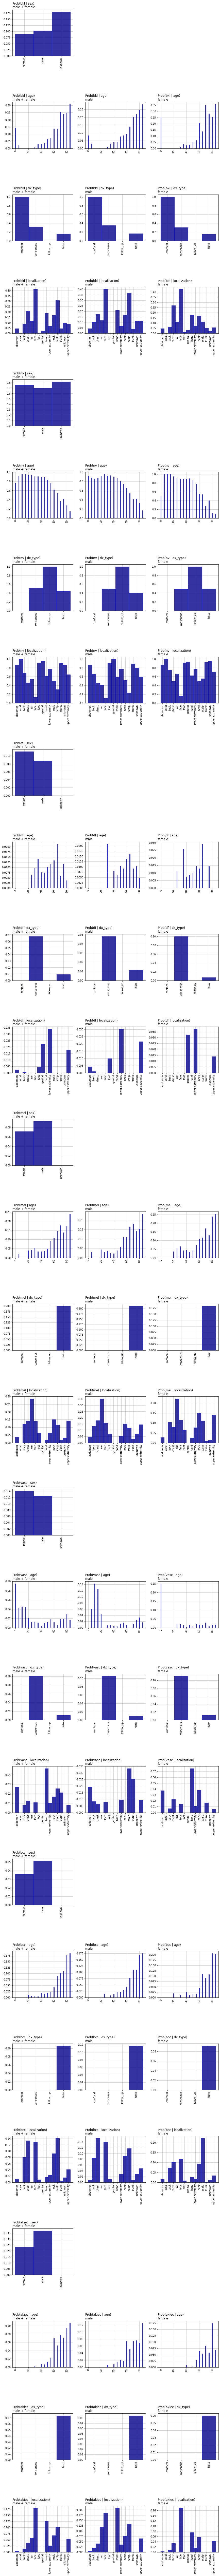

In [22]:
# Set include_duplicates  to True  to  count each distinct lesion
# with multiplicity equal to the number of images there are of it
# our dataset (i.e. count images rather than distinct lesions).
include_duplicates = False

if not include_duplicates:
    df = HAM10000_metadata_unique
    print(f'CONSIDERING ALL {df.shape[0]} *DISTINCT* LESIONS...\n')
else:
    df = HAM10000_metadata
    print(f'CONSIDERING ALL {df.shape[0]} IMAGES (LESIONS COUNTED WITH MULTIPLICITY)...\n')

diagnoses = df['dx'].unique()
n = len(diagnoses)
sex = ['male + female', 'male', 'female']
m = len(sex)
features = ['sex', 'age', 'dx_type', 'localization']
k = len(features)

width = 12
height = 140
fig, _ = plt.subplots(figsize=(width, height))
plt.subplots_adjust(hspace=1)
fig.tight_layout()

for h in range(n):
    dx = diagnoses[h]
    for i in range(k):
        for j in range(m):
            feature, gender = features[i], sex[j] 
            if feature == 'sex' and (gender != 'male + female'):
                pass
            else:
                ax = plt.subplot(n*k, m, h*k*m + i*m + j + 1)
                plt.title(f'Prob({dx} | {feature}) \n{gender}', loc='left')
                

                ax.grid(True,zorder=0,alpha=0.7)

                if gender == 'male + female': # j == 2
                    data = df
                else:
                    data = df[df['sex'] == gender]
                A = 'dx'
                B = feature
                AgivenB = pd.crosstab(data[A], data[B], normalize='columns')
                ax.bar(AgivenB.loc[dx].keys(), AgivenB.loc[dx].values, 1, color='darkblue', edgecolor='blue', alpha = 0.8, zorder = 2)
                plt.xticks(rotation=90)

<a id='unusual_nevi'></a>
### Potentially unusual nevi
↑↑ [Contents](#contents) | ↑ [Plots](#plots) | ↓ [Missing values](#missing_values)
<a id='missing_values'></a>

Most nevi are imaged just once, presumably indicating that they are typical nevi. However, some are imaged multiple times, perhaps suggesting that they are unusual. It may be interesting to see how a model performs on such lesions.

In [23]:
df = HAM10000_metadata_unique

A = 'dx'
B = 'dx_type'
AgivenBabs = pd.crosstab(df[A], df[B])
AgivenB = pd.crosstab(df[A], df[B], normalize='columns').mul(100).round(2)
BgivenAabs = pd.crosstab(df[B], df[A])
BgivenA = pd.crosstab(df[B], df[A], normalize='columns').mul(100).round(2)

print('#dx_type given dx')
display(BgivenAabs)
print('Prob(dx_type | dx)')
display(BgivenA)

#dx_type given dx


dx         akiec  bcc  bkl  df  mel    nv  vasc
dx_type                                        
confocal       0    0   34   0    0     0     0
consensus      0    0  206  44    0   332    65
follow_up      0    0    0   0    0  3704     0
histo        228  327  487  29  614  1367    33

Prob(dx_type | dx)


dx         akiec    bcc    bkl     df    mel     nv   vasc
dx_type                                                   
confocal     0.0    0.0   4.68   0.00    0.0   0.00   0.00
consensus    0.0    0.0  28.34  60.27    0.0   6.14  66.33
follow_up    0.0    0.0   0.00   0.00    0.0  68.55   0.00
histo      100.0  100.0  66.99  39.73  100.0  25.30  33.67

In [24]:
# We  saw  that around 75%  of   nevi  ('nv') were  diagnosed via
# consensus or follow-up, and  only 25% via  histopathology. (See
# Prob (dx_type | dx) in the cell for conditional probabilities.)
# It might be instructive to break this down further.

# Let's restrict our data frame to distinct nevi. For most typical
# nevi,  we  can image  a    physician  being confident   in their
# diagnosis  after  just  one   look   under a   dermatoscope. For
# unusual-looking  nevi, we can imagine a  physician taking  a few
# images if they feel there  is there is a reasonable chance of it
# being  something more  sinister,  then taking a  biopsy. Indeed,
# most nevi  that were imaged  three  or more times were diagnosed
# via histopathology. Perhaps these represent unusual-looking nevi
# that appear as though they may be melanoma. Only three nevi were
# imaged  5 or 6  times,   and  one of  these   was  diagnosed via
# histopathology,  the  other two  by consensus. Perhaps these are
# very unusual-looking nevi, that nevertheless   do not  look like
# melanoma.

df = HAM10000_metadata_unique

ddf = df[df['dx'] == 'nv']
A = 'no_of_images'
B = 'dx_type'
AgivenBabs = pd.crosstab(ddf[A], ddf[B])
AgivenB = pd.crosstab(ddf[A], ddf[B], normalize='columns').mul(100).round(2)
BgivenAabs = pd.crosstab(ddf[B], ddf[A])
BgivenA = pd.crosstab(ddf[B], ddf[A], normalize='columns').mul(100).round(2)

print('Distinct melanocytic nevi.\n'.upper())

# print('#no_of_images given dx_type')
# display(AgivenBabs)

print('Prob(no_of_images | dx_type)')
display(AgivenB)

# print('#dx_type given no_of_images')
# display(BgivenAabs)

print('Prob(dx_type | no_of_images)')
display(BgivenA)

DISTINCT MELANOCYTIC NEVI.

Prob(no_of_images | dx_type)


dx_type       consensus  follow_up  histo
no_of_images                             
1                 55.12      100.0  38.62
2                 40.36        0.0  41.33
3                  3.31        0.0  18.80
4                  0.60        0.0   1.17
5                  0.30        0.0   0.07
6                  0.30        0.0   0.00

Prob(dx_type | no_of_images)


no_of_images      1      2     3      4     5      6
dx_type                                             
consensus      4.14  19.17   4.1  11.11  50.0  100.0
follow_up     83.90   0.00   0.0   0.00   0.0    0.0
histo         11.96  80.83  95.9  88.89  50.0    0.0

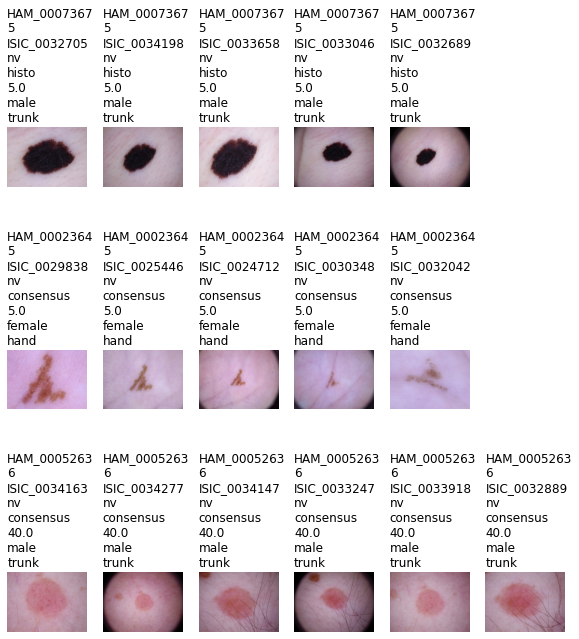

In [25]:
# Let's just  take a look at those nevi that were imaged five or
# six  times. To the untrained  eye,   these  do appear  to have
# slightly irregular borders, or perhaps have a diameter greater 
# than 6mm. It  will  be interesting to see what our models  say 
# about these lesions.

df = HAM10000_metadata[(HAM10000_metadata['dx'] == 'nv') & (HAM10000_metadata['no_of_images'] > 4)][['lesion_id', 'image_id', 'no_of_images']]
lesion_ids = df['lesion_id'].unique()
image_ids = {}

k = len(lesion_ids)
for i in range(k):
    image_ids[lesion_ids[i]] = df[df['lesion_id'] == lesion_ids[i]]['image_id'].values

max_imgs = max(len(image_ids[lesion]) for lesion in image_ids.keys())
img_count = 0
max_imgs
plt.figure(figsize=(10, 10))
for i in range(k):
    lesion = lesion_ids[i]
    m = len(image_ids[lesion])
    for j in range(m):
        img_id = image_ids[lesion][j]
        image = np.asarray(Image.open(path_to_images + img_id + img_ext))
        ax = plt.subplot(k,max_imgs, img_count + j + i + 1)
        plt.imshow(image)
        plt.subplots_adjust(top=1)
        [[lesion_id, no_of_images, image_id, dx, dx_type, age, sex, localization]] = HAM10000_metadata[HAM10000_metadata['image_id'] == img_id].values
        plt.title(lesion_id + '\n' + f'{no_of_images}' + '\n' + image_id + '\n' + dx + '\n' + dx_type + '\n' + f'{age}' + '\n' + sex + '\n' + localization, loc='left')
        plt.axis('off')
    img_count += m 

### Missing values
↑↑ [Contents](#contents) | ↑ [Potentially unusual nevi](#unusual_nevi) | ↓ [References](#references)

We may wish to use ```age```, ```sex```, and ```localization``` as features in a model. However, we do not have this information for all lesions. Fortunately, the number of missing values is not too large.

In [26]:
# Set include_duplicates  to True  to  count each distinct lesion
# with multiplicity equal to the number of images there are of it
# our dataset (i.e. count images rather than distinct lesions).
include_duplicates = False

if not include_duplicates:
    df = HAM10000_metadata_unique
    A = df['age'].isnull()
    B = df['sex'] == 'unknown'
    C = df['localization'] == 'unknown'
    print(f'Among the {df.shape[0]} distinct lesions in our dataset, the number for which values for...\n')
else:
    df = HAM10000_metadata
    A = df['age'].isnull()
    B = df['sex'] == 'unknown'
    C = df['localization'] == 'unknown'
    print(f'Among the {df.shape[0]} images in our dataset, the number for which values for...\n')
    
print(f'- at least one of age, sex, _or_ localization are missing is: {df[A | B | C].shape[0]} ({100*df[A | B | C].shape[0]/df.shape[0]:.2f}%);')
print(f'- all three of age, sex, _and_ localization are missing is: {df[A & B & C].shape[0]} ({100*df[A & B & C].shape[0]/df.shape[0]:.2f}%);')
print(f'- age is missing is: {df[A].shape[0]} ({100*df[A].shape[0]/df.shape[0]:.2f}%);')
print(f'- sex is missing is: {df[B].shape[0]} ({100*df[B].shape[0]/df.shape[0]:.2f}%);')
print(f'- localization is missing is: {df[C].shape[0]} ({100*df[C].shape[0]/df.shape[0]:.2f}%).')
# print(df[A].shape[0])
# print(df[B].shape[0])
# print(df[C].shape[0])
# print(df[A & B].shape[0])
# print(df[A & C].shape[0])
# print(df[B & C].shape[0])
# print(df[A & B & C].shape[0])
# print(df[A | B].shape[0])
# print(df[A | C].shape[0])
# print(df[A | B | C].shape[0])
# print(df[A & B & ~C].shape[0])
# ...

Among the 7470 distinct lesions in our dataset, the number for which values for...

- at least one of age, sex, _or_ localization are missing is: 213 (2.85%);
- all three of age, sex, _and_ localization are missing is: 46 (0.62%);
- age is missing is: 52 (0.70%);
- sex is missing is: 50 (0.67%);
- localization is missing is: 203 (2.72%).


<a id='references'></a>
## References
↑↑ [Contents](#contents) | ↑ [Missing values](#missing_values)

<a id = 'HAM10000ref'>[TSC2018]</a> Tschandl, Philipp, 2018, "The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions", https://doi.org/10.7910/DVN/DBW86T, Harvard Dataverse, V4, UNF:6:KCZFcBLiFE5ObWcTc2ZBOA== [fileUNF]

<a id = 'Wen_et_al_ref'>[WEN2022]</a> Wen, David, et. al. "[Characteristics of publicly available skin cancer image datasets: a systematic review](https://doi.org/10.1016/S2589-7500(21)00252-1)." _The Lancet Digital Health_ 4(1), E64–E74, 2022.